### Exploración, preprocesamiento y analísis bases de datos ElectroDunas

In [1]:
!pip install kneed

In [2]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.3 MB/s eta 0:00:0000:010:01


In [3]:
import pandas as pd
import numpy as np
import os
import ruptures as rpt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
from sklearn.ensemble import IsolationForest
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
#pd.options.display.max_columns = None
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

#### Se realiza la consolidación de los diferentes archivos compartidos por ElectroDunas

In [4]:
# # Directorio que contiene los archivos CSV
# directorio = r'E:\Maestria\Andes\Gerencia de proyectos\datos\GPA-Data-ElectroDunas-main'

# # Lista para almacenar los DataFrames de cada archivo
# dataframes = []

# # Iterar sobre cada archivo en el directorio
# for archivo in os.listdir(directorio):
#     if archivo.endswith('.csv'):
#         # Leer el archivo CSV y agregar una columna con el nombre del archivo
#         path_completo = os.path.join(directorio, archivo)
#         df = pd.read_csv(path_completo)
#         df['Archivo'] = archivo
#         dataframes.append(df)

# # Concatenar todos los DataFrames en uno solo
# df_final = pd.concat(dataframes, ignore_index=True)

# # Guardar el DataFrame consolidado en un nuevo archivo CSV
# df_final.to_csv(r'E:\Maestria\Andes\Gerencia de proyectos\datos\consolidado.csv', index=False)

In [5]:
df = pd.read_csv('/kaggle/input/clientes-electrodunas/consolidado.csv', sep=';')
df_sector = pd.read_excel('/kaggle/input/sector-economico-clientes/sector_economico_clientes.xlsx')

def structure_df(df, df_sector):
    df['ID_Cliente'] = df['Archivo'].replace('[^0-9]', '', regex=True)
    df['ID_Cliente'] = 'Cliente ' + df['ID_Cliente'].astype(str)
    df_sector['Cliente:'] = df_sector['Cliente:'].str.strip()
    df = df.merge(df_sector, left_on = 'ID_Cliente', right_on = 'Cliente:', how='left')
    df.drop(columns = 'Cliente:', inplace=True)
    df.rename(columns={'Sector Económico:': 'Sector'}, inplace=True)

    # Verificar si el número del cliente es de un solo dígito y agregar un cero si es necesario
    df['ID_Cliente'] = df['ID_Cliente'].astype(str)
    df['ID_Cliente'] = df['ID_Cliente'].apply(lambda x: 'Cliente ' + x.split()[-1].zfill(2) if len(x.split()[-1]) == 1 else x)

    # Agregar las columnas de año, mes, día de la semana y hora
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df['Año'] = df['Fecha'].dt.year
    df['Mes'] = df['Fecha'].dt.month
    df['Dia_Semana'] = df['Fecha'].dt.day_name()
    df['Hora'] = df['Fecha'].dt.hour
    
    
    # Crear key
    df = df.reset_index().rename(columns={'index':'key'})
    return df

df = structure_df(df, df_sector)
client_init = ['Cliente 01', 'Cliente 02', 'Cliente 03', 'Cliente 04', 'Cliente 05', 
               'Cliente 06', 'Cliente 07', 'Cliente 08', 'Cliente 09', 'Cliente 10', 
               'Cliente 16', 'Cliente 17',  'Cliente 18', 'Cliente 19', 'Cliente 20'] # lista de clientes

df = df[df['ID_Cliente'].isin(client_init)]
print(df.shape)
df.head()

(294310, 13)


key               Fecha  Active_energy  Reactive_energy  Voltaje_FA  \
0    0 2021-01-01 00:00:00       0.357841         0.282788  455.139171   
1    1 2021-01-01 01:00:00       0.372264         0.431377  469.978787   
2    2 2021-01-01 02:00:00       1.044687         0.338626  468.721120   
3    3 2021-01-01 03:00:00       0.566425         0.495791  452.329255   
4    4 2021-01-01 04:00:00       1.080556         0.472018  513.477596   

   Voltaje_FC            Archivo  ID_Cliente  \
0  510.561002  DATOSCLIENTE1.csv  Cliente 01   
1  469.917178  DATOSCLIENTE1.csv  Cliente 01   
2  546.949147  DATOSCLIENTE1.csv  Cliente 01   
3  444.122989  DATOSCLIENTE1.csv  Cliente 01   
4  535.463719  DATOSCLIENTE1.csv  Cliente 01   

                                              Sector   Año  Mes Dia_Semana  \
0  Elaboración de cacao y chocolate y de producto...  2021    1     Friday   
1  Elaboración de cacao y chocolate y de producto...  2021    1     Friday   
2  Elaboración de cacao y chocolate y de producto...  2021    1     Friday   
3  Elaboración de cacao y chocolate y de producto...  2021    1     Friday   
4  Elaboración de cacao y chocolate y de producto...  2021    1     Friday   

   Hora  
0     0  
1     1  
2     2  
3     3  
4     4

In [6]:
def calcular_porcentaje_completitud(df_final):
    # Asegurarse de que la columna 'Fecha' sea de tipo datetime
    df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

    # Rango de fechas especificado
    fecha_inicio = pd.Timestamp('2021-01-01 00:00:00')
    fecha_fin = pd.Timestamp('2023-04-01 00:00:00')

    # Filtrar el DataFrame para el rango de fechas especificado
    df_periodo = df_final[(df_final['Fecha'] >= fecha_inicio) & (df_final['Fecha'] <= fecha_fin)]

    # Calcular la duración total del periodo
    duracion_total = fecha_fin - fecha_inicio

    # Calcular la duración cubierta por cada archivo
    duracion_por_archivo = df_periodo.groupby('ID_Cliente')['Fecha'].agg(lambda x: x.max() - x.min())

    # Calcular el porcentaje de completitud para cada archivo
    porcentaje_completitud = (duracion_por_archivo / duracion_total) * 100

    # Crear un DataFrame con los resultados
    resultados = pd.DataFrame({
        'ID_Cliente': porcentaje_completitud.index,
        'Completitud': porcentaje_completitud.values,
        'Fecha inicio': df_periodo.groupby('ID_Cliente')['Fecha'].min().values,
        'Fecha final': df_periodo.groupby('ID_Cliente')['Fecha'].max().values
    })

    return resultados

Completitud = calcular_porcentaje_completitud(df)
Completitud

ID_Cliente  Completitud Fecha inicio         Fecha final
0   Cliente 01   100.000000   2021-01-01 2023-04-01 00:00:00
1   Cliente 02   100.000000   2021-01-01 2023-04-01 00:00:00
2   Cliente 03   100.000000   2021-01-01 2023-04-01 00:00:00
3   Cliente 04   100.000000   2021-01-01 2023-04-01 00:00:00
4   Cliente 05   100.000000   2021-01-01 2023-04-01 00:00:00
5   Cliente 06   100.000000   2021-01-01 2023-04-01 00:00:00
6   Cliente 07   100.000000   2021-01-01 2023-04-01 00:00:00
7   Cliente 08   100.000000   2021-01-01 2023-04-01 00:00:00
8   Cliente 09   100.000000   2021-01-01 2023-04-01 00:00:00
9   Cliente 10   100.000000   2021-01-01 2023-04-01 00:00:00
10  Cliente 16    99.080285   2021-01-01 2023-03-24 11:00:00
11  Cliente 17    99.080285   2021-01-01 2023-03-24 11:00:00
12  Cliente 18    99.080285   2021-01-01 2023-03-24 11:00:00
13  Cliente 19    99.080285   2021-01-01 2023-03-24 11:00:00
14  Cliente 20    99.080285   2021-01-01 2023-03-24 11:00:00

In [7]:
def ajustar_series_temporales(df, fecha_limite='2023-03-24'):

    df['Fecha'] = pd.to_datetime(df['Fecha'])
    max_fecha_por_cliente = df.groupby('ID_Cliente')['Fecha'].max()
    for cliente, max_fecha in max_fecha_por_cliente.items():
        if max_fecha > pd.to_datetime(fecha_limite):
            df.loc[(df['ID_Cliente'] == cliente) & (df['Fecha'] > pd.to_datetime(fecha_limite)), :] = None
    
    df = df.dropna()
    return df

df_ajustado = ajustar_series_temporales(df)
Completitud = calcular_porcentaje_completitud(df_ajustado)
Completitud

ID_Cliente  Completitud Fecha inicio Fecha final
0   Cliente 01     99.02439   2021-01-01  2023-03-24
1   Cliente 02     99.02439   2021-01-01  2023-03-24
2   Cliente 03     99.02439   2021-01-01  2023-03-24
3   Cliente 04     99.02439   2021-01-01  2023-03-24
4   Cliente 05     99.02439   2021-01-01  2023-03-24
5   Cliente 06     99.02439   2021-01-01  2023-03-24
6   Cliente 07     99.02439   2021-01-01  2023-03-24
7   Cliente 08     99.02439   2021-01-01  2023-03-24
8   Cliente 09     99.02439   2021-01-01  2023-03-24
9   Cliente 10     99.02439   2021-01-01  2023-03-24
10  Cliente 16     99.02439   2021-01-01  2023-03-24
11  Cliente 17     99.02439   2021-01-01  2023-03-24
12  Cliente 18     99.02439   2021-01-01  2023-03-24
13  Cliente 19     99.02439   2021-01-01  2023-03-24
14  Cliente 20     99.02439   2021-01-01  2023-03-24

In [8]:
# Muestreo por bootstrap
size = int(len(df_ajustado) * 0.1)
num_bootstrap_samples = 8

bootstrap_samples = []
for _ in range(num_bootstrap_samples):
    bootstrap_sample = df_ajustado.sample(n=size, replace=True)
    bootstrap_samples.append(bootstrap_sample)

for i, sample in enumerate(bootstrap_samples):
    print(f"Muestra Bootstrap {i+1}:")
    print(len(sample))

Muestra Bootstrap 1:
29233
Muestra Bootstrap 2:
29233
Muestra Bootstrap 3:
29233
Muestra Bootstrap 4:
29233
Muestra Bootstrap 5:
29233
Muestra Bootstrap 6:
29233
Muestra Bootstrap 7:
29233
Muestra Bootstrap 8:
29233


In [9]:
# Prueba con cliente 1
df_sample = bootstrap_samples[4]
df_client1 = df_sample[df_sample['ID_Cliente'] == 'Cliente 01']
df_client1.head()

key               Fecha  Active_energy  Reactive_energy  \
403      403.0 2021-01-17 19:00:00       1.418333         0.900217   
12505  12505.0 2022-06-06 01:00:00       0.938680         0.615584   
19291  19291.0 2023-03-15 19:00:00       1.601848         0.701277   
16621  16621.0 2022-11-24 13:00:00       1.085052         0.746128   
3708    3708.0 2021-06-04 12:00:00       1.170144         0.843233   

       Voltaje_FA  Voltaje_FC            Archivo  ID_Cliente  \
403    482.247792  540.575308  DATOSCLIENTE1.csv  Cliente 01   
12505  473.680948  489.294299  DATOSCLIENTE1.csv  Cliente 01   
19291  521.524123  538.043799  DATOSCLIENTE1.csv  Cliente 01   
16621  507.172336  399.809398  DATOSCLIENTE1.csv  Cliente 01   
3708   546.392160  566.415678  DATOSCLIENTE1.csv  Cliente 01   

                                                  Sector     Año   Mes  \
403    Elaboración de cacao y chocolate y de producto...  2021.0   1.0   
12505  Elaboración de cacao y chocolate y de producto...  2022.0   6.0   
19291  Elaboración de cacao y chocolate y de producto...  2023.0   3.0   
16621  Elaboración de cacao y chocolate y de producto...  2022.0  11.0   
3708   Elaboración de cacao y chocolate y de producto...  2021.0   6.0   

      Dia_Semana  Hora  
403       Sunday  19.0  
12505     Monday   1.0  
19291  Wednesday  19.0  
16621   Thursday  13.0  
3708      Friday  12.0

## Methods anomalies

In [10]:
import seaborn as sns

In [ ]:
def graphic_time_series(df, col):
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df_sorted = df.sort_values('Fecha')  # Ordenar el DataFrame por la columna 'Fecha'

    plt.figure(figsize=(15, 6))

    plt.plot(df_sorted['Fecha'], df_sorted['Active_energy'], color='blue', label='Consumo de Energía Activa')
    anomalies = df_sorted[df_sorted[col] == 1]
    plt.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='red', label='Anomalías', zorder=5)
    plt.xlabel('Fecha')
    plt.ylabel('Consumo de Energía Activa')
    plt.title('Serie de Tiempo del Consumo de Energía Activa')
    plt.legend()
    plt.xticks(rotation=45)  # Rotar etiquetas del eje x
    plt.tight_layout()
    plt.show()

def detect_anomalies_isolation_forest(df, col, contamination=0.05):
    X = df[[col]]
    model = IsolationForest(contamination=contamination, random_state=42)
    anomalies = model.fit_predict(X)
    df['Anomalies_isolationForest'] = np.where(anomalies == -1, 1, 0)
    return df

# Experimentos
def run_experiments(df, col):
    results = []
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for i in range(6):
        contamination = 0.05 * (i + 1)  # Contamination ranging from 5% to 25%
        df_experiment = df.copy()
        df_experiment = detect_anomalies_isolation_forest(df_experiment, col, contamination=contamination)
        anomalies_detected = df_experiment['Anomalies_isolationForest'].sum()
        total_samples = len(df_experiment)
        percentage_anomalies = (anomalies_detected / total_samples) * 100
        results.append({
            'Experimento': i + 1,
            'Tasa de Contaminación': f"{int(contamination * 100)}%",
            'Anomalías Detectadas': anomalies_detected,
            '% Anomalías': f"{percentage_anomalies:.2f}%"
        })
        # Gráfico correspondiente al experimento actual
        ax_row = i // 3  # Fila en la rejilla
        ax_col = i % 3   # Columna en la rejilla
        ax = axes[ax_row, ax_col]
        df_experiment['Fecha'] = pd.to_datetime(df_experiment['Fecha'])
        df_sorted = df_experiment.sort_values('Fecha')  # Ordenar el DataFrame por la columna 'Fecha'
        ax.plot(df_sorted['Fecha'], df_sorted['Active_energy'], color='blue', label='Consumo de Energía Activa')
        anomalies = df_sorted[df_sorted['Anomalies_isolationForest'] == 1]  # Filtrar anomalías
        ax.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='red', label='Anomalías', zorder=5)
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Consumo de Energía Activa')
        ax.set_title(f'Experimento {i + 1}: Tasa de Contaminación {int(contamination * 100)}%')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x

    plt.tight_layout()
    plt.show()

    return results

experiments = run_experiments(df_client1, 'Active_energy')
experiments = pd.DataFrame(experiments)
experiments

Cliente 04


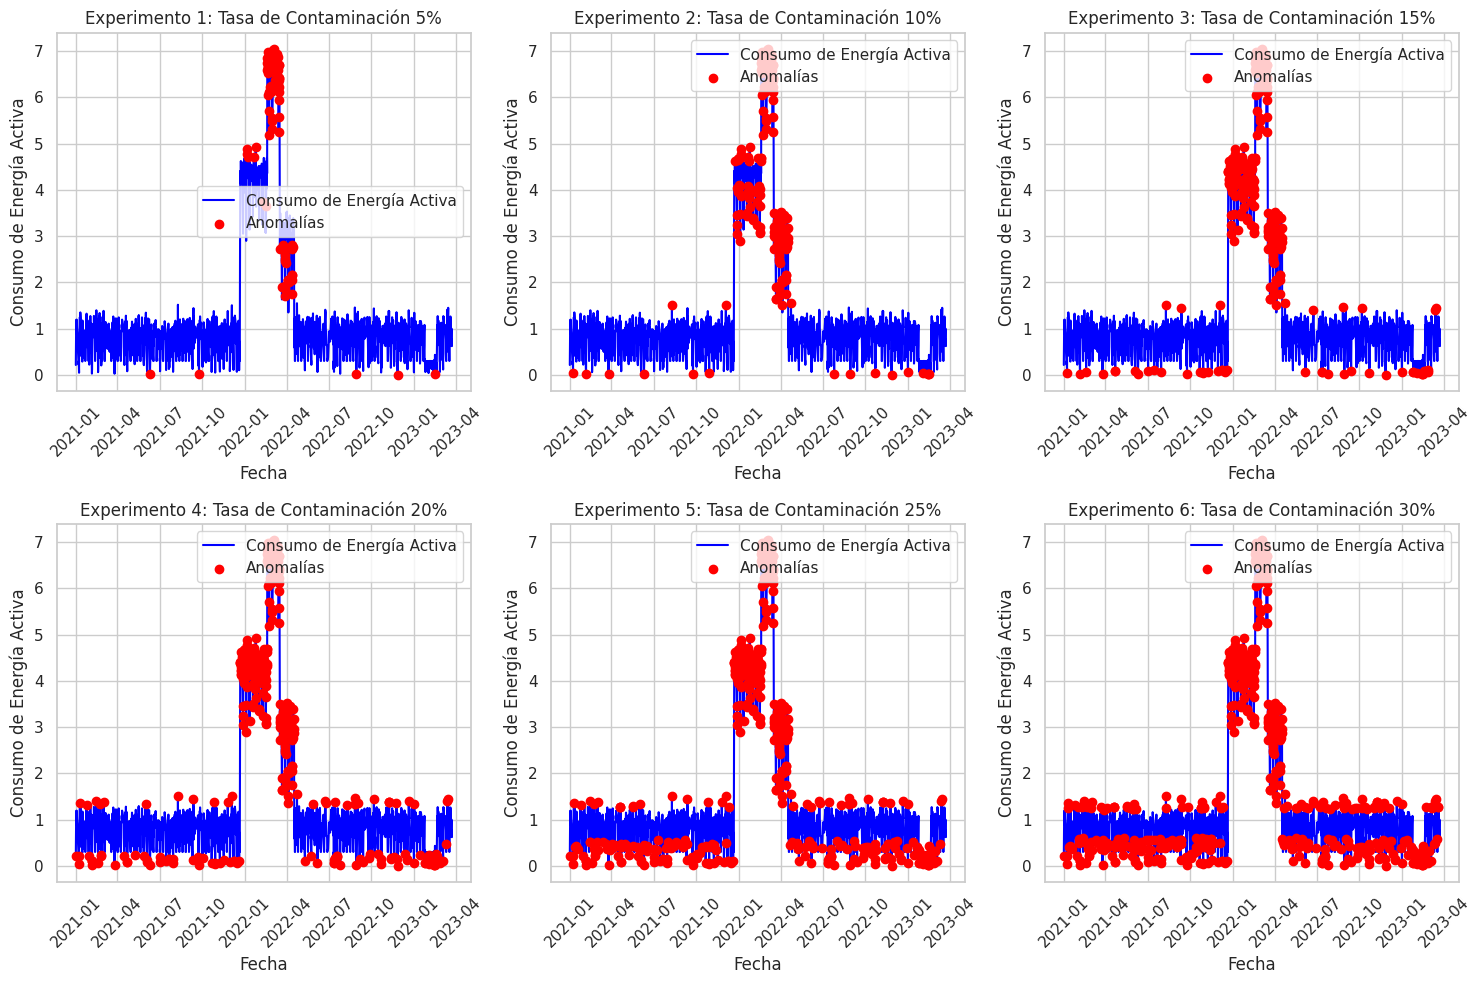

Cliente 09


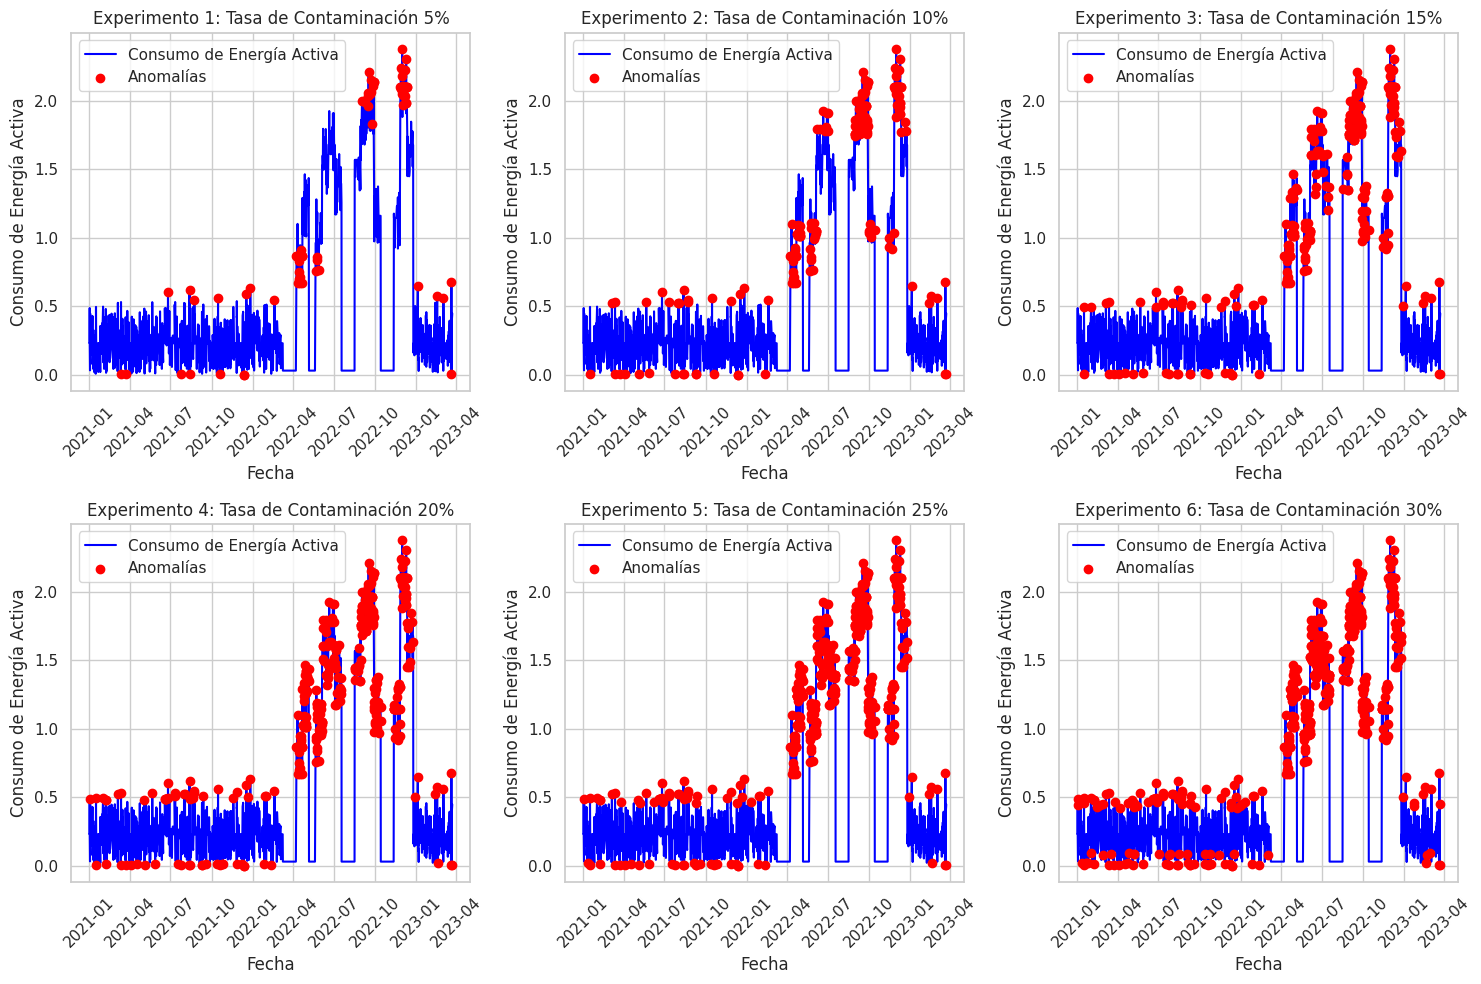

Cliente 16


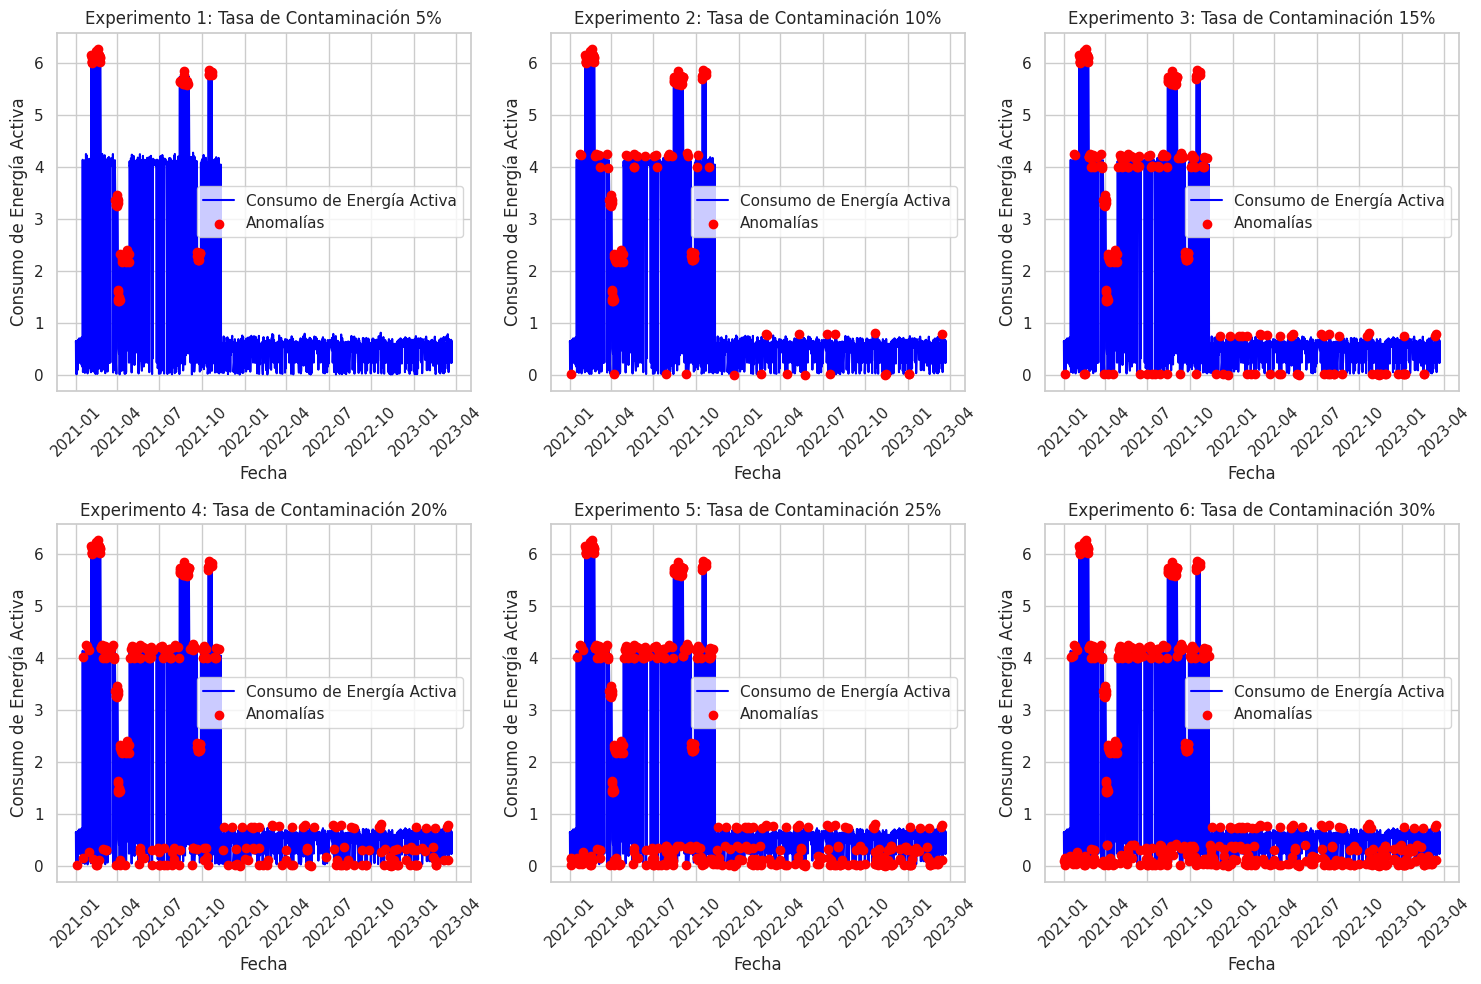

Cliente 03


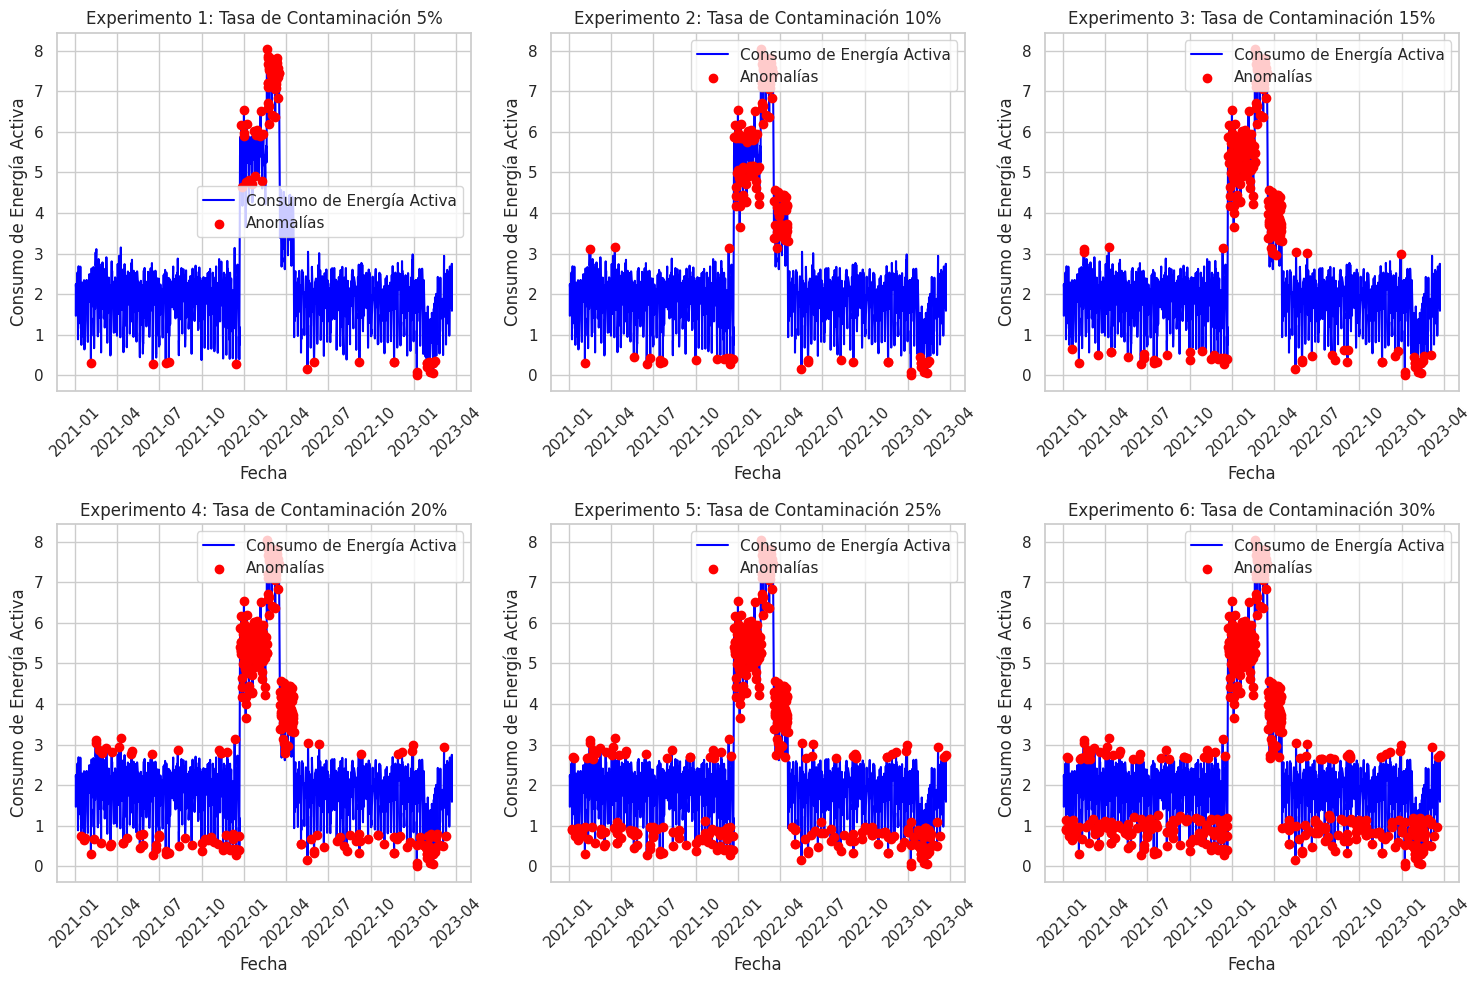

Cliente 19


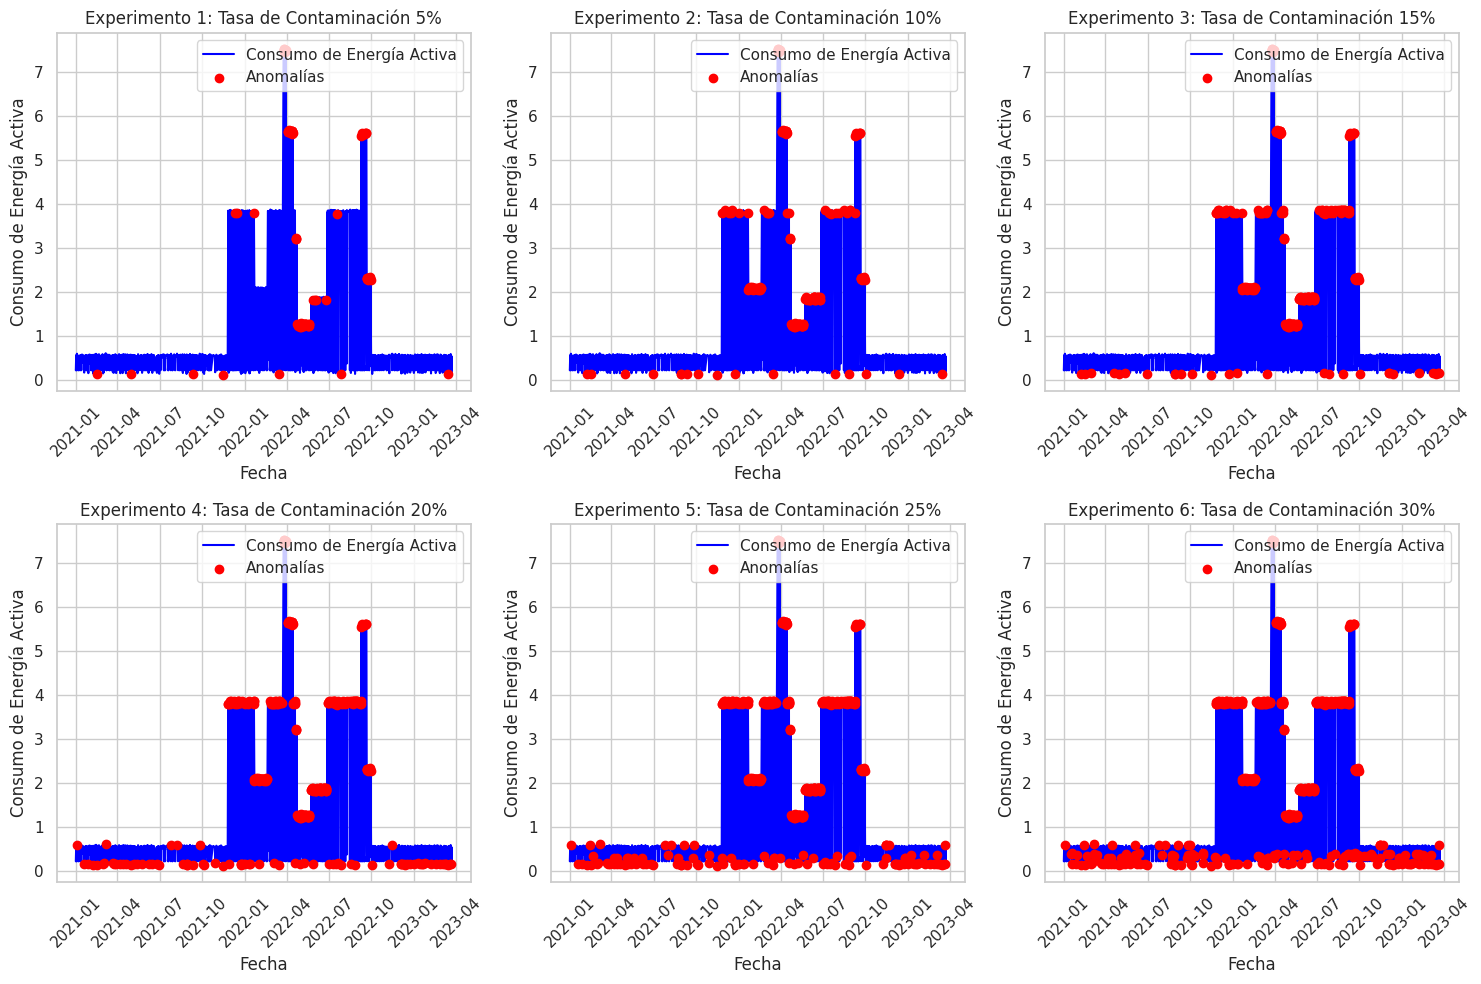

Cliente 02


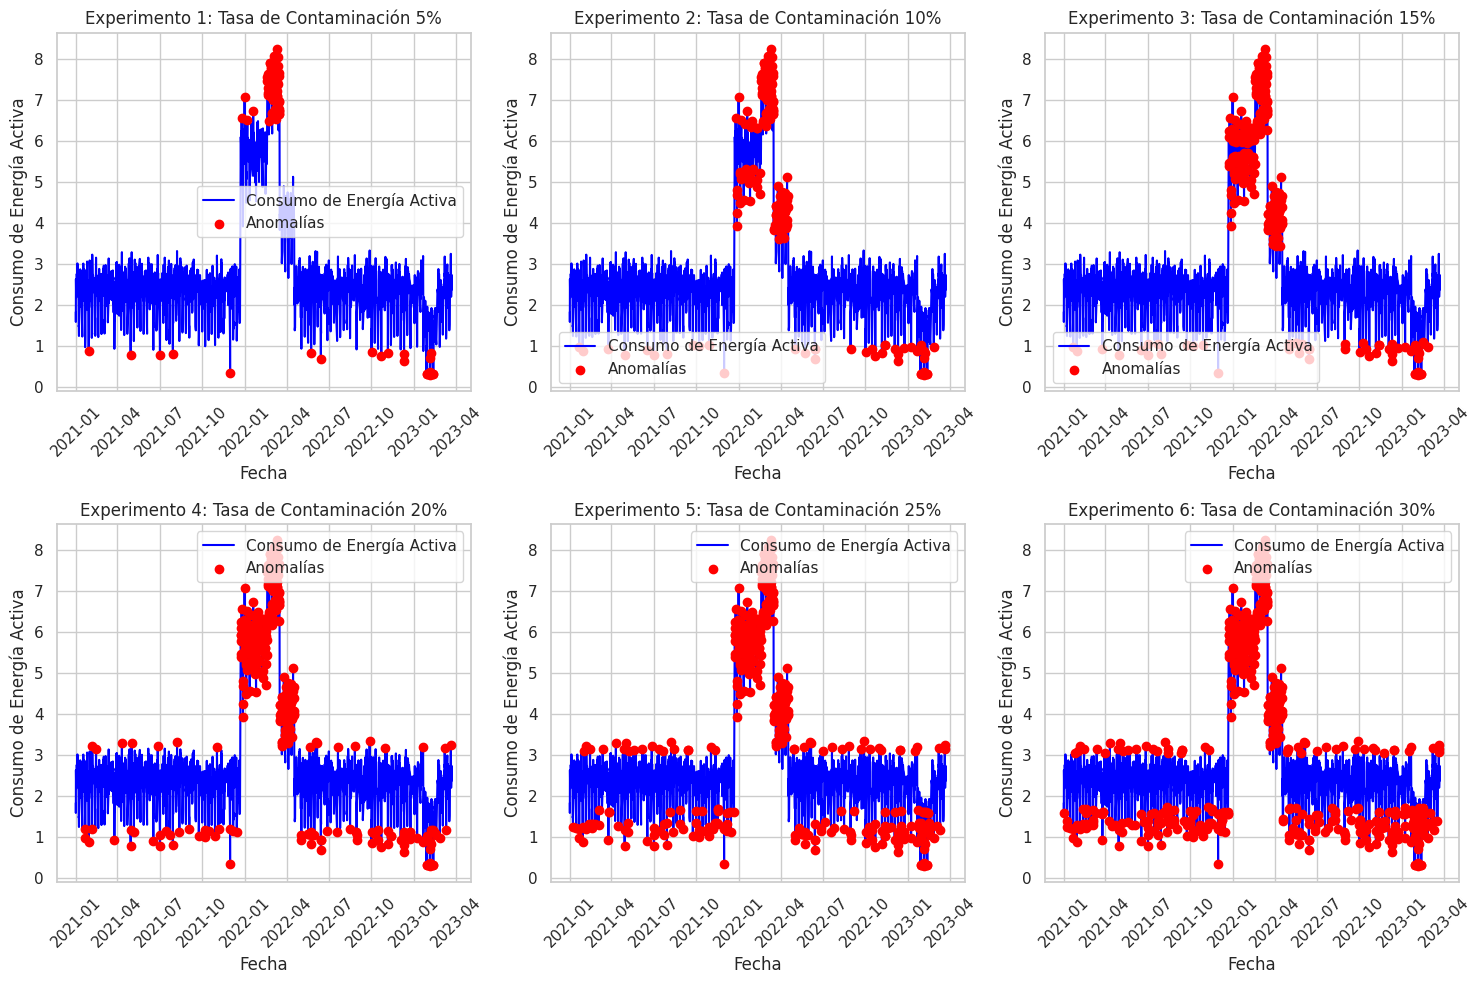

Cliente 10


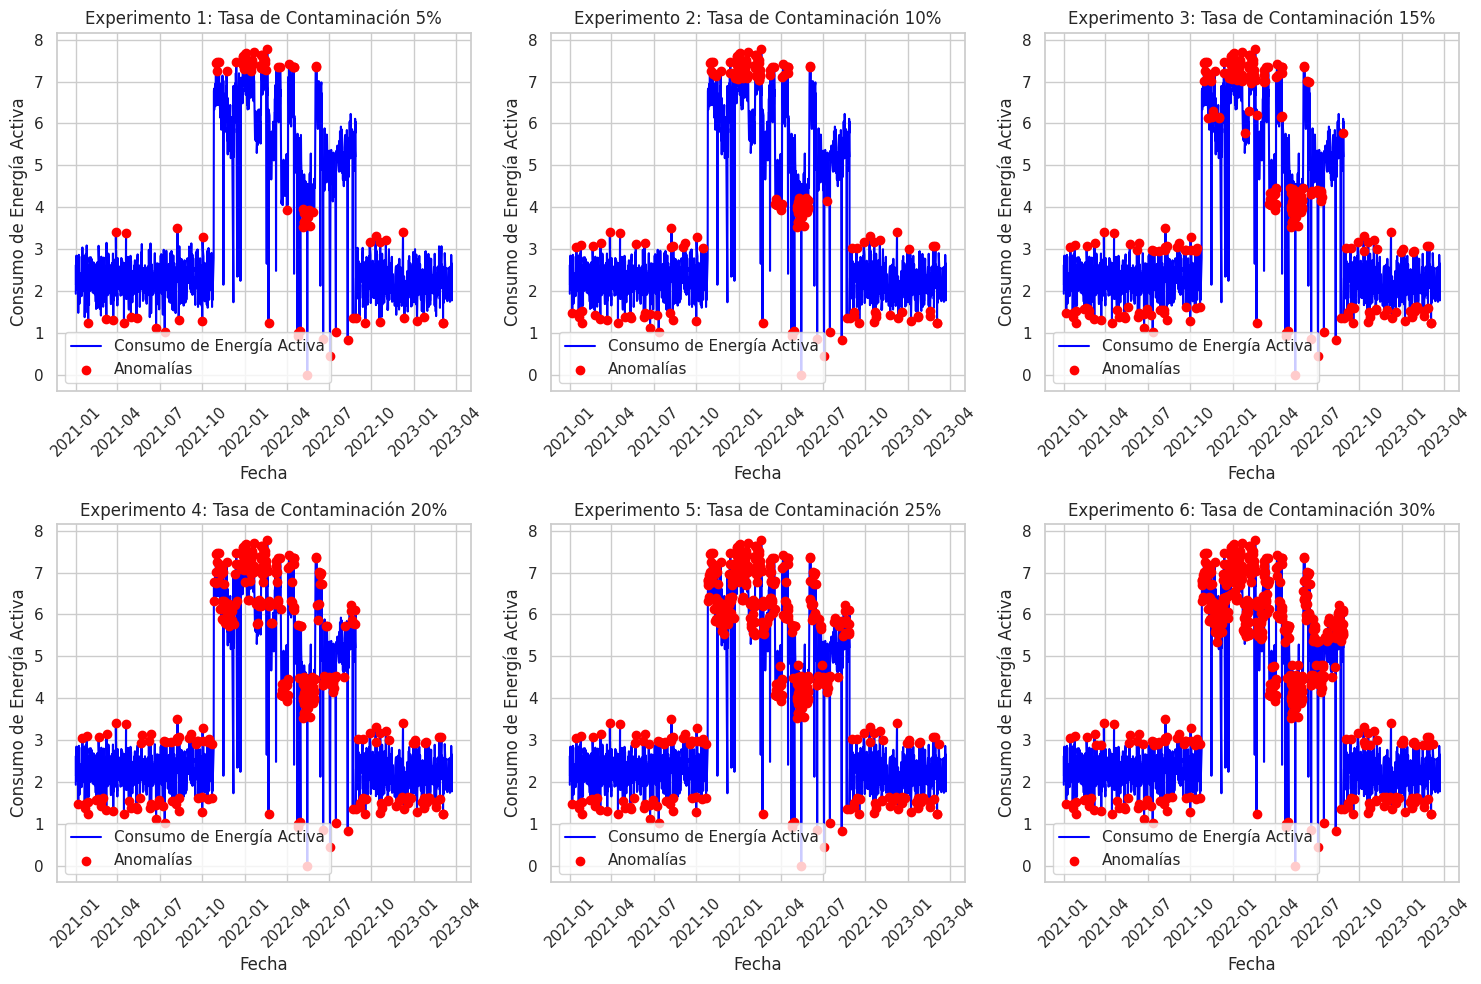

Cliente 08


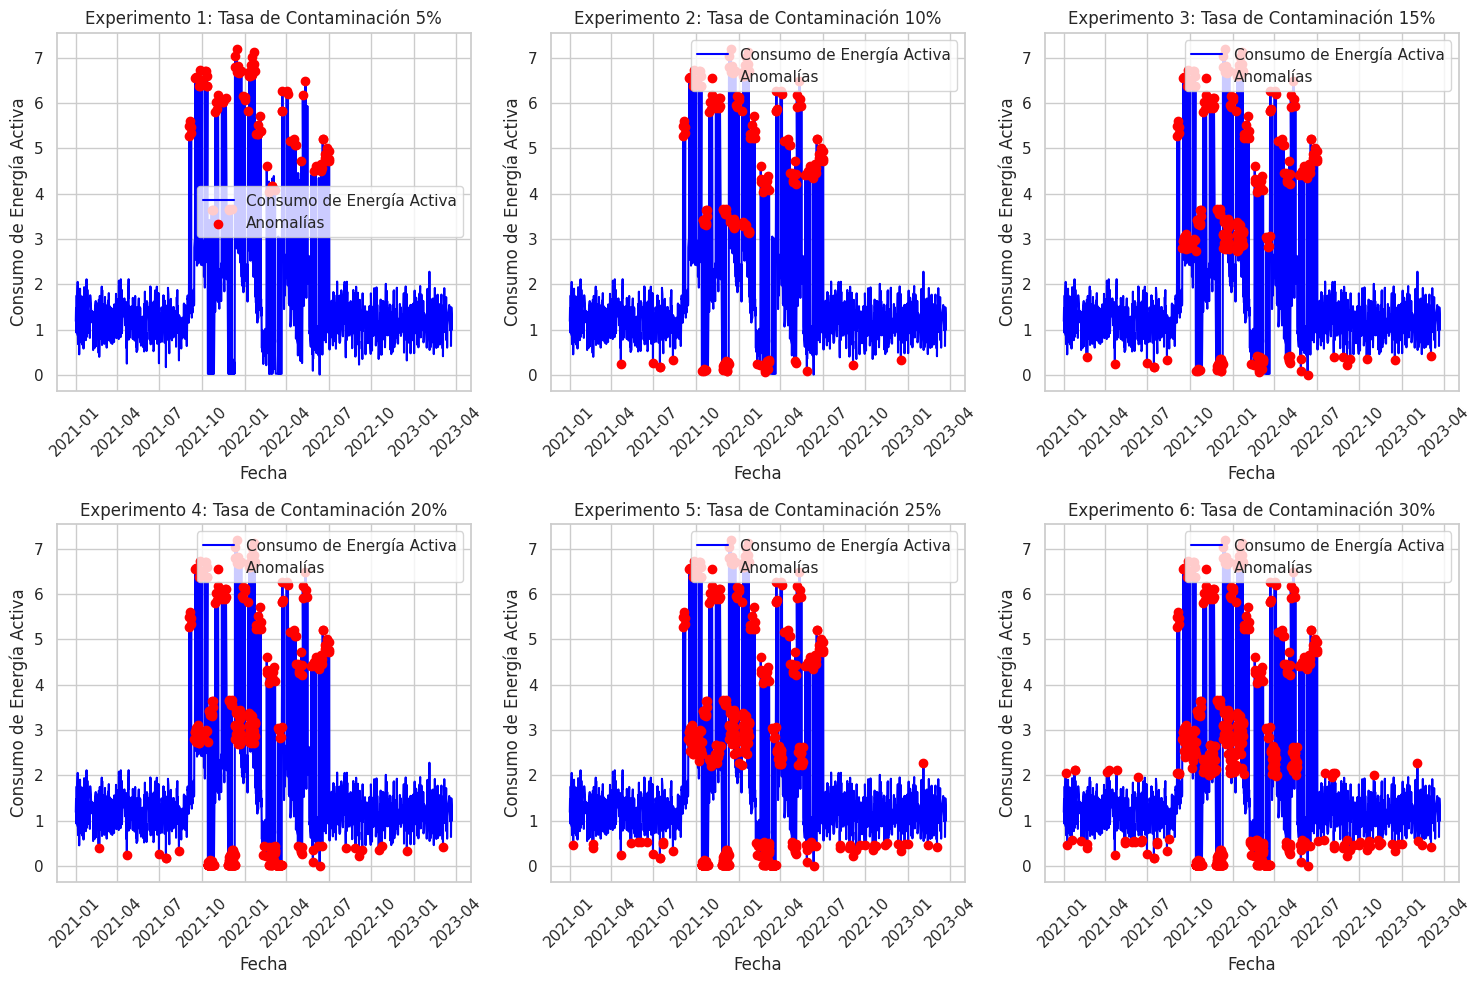

Cliente 17


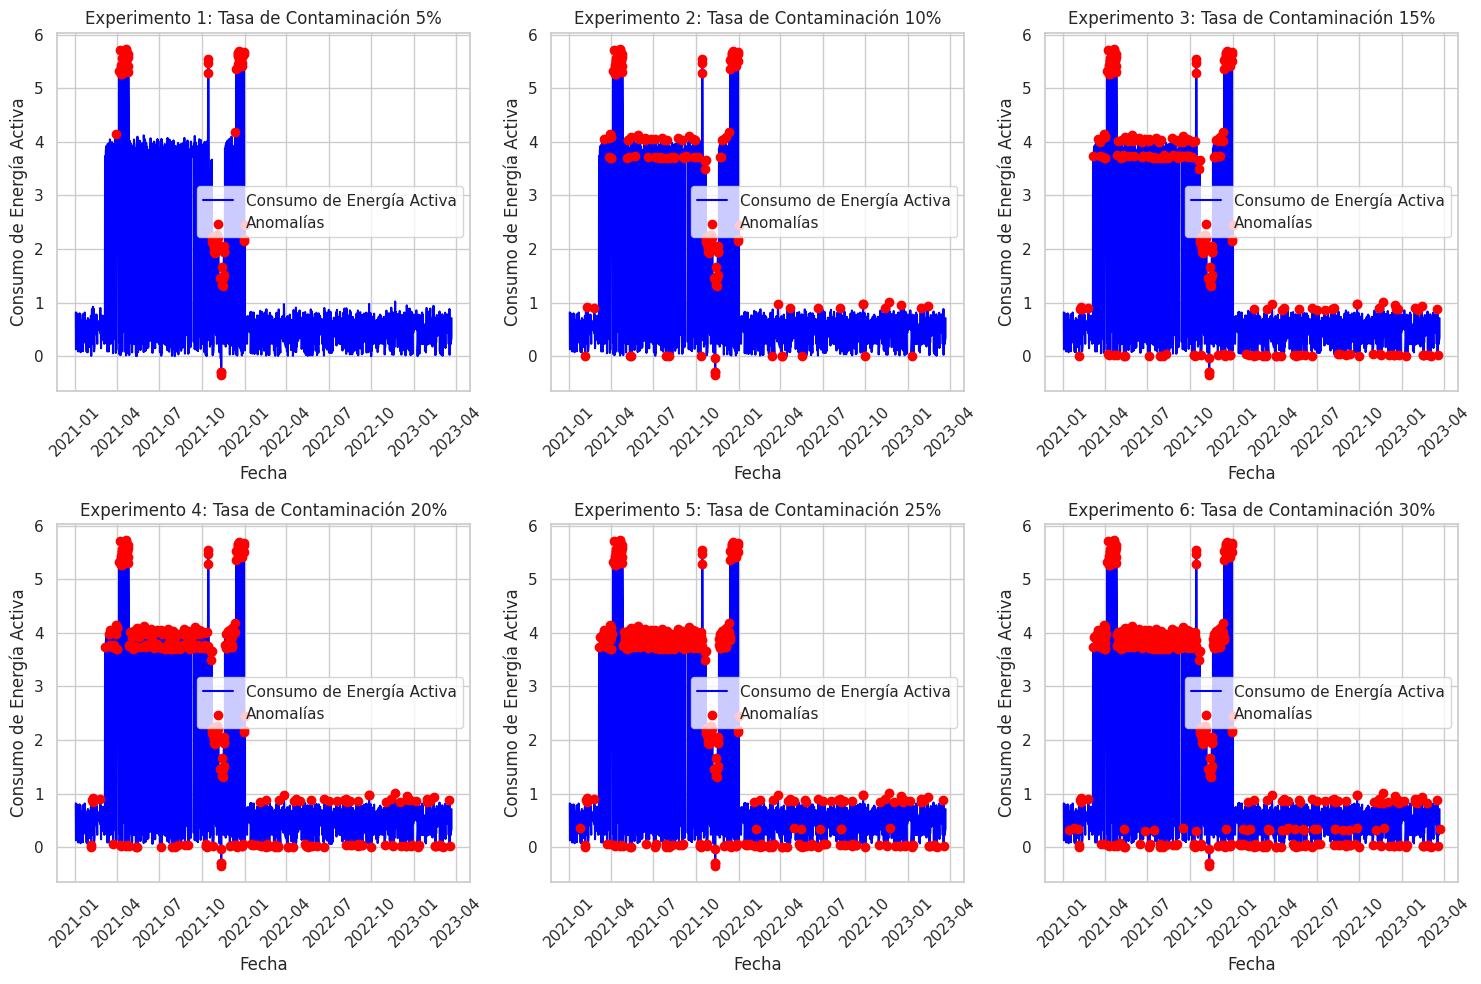

Cliente 06


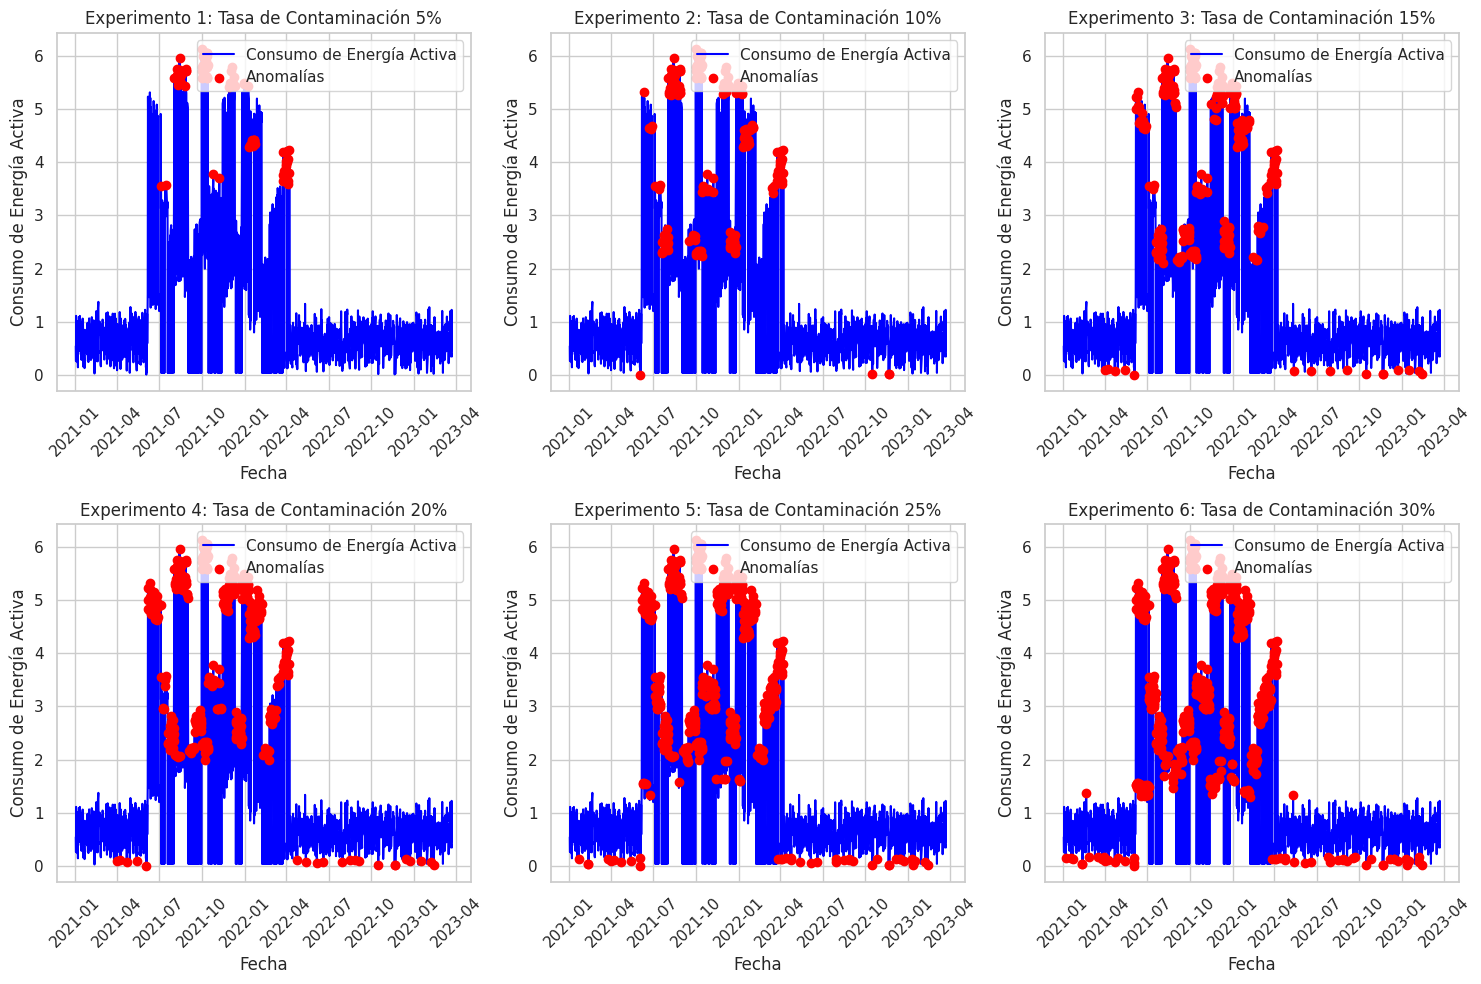

Cliente 07


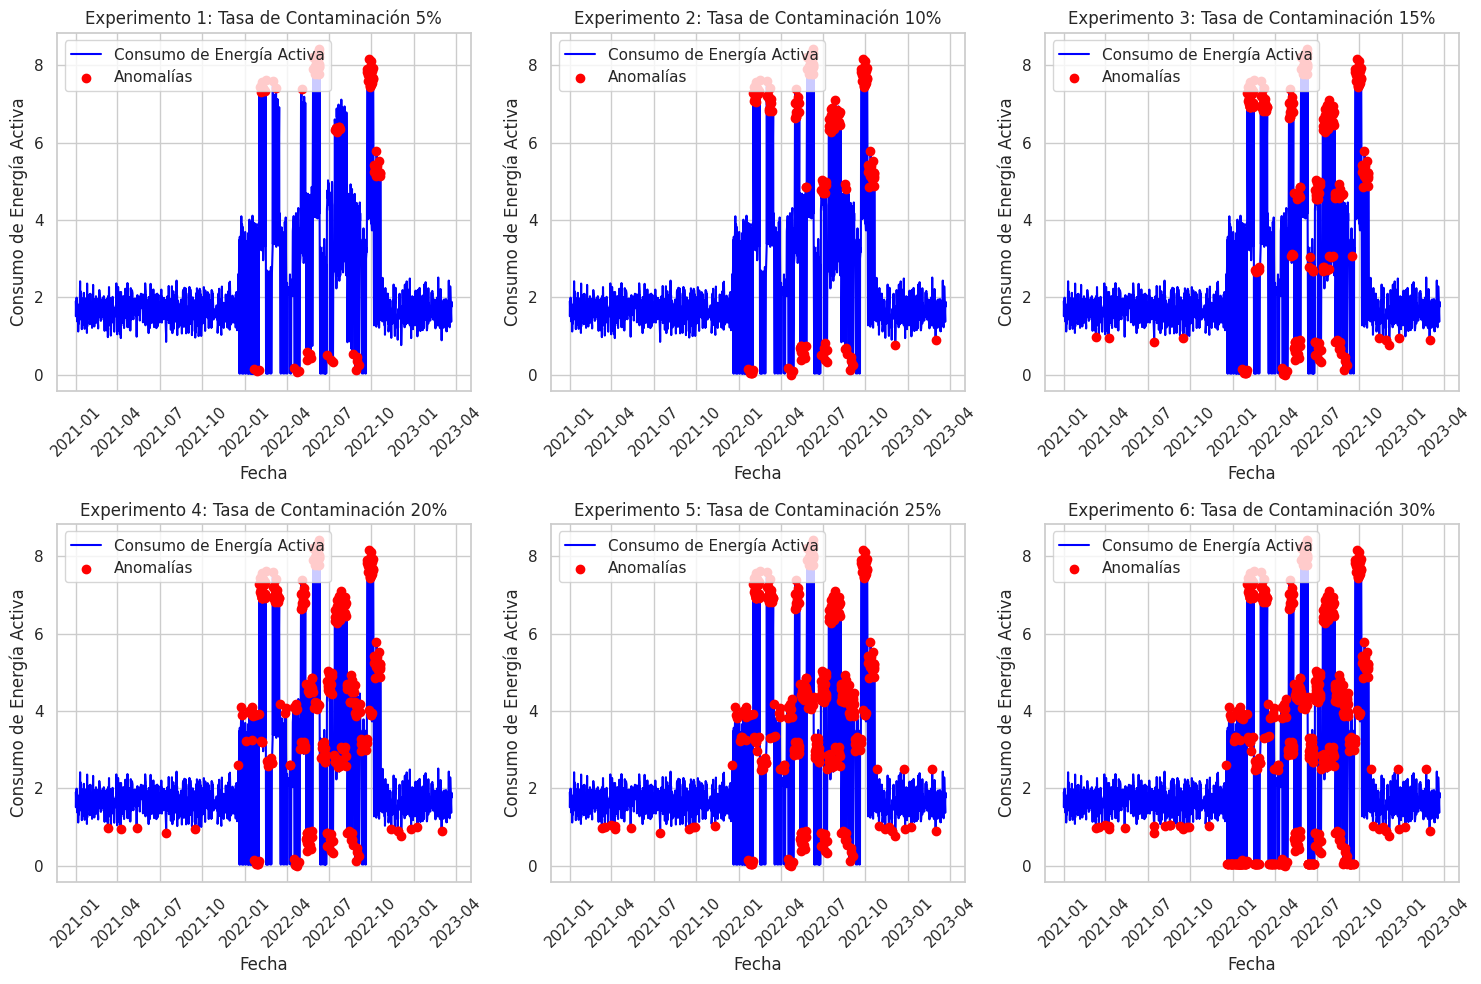

Cliente 20


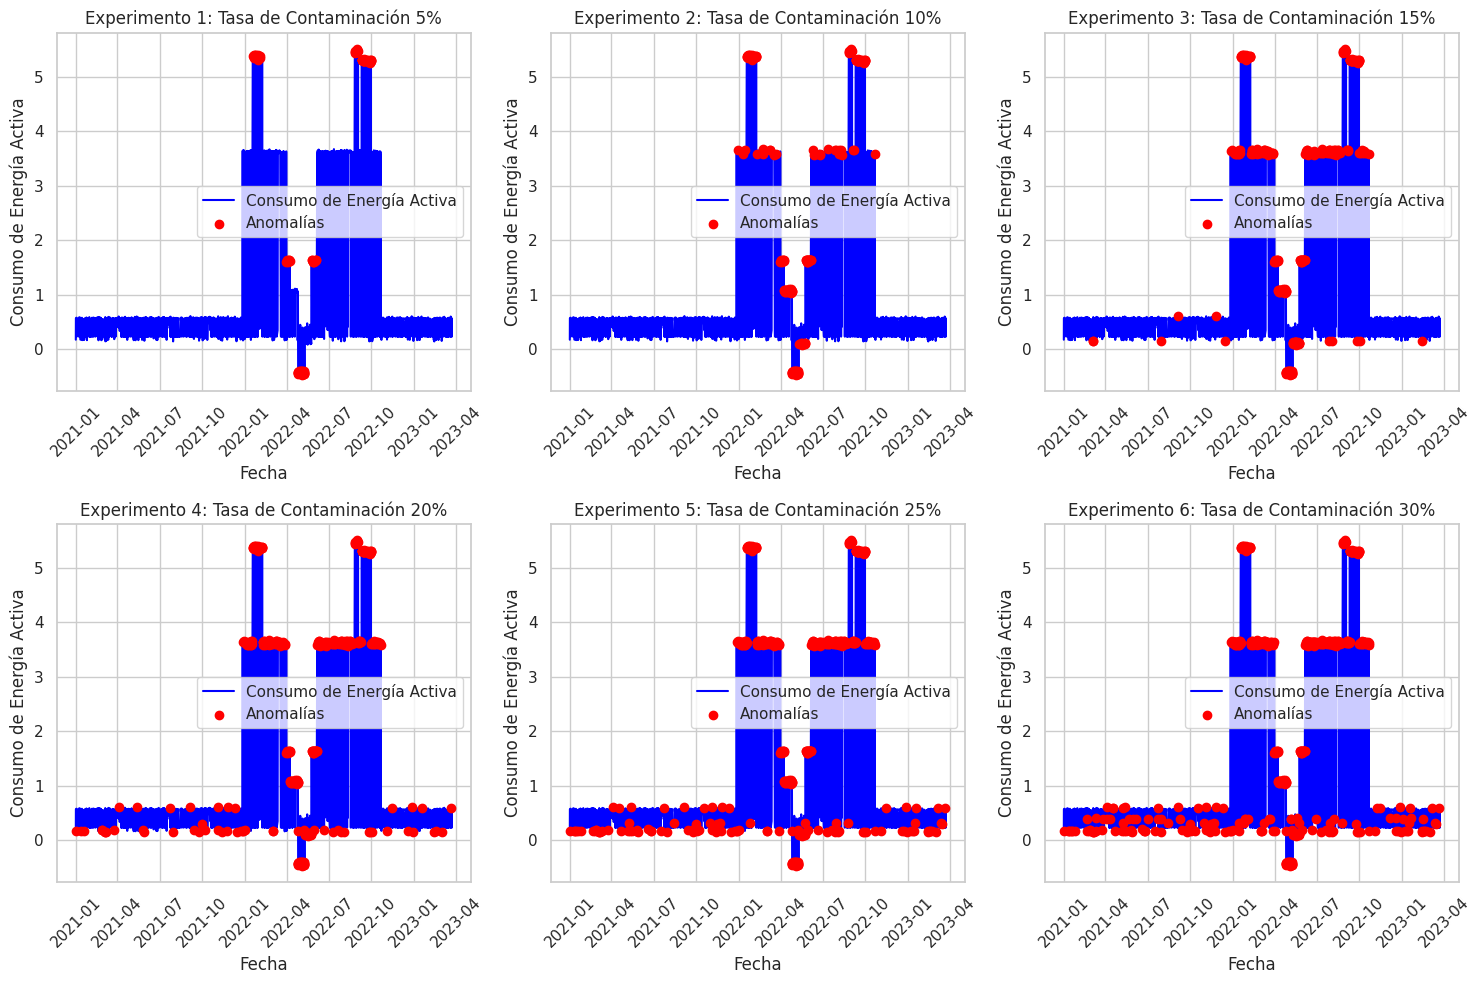

Cliente 18


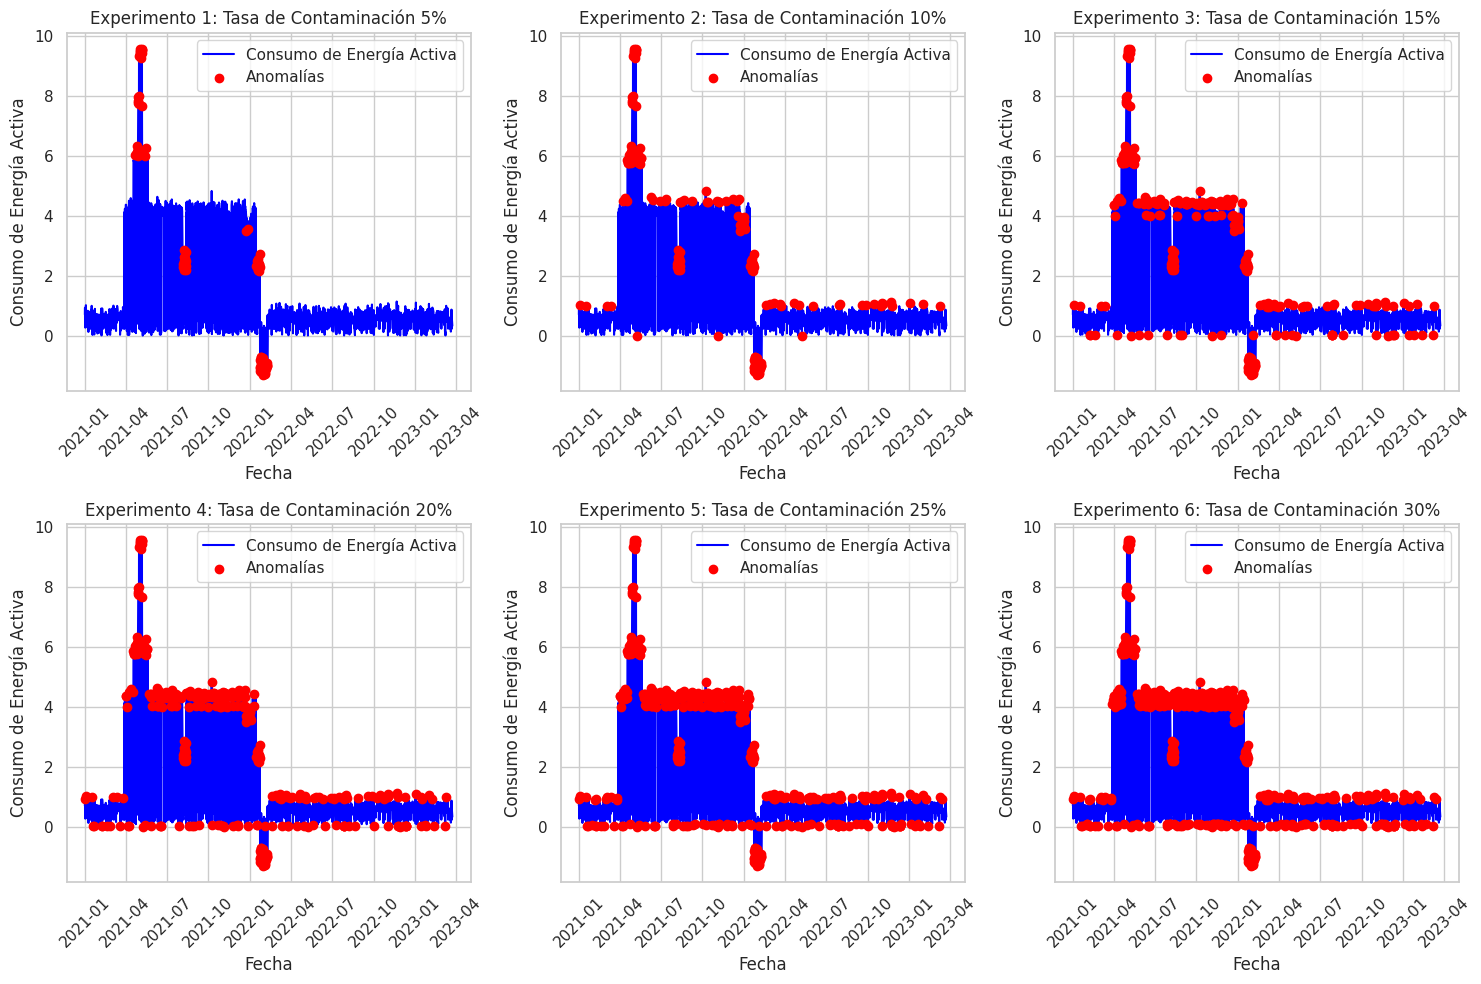

Cliente 01


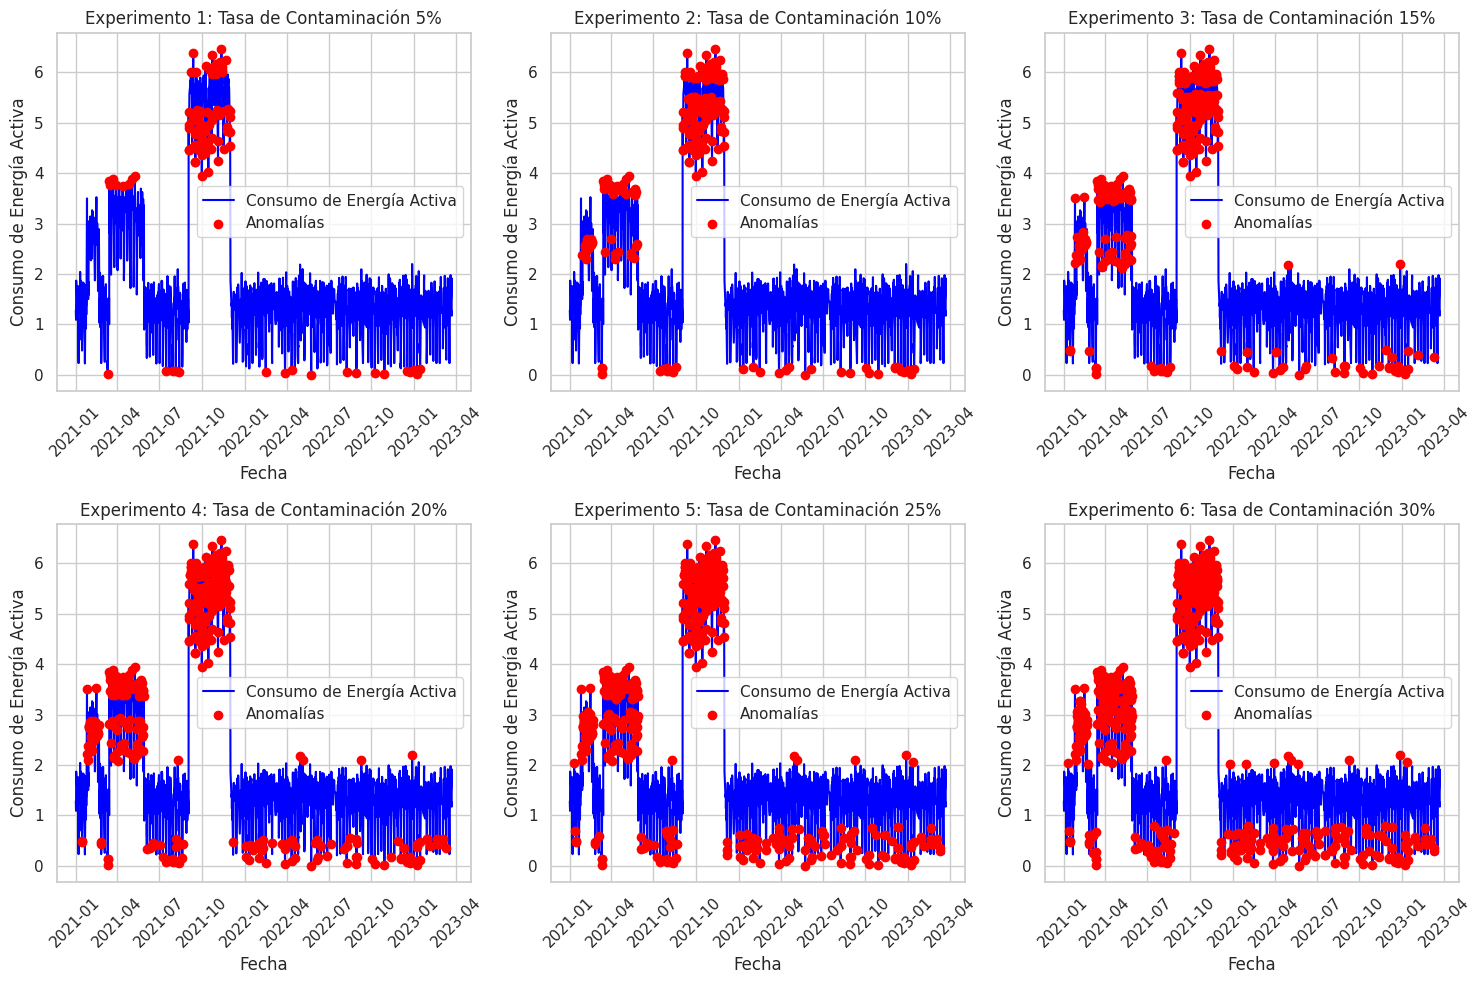

Cliente 05


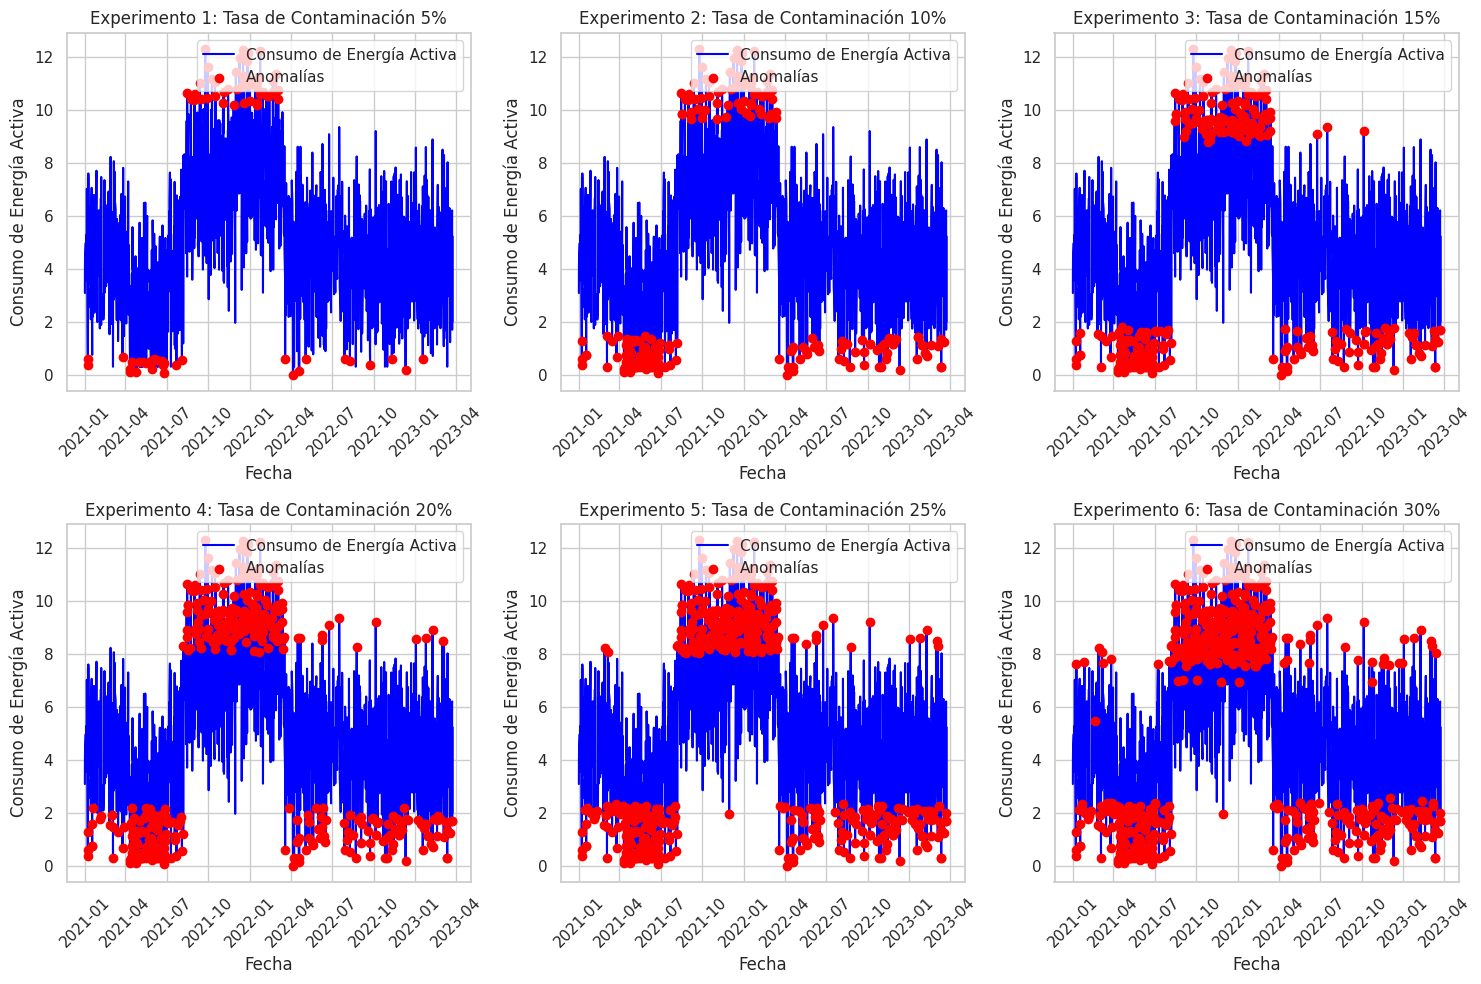

In [48]:
# Experimentos
for client in df_sample['ID_Cliente'].unique().tolist():
    print(client)
    df_client1 = df_sample[df_sample['ID_Cliente'] == client]
    experiments = run_experiments(df_client1, 'Active_energy')
    experiments = pd.DataFrame(experiments)
    print(experiments)

0.23046593910936475
0.23046593910936475
0.23046593910936475
0.23046593910936475
0.23046593910936475
0.23046593910936475


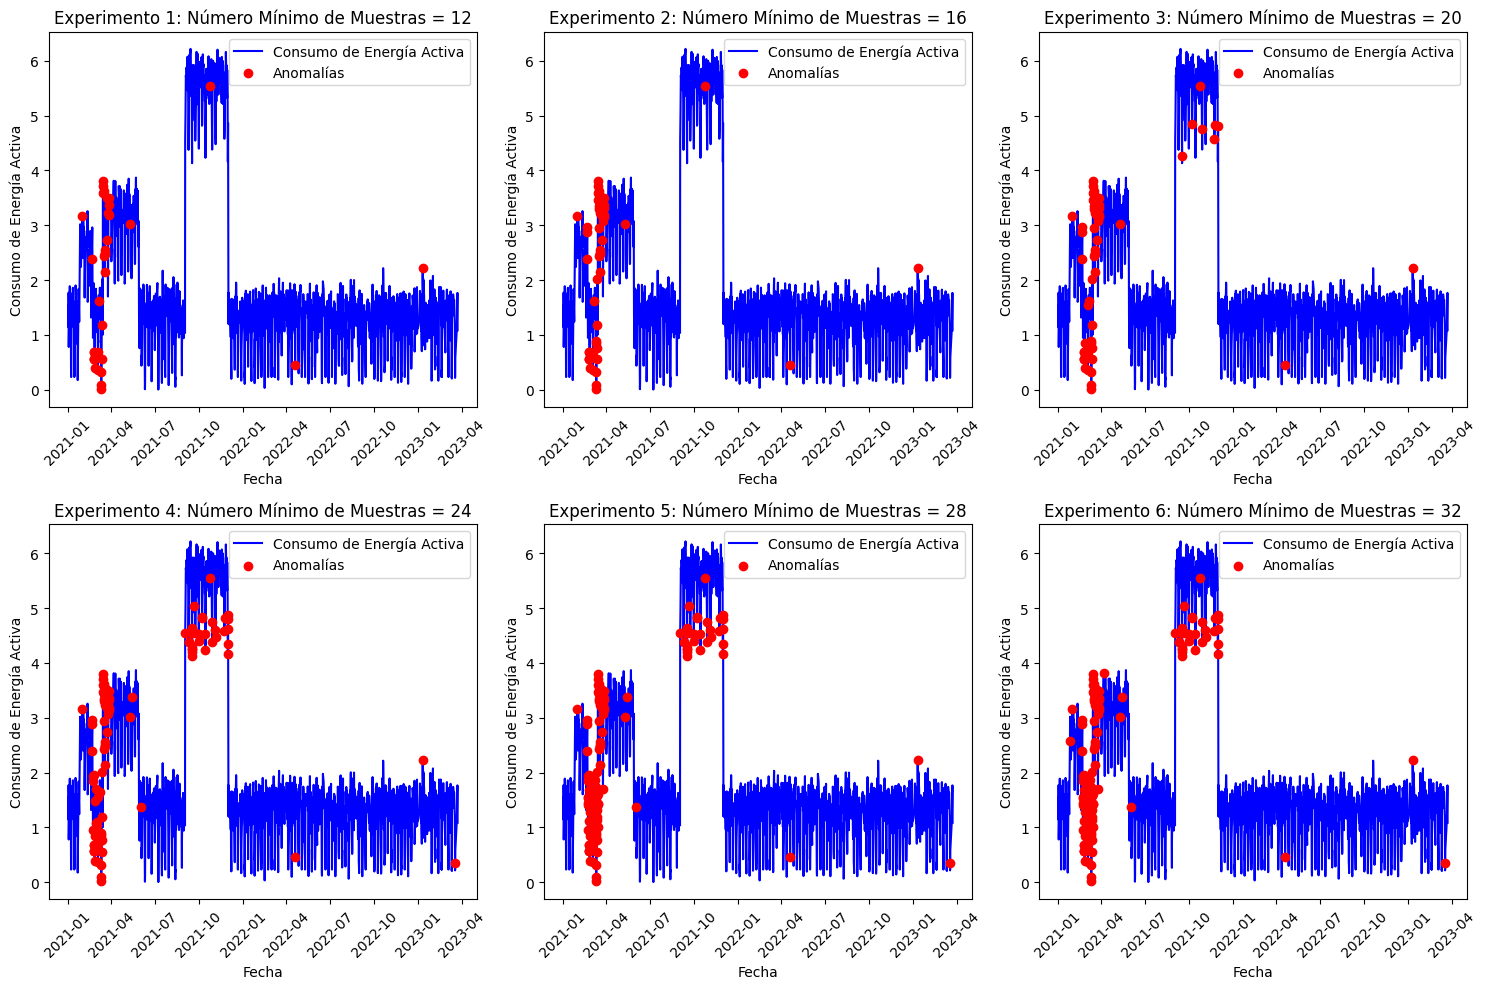

Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    36       1.86%
1            2                         16                    55       2.85%
2            3                         20                    63       3.26%
3            4                         24                    99       5.12%
4            5                         28                   140       7.25%
5            6                         32                   142       7.35%

In [12]:
def elbow_method(distances, curve='convex', direction='increasing', interp_method='polynomial'):
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve=curve, direction=direction, interp_method=interp_method)
    return knee.knee

def distance_elements(embeddings, min_samples, **kwards):
    neighbors = NearestNeighbors(n_neighbors=min_samples, **kwards)
    neighbors_fit = neighbors.fit(embeddings)
    return neighbors_fit.kneighbors(embeddings)

def calculate_eps(embeddings, min_samples, delta):
    distances, _ = distance_elements(embeddings, min_samples, metric='euclidean')
    distances = np.sort(distances.flatten())
    elbow = elbow_method(distances, curve='convex', direction='increasing', interp_method='polynomial')
    return distances[elbow] + delta

def dbscan_anomalies(df, min_samples = 24):
    # Normalizar los datos
    X = df[['Active_energy', 'Voltaje_FA']]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    eps_optimal = calculate_eps(X_scaled, min_samples=24, delta = 0.1)
    print(eps_optimal)
    dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)
    df['Anomalies_DBSCAN'] = np.where(clusters == -1, 1, 0)
    return df

def run_experiments(df, col):
    results = []
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for i in range(6):
        min_samples = 12 + i * 4  # Incrementa el número mínimo de muestras para cada experimento
        df_experiment = df.copy()
        df_experiment = dbscan_anomalies(df_experiment, min_samples=min_samples)
        anomalies_detected = df_experiment['Anomalies_DBSCAN'].sum()
        total_samples = len(df_experiment)
        percentage_anomalies = (anomalies_detected / total_samples) * 100
        results.append({
            'Experimento': i + 1,
            'Número Mínimo de Muestras': min_samples,
            'Anomalías Detectadas': anomalies_detected,
            '% Anomalías': f"{percentage_anomalies:.2f}%"
        })
        # Gráfico correspondiente al experimento actual
        ax_row = i // 3  # Fila en la rejilla
        ax_col = i % 3   # Columna en la rejilla
        ax = axes[ax_row, ax_col]
        df_experiment['Fecha'] = pd.to_datetime(df_experiment['Fecha'])
        df_sorted = df_experiment.sort_values('Fecha')  # Ordenar el DataFrame por la columna 'Fecha'
        ax.plot(df_sorted['Fecha'], df_sorted['Active_energy'], color='blue', label='Consumo de Energía Activa')
        anomalies = df_sorted[df_sorted['Anomalies_DBSCAN'] == 1]  # Filtrar anomalías
        ax.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='red', label='Anomalías', zorder=5)
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Consumo de Energía Activa')
        ax.set_title(f'Experimento {i + 1}: Número Mínimo de Muestras = {min_samples}')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x

    plt.tight_layout()
    plt.show()

    return results

experiments = run_experiments(df_client1, 'Active_energy')
experiments = pd.DataFrame(experiments)
experiments

Cliente 05
0.29457295144843654
0.29457295144843654
0.29457295144843654
0.29457295144843654
0.29457295144843654
0.29457295144843654


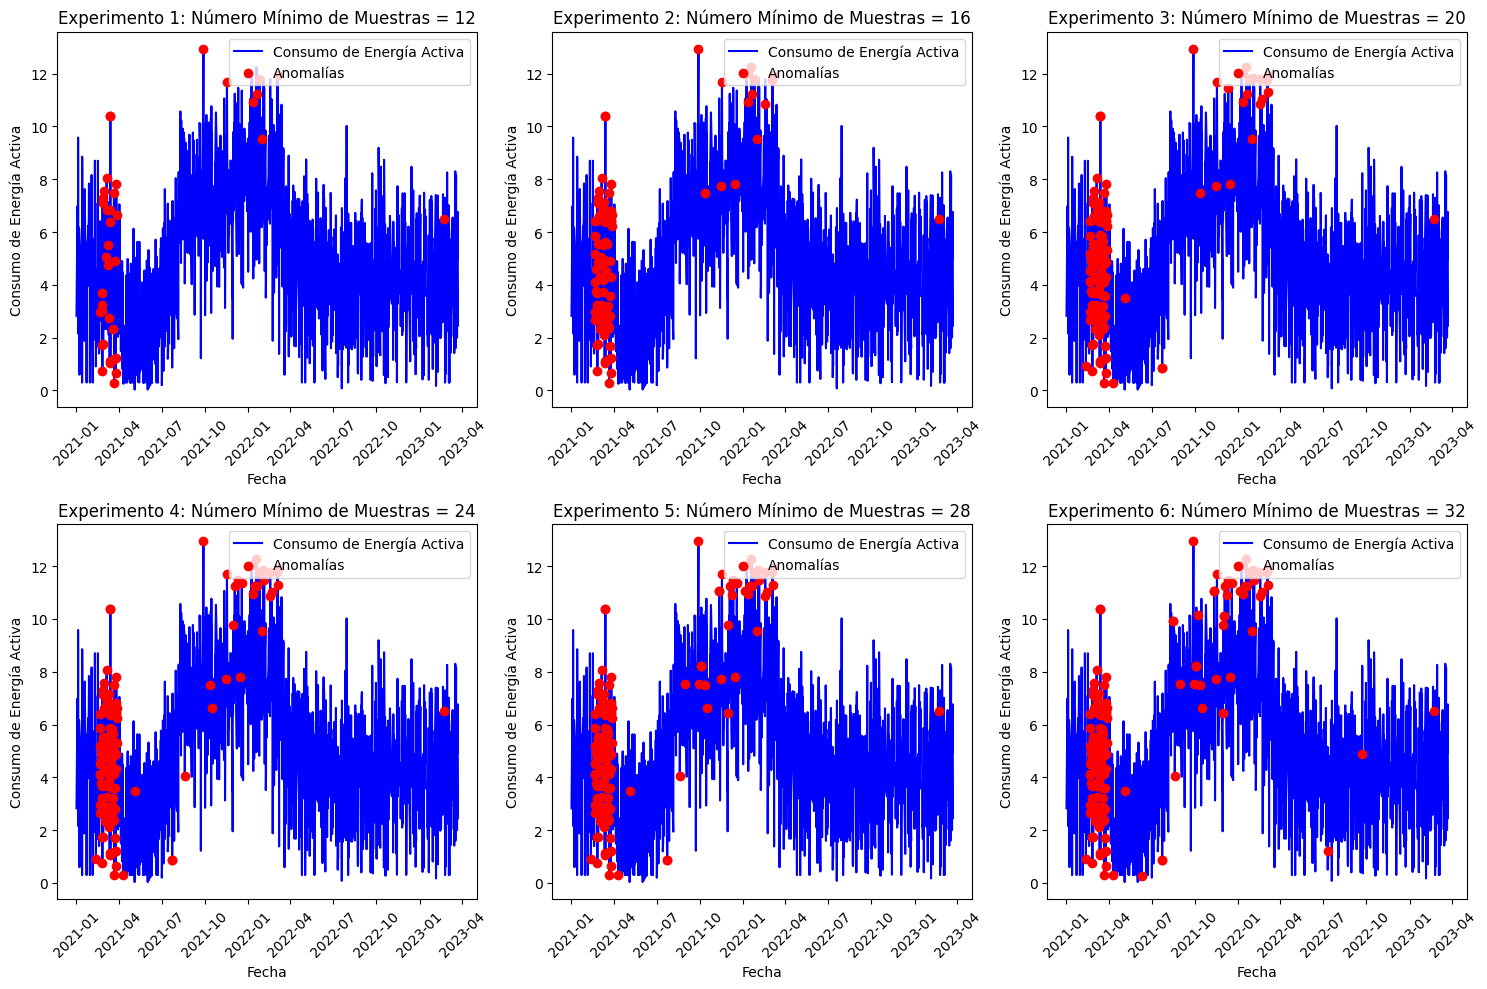

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    39       1.95%
1            2                         16                    90       4.50%
2            3                         20                   129       6.44%
3            4                         24                   137       6.84%
4            5                         28                   146       7.29%
5            6                         32                   154       7.69%
Cliente 09
0.24895699458855028
0.24895699458855028
0.24895699458855028
0.24895699458855028
0.24895699458855028
0.24895699458855028


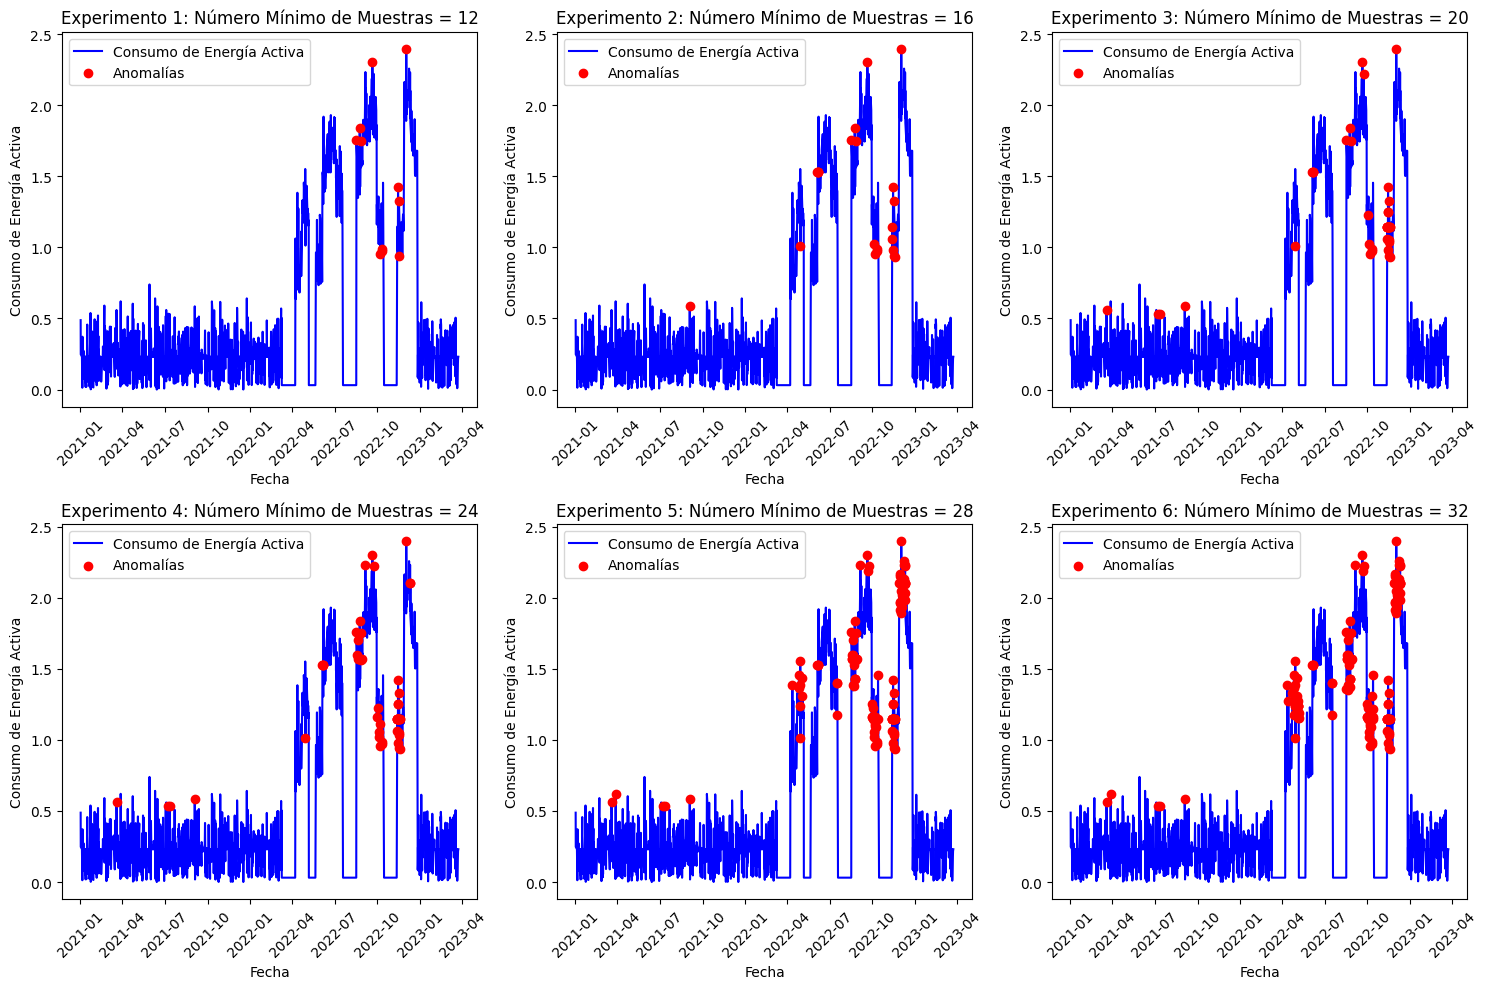

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    11       0.55%
1            2                         16                    22       1.10%
2            3                         20                    44       2.20%
3            4                         24                    57       2.85%
4            5                         28                   133       6.64%
5            6                         32                   163       8.14%
Cliente 04
0.24910028456772526
0.24910028456772526
0.24910028456772526
0.24910028456772526
0.24910028456772526
0.24910028456772526


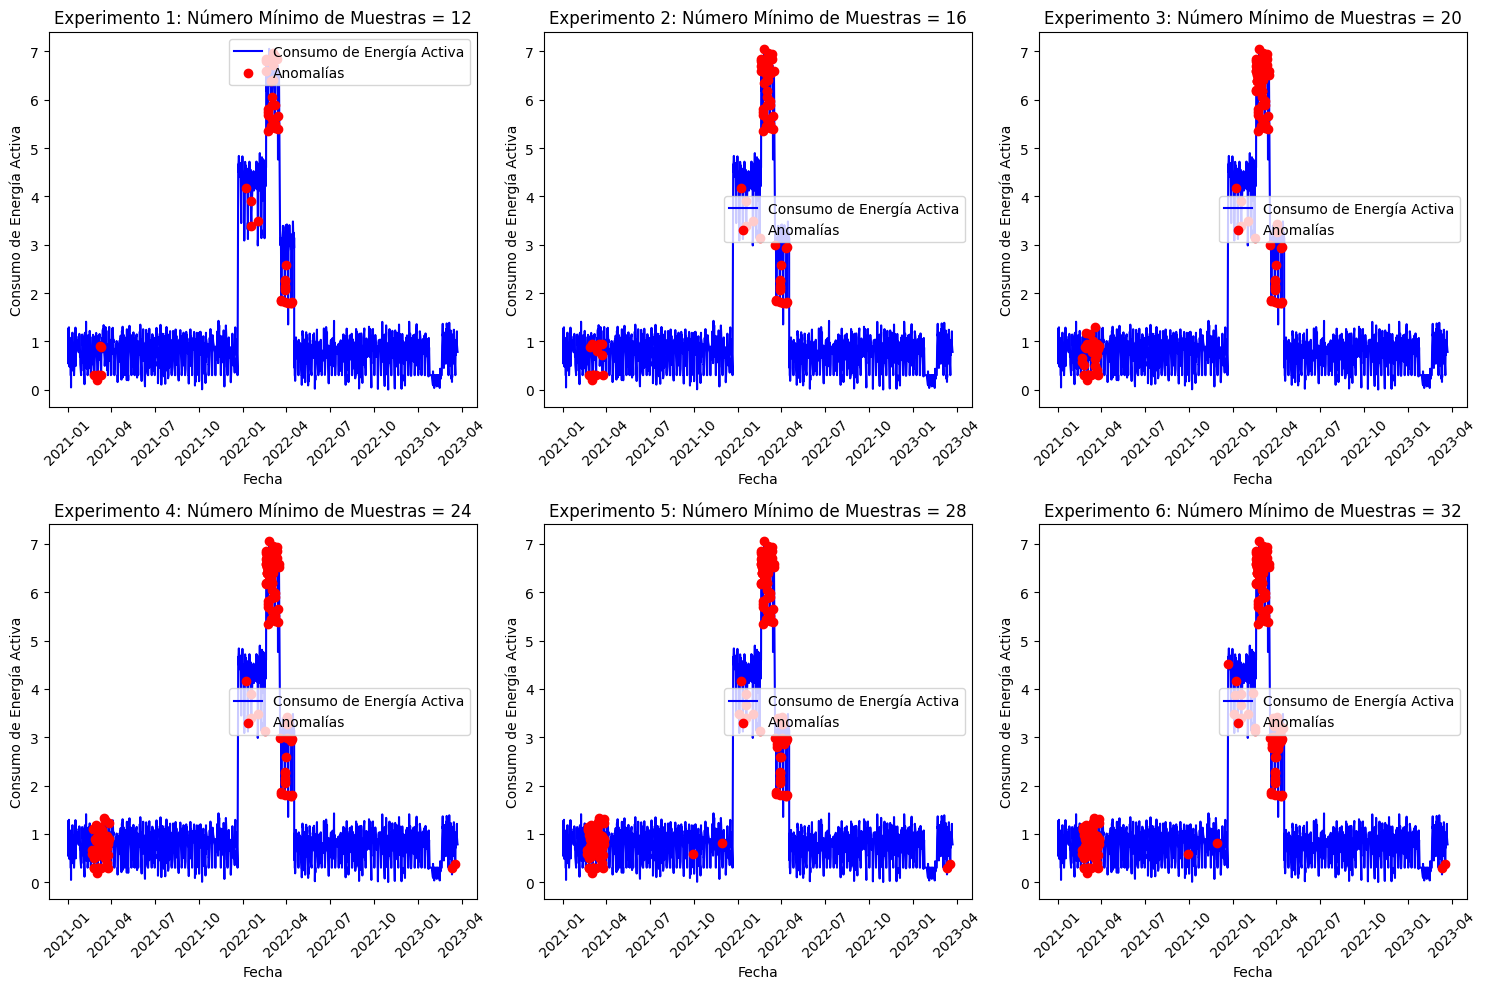

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    49       2.64%
1            2                         16                    79       4.26%
2            3                         20                   123       6.64%
3            4                         24                   143       7.72%
4            5                         28                   178       9.61%
5            6                         32                   193      10.42%
Cliente 17
0.26454327636528463
0.26454327636528463
0.26454327636528463
0.26454327636528463
0.26454327636528463
0.26454327636528463


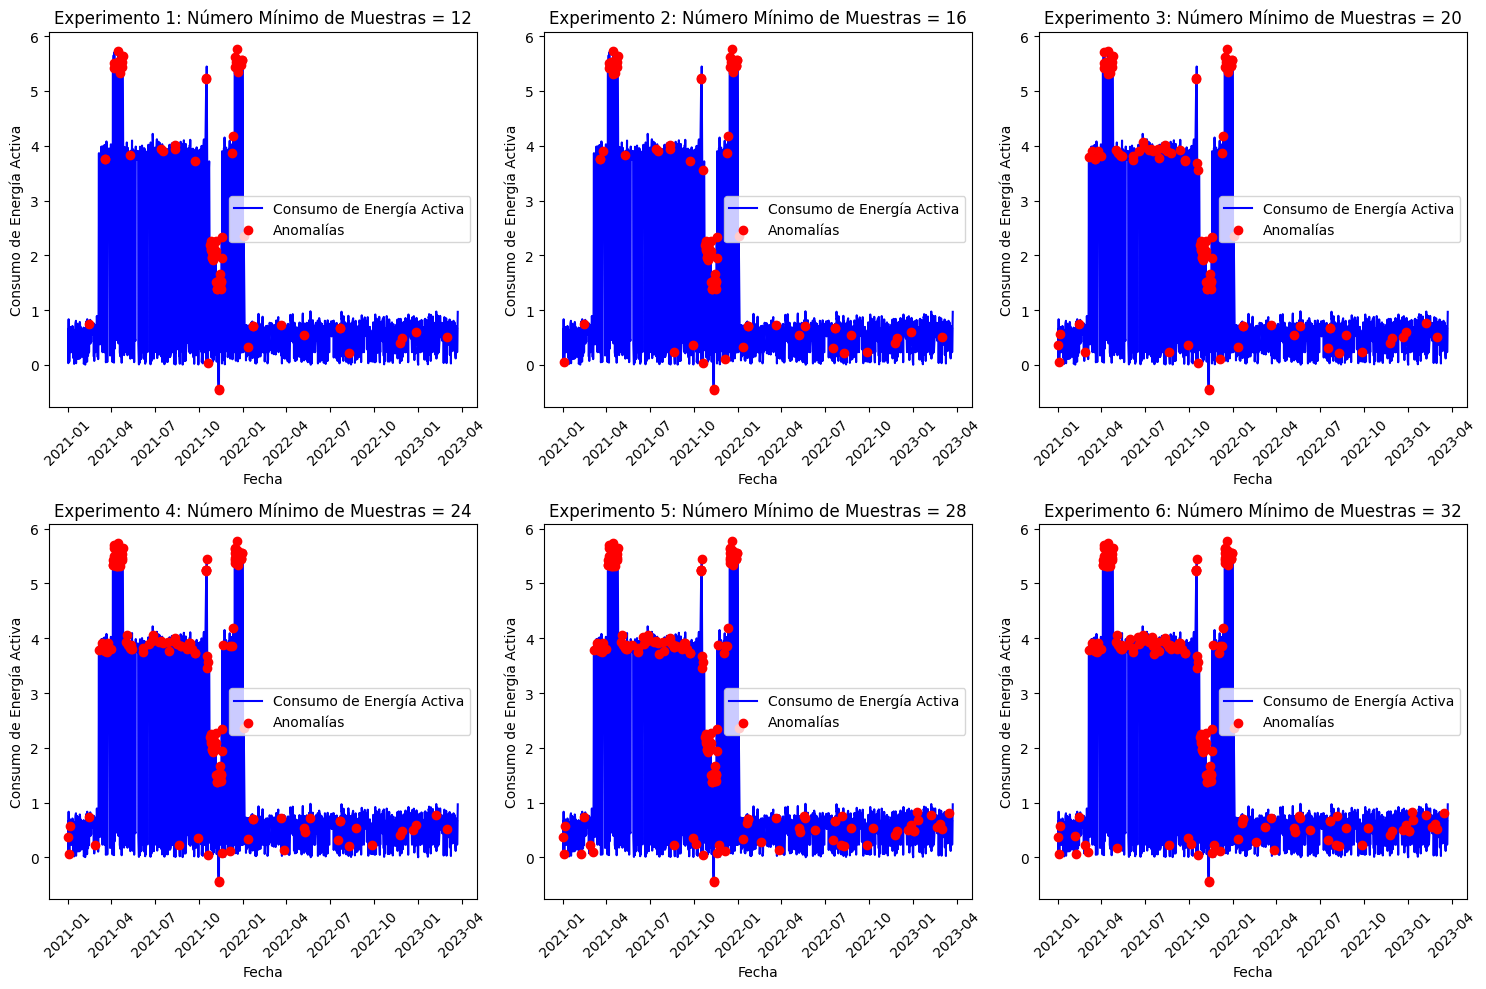

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    89       4.52%
1            2                         16                   105       5.34%
2            3                         20                   134       6.81%
3            4                         24                   173       8.80%
4            5                         28                   198      10.07%
5            6                         32                   206      10.47%
Cliente 19
0.29115228409309135
0.29115228409309135
0.29115228409309135
0.29115228409309135
0.29115228409309135
0.29115228409309135


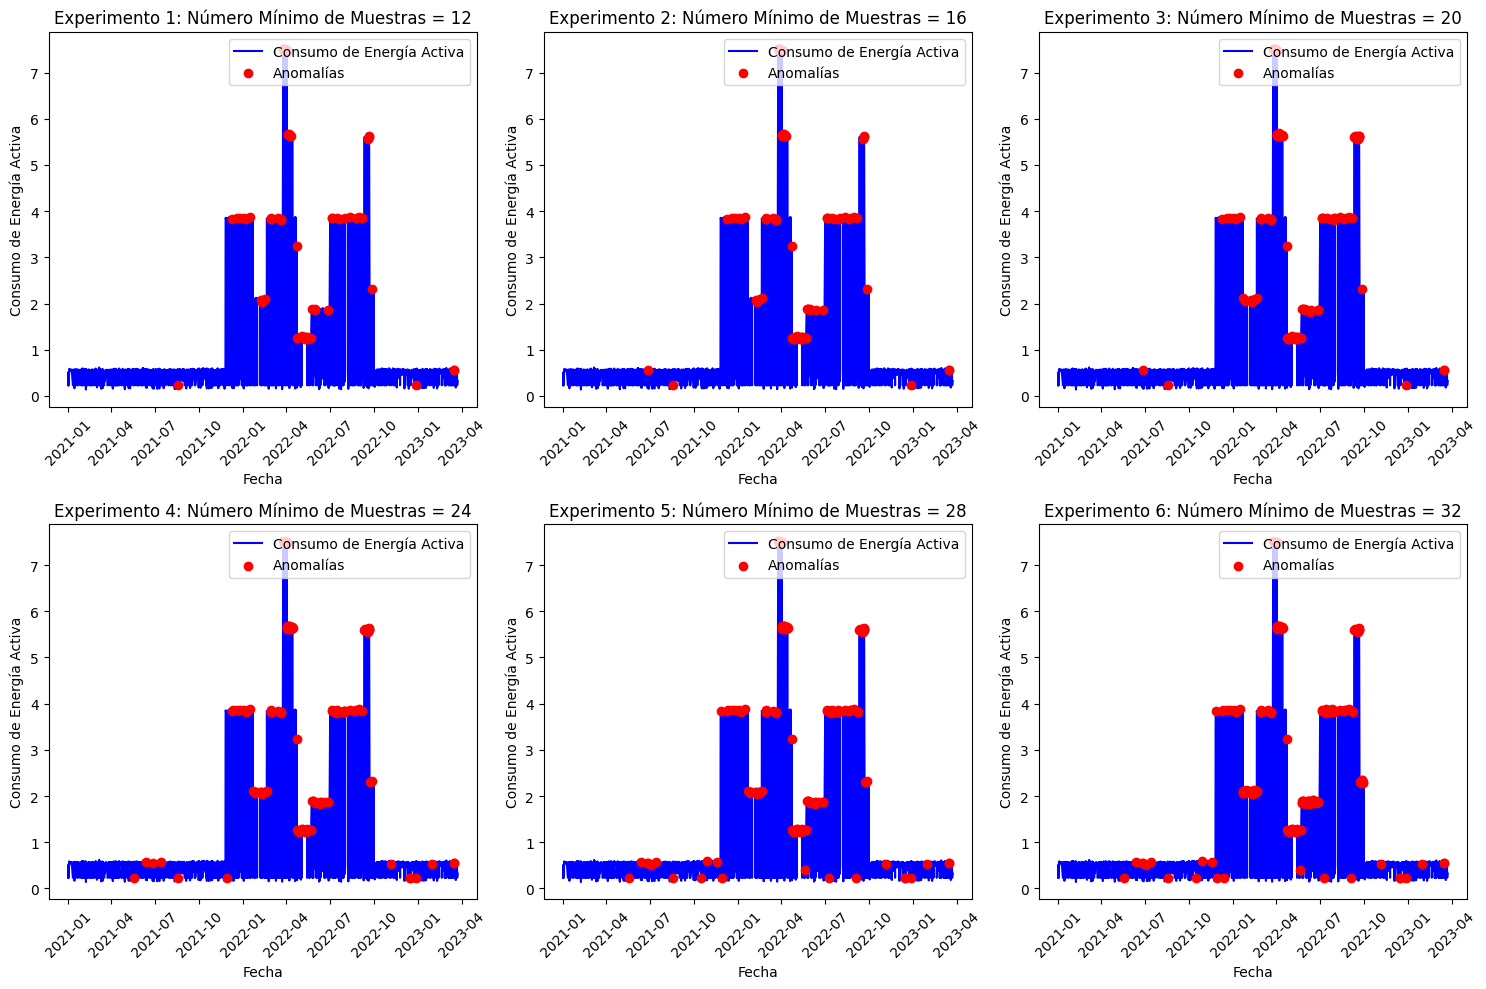

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    74       3.89%
1            2                         16                    97       5.10%
2            3                         20                   133       6.99%
3            4                         24                   154       8.09%
4            5                         28                   174       9.14%
5            6                         32                   248      13.03%
Cliente 20
0.26765929879971906
0.26765929879971906
0.26765929879971906
0.26765929879971906
0.26765929879971906
0.26765929879971906


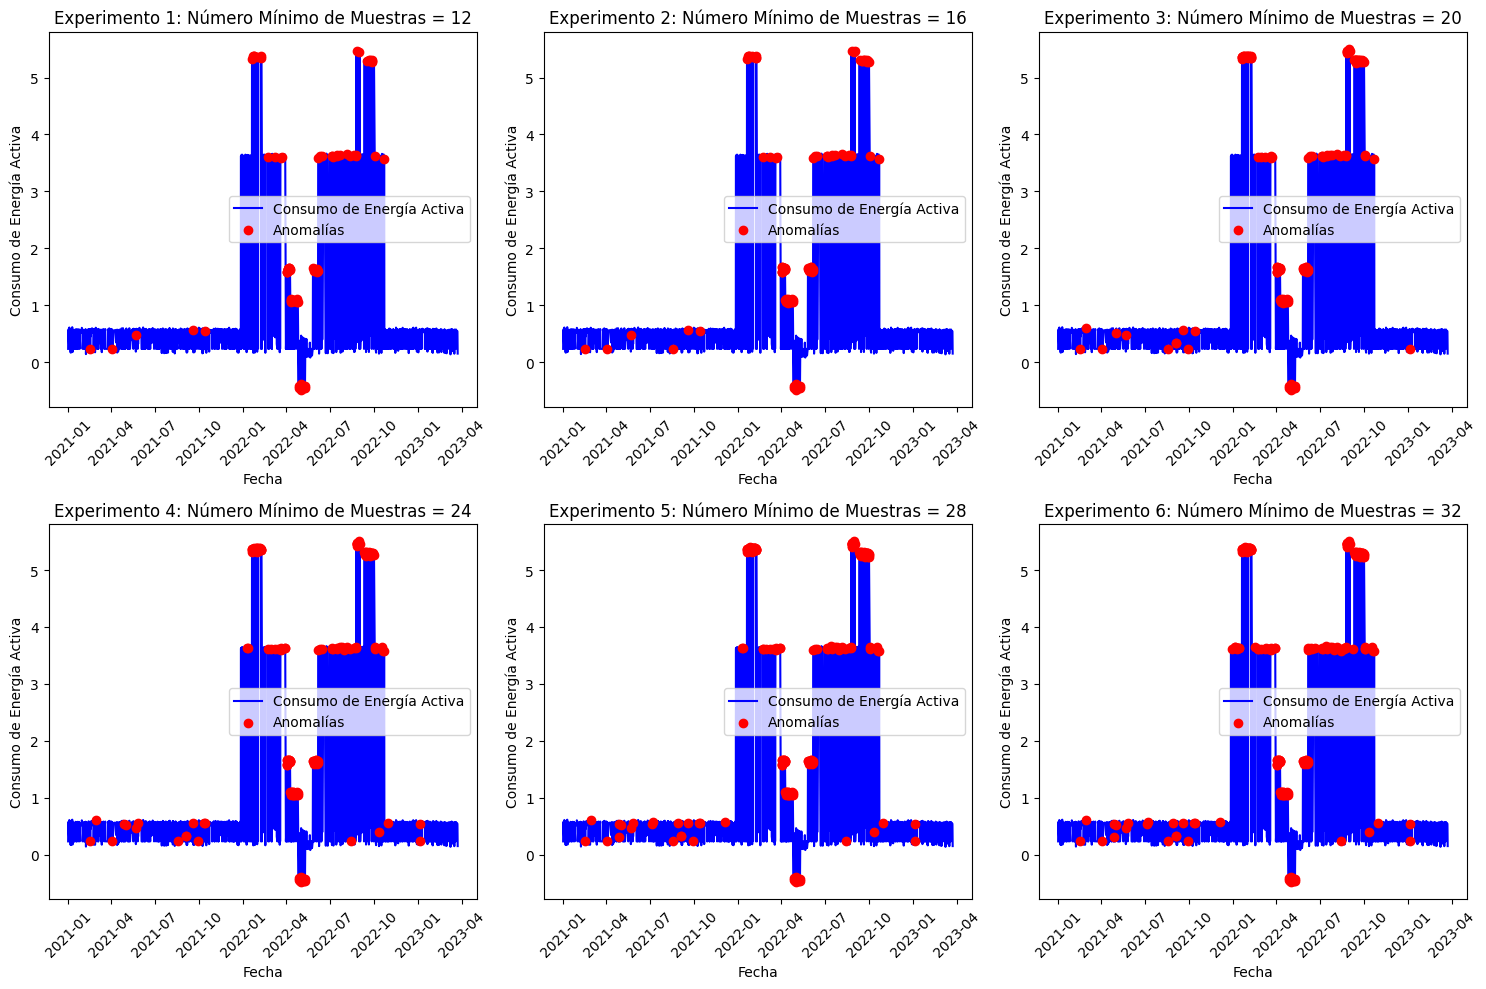

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    98       4.98%
1            2                         16                   133       6.76%
2            3                         20                   169       8.59%
3            4                         24                   195       9.91%
4            5                         28                   228      11.59%
5            6                         32                   247      12.56%
Cliente 06
0.25485746783307606
0.25485746783307606
0.25485746783307606
0.25485746783307606
0.25485746783307606
0.25485746783307606


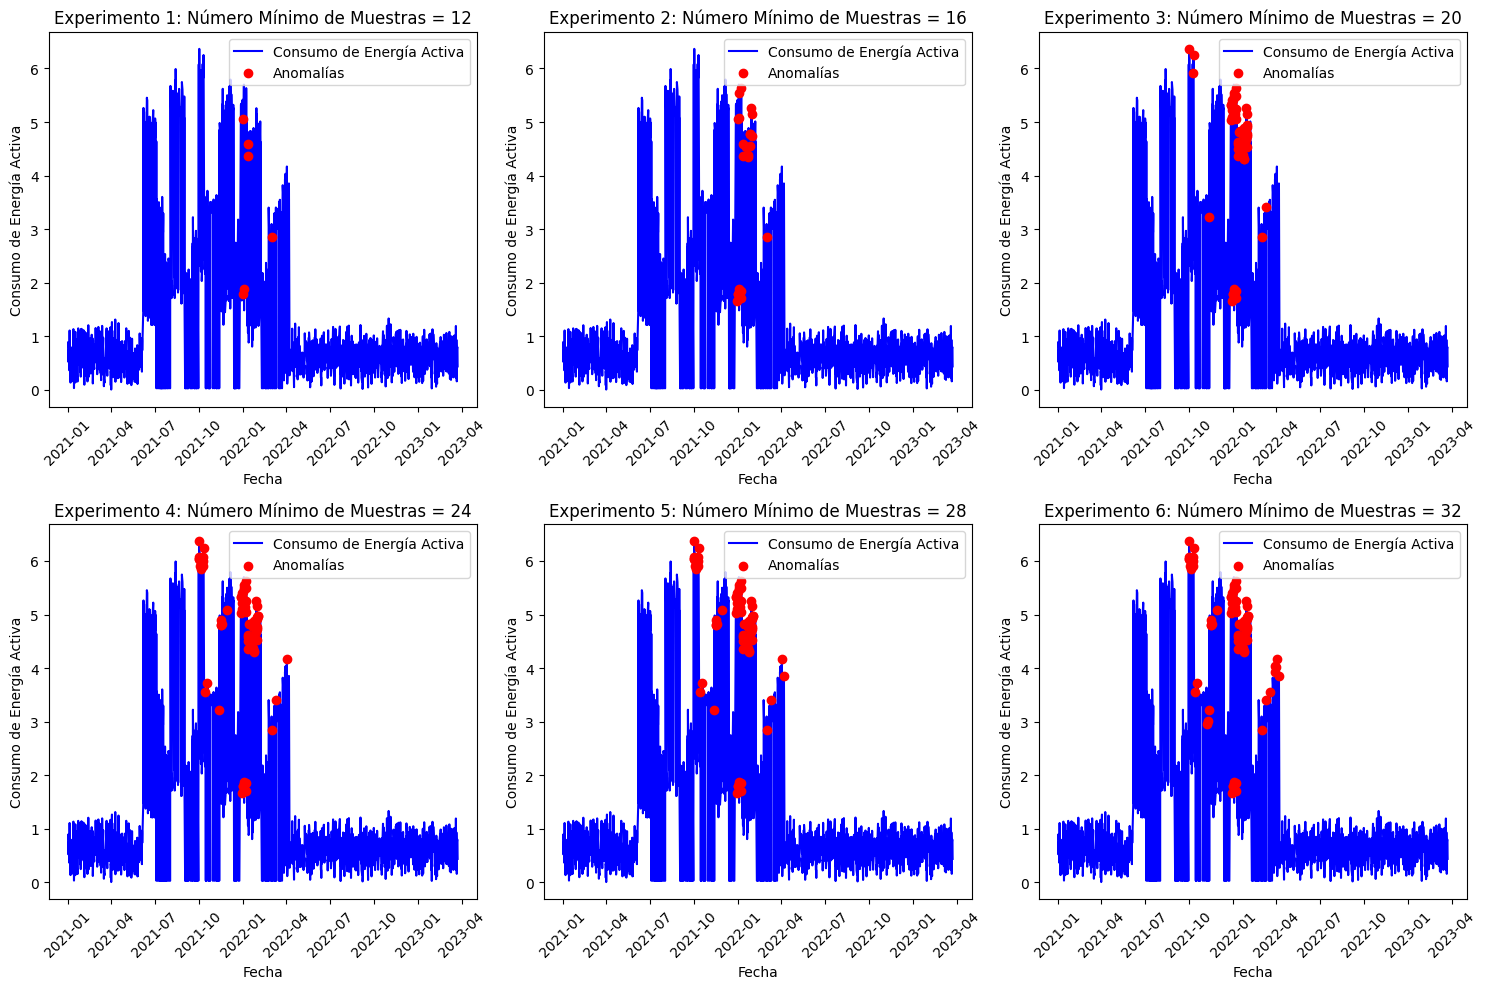

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                     6       0.32%
1            2                         16                    23       1.22%
2            3                         20                    64       3.39%
3            4                         24                    82       4.35%
4            5                         28                    83       4.40%
5            6                         32                    89       4.72%
Cliente 02
0.3437111347626657
0.3437111347626657
0.3437111347626657
0.3437111347626657
0.3437111347626657
0.3437111347626657


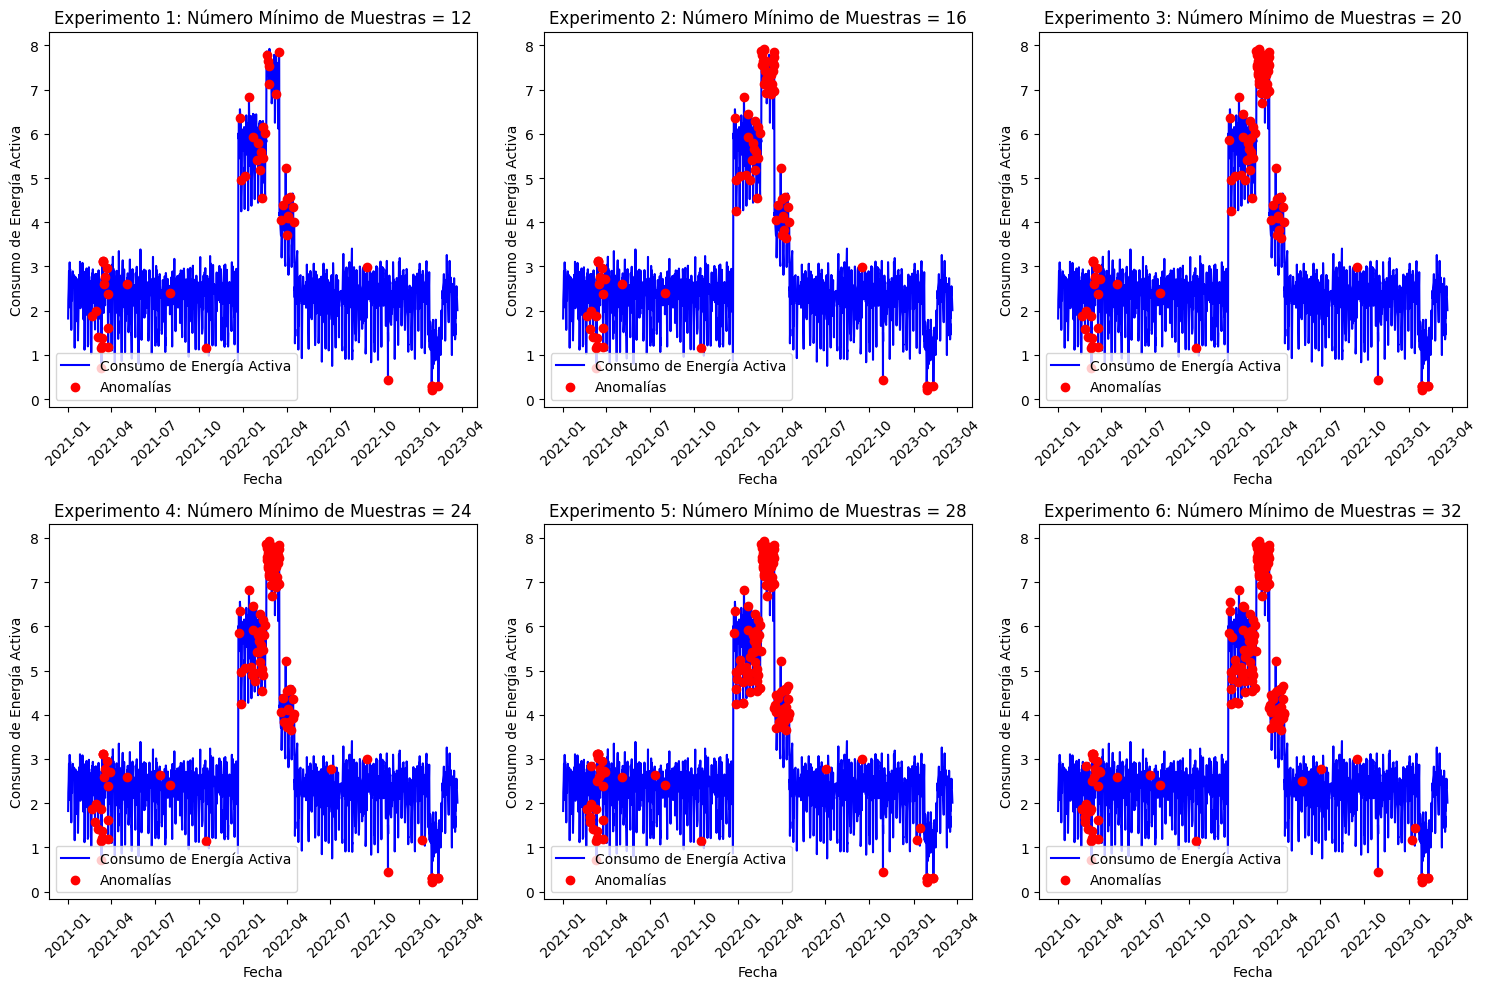

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    55       2.86%
1            2                         16                    84       4.37%
2            3                         20                   107       5.57%
3            4                         24                   117       6.09%
4            5                         28                   156       8.12%
5            6                         32                   173       9.01%
Cliente 08
0.3165090507521944
0.3165090507521944
0.3165090507521944
0.3165090507521944
0.3165090507521944
0.3165090507521944


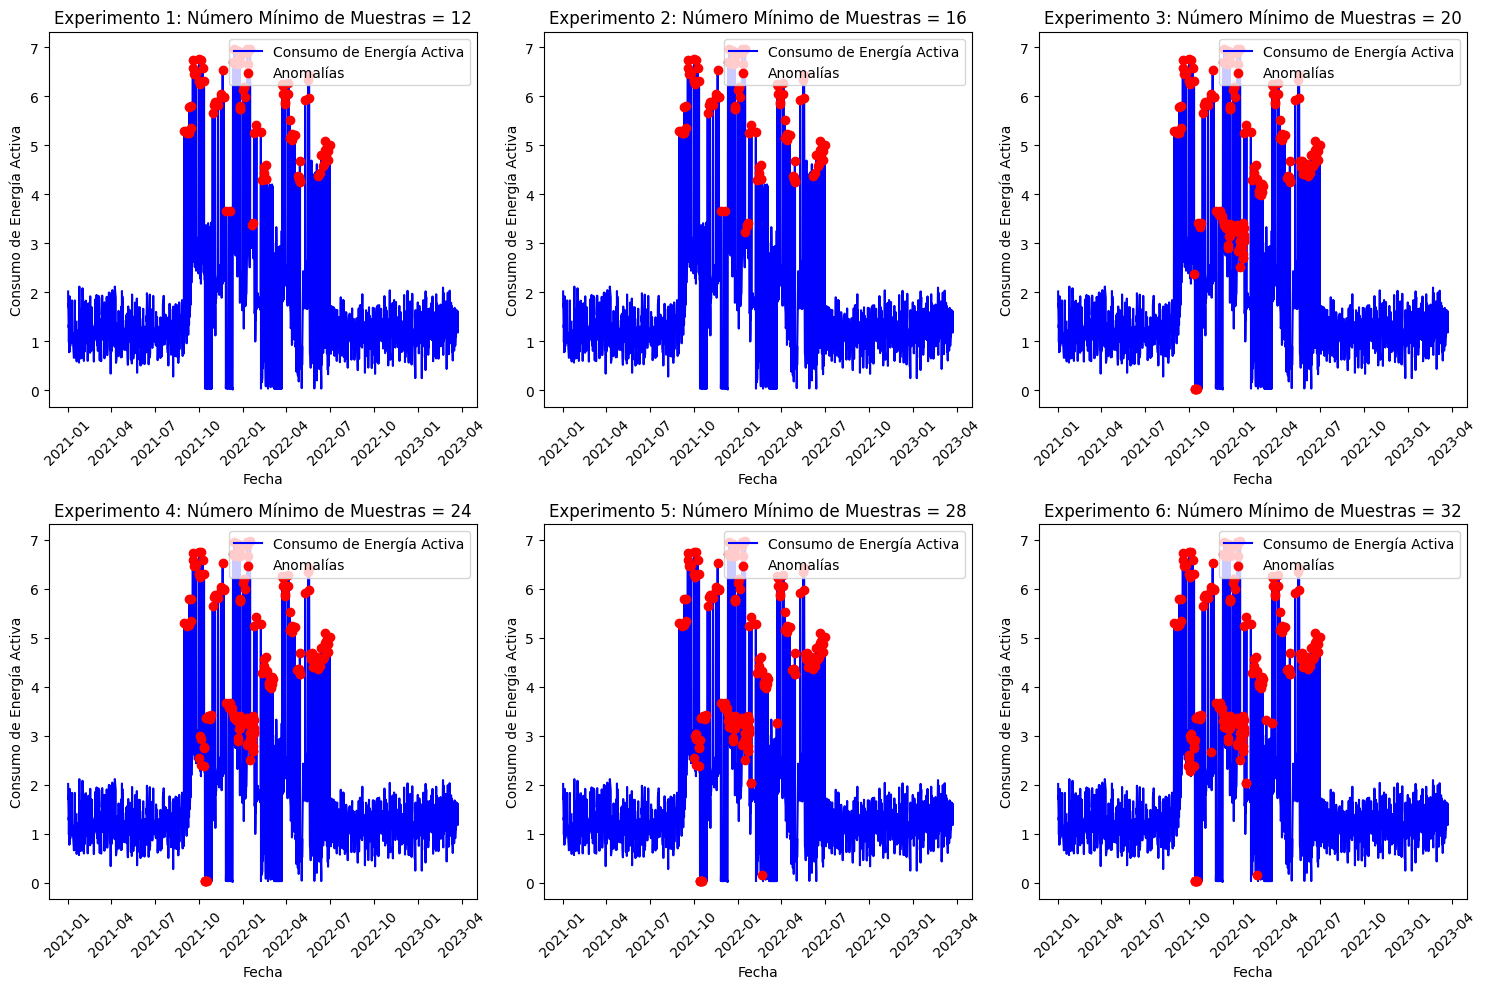

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                   104       5.34%
1            2                         16                   106       5.44%
2            3                         20                   167       8.58%
3            4                         24                   176       9.04%
4            5                         28                   188       9.66%
5            6                         32                   194       9.96%
Cliente 16
0.2604208306497809
0.2604208306497809
0.2604208306497809
0.2604208306497809
0.2604208306497809
0.2604208306497809


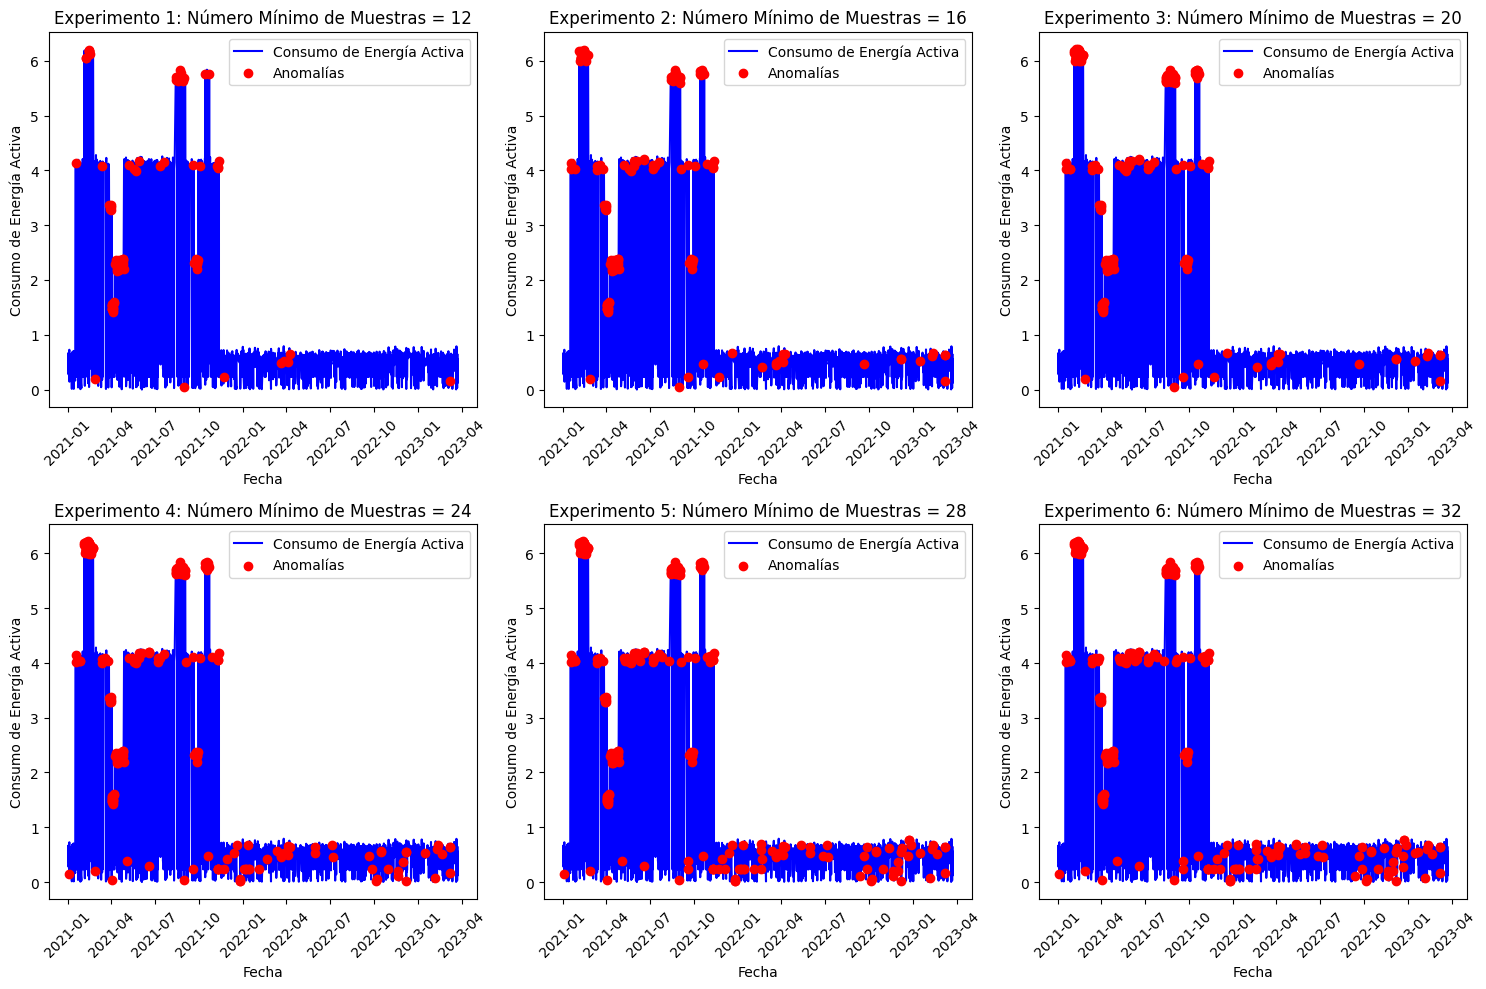

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    90       4.67%
1            2                         16                   143       7.42%
2            3                         20                   175       9.08%
3            4                         24                   212      11.00%
4            5                         28                   235      12.19%
5            6                         32                   244      12.66%
Cliente 18
0.26989672046518043
0.26989672046518043
0.26989672046518043
0.26989672046518043
0.26989672046518043
0.26989672046518043


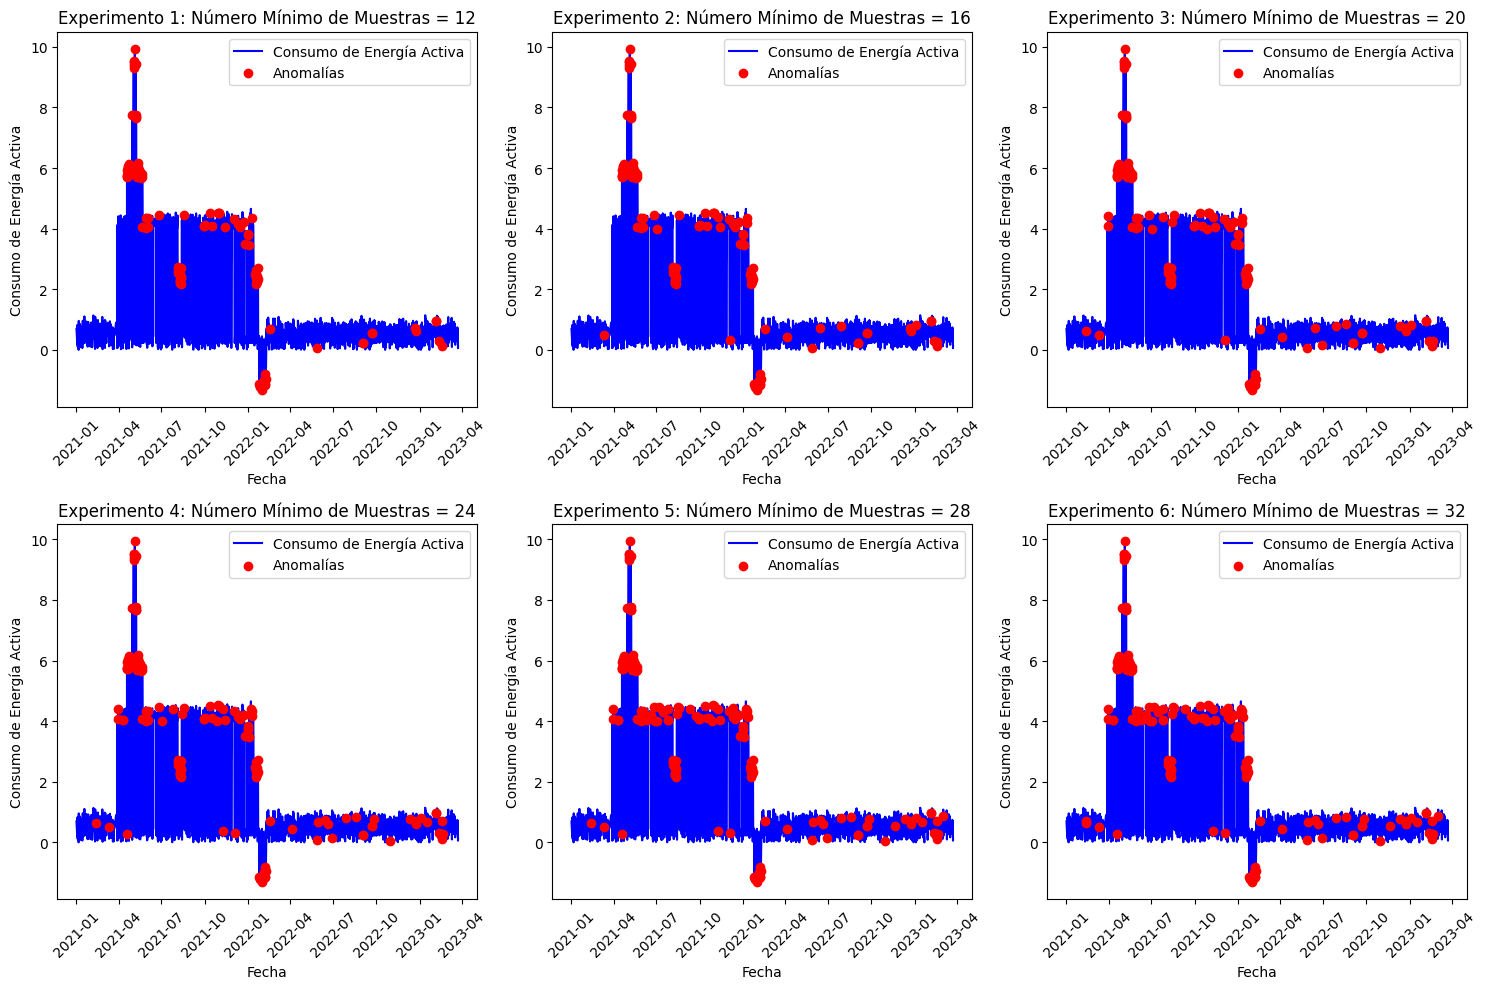

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                   129       6.39%
1            2                         16                   141       6.99%
2            3                         20                   152       7.53%
3            4                         24                   163       8.08%
4            5                         28                   179       8.87%
5            6                         32                   180       8.92%
Cliente 07
0.2953552219088327
0.2953552219088327
0.2953552219088327
0.2953552219088327
0.2953552219088327
0.2953552219088327


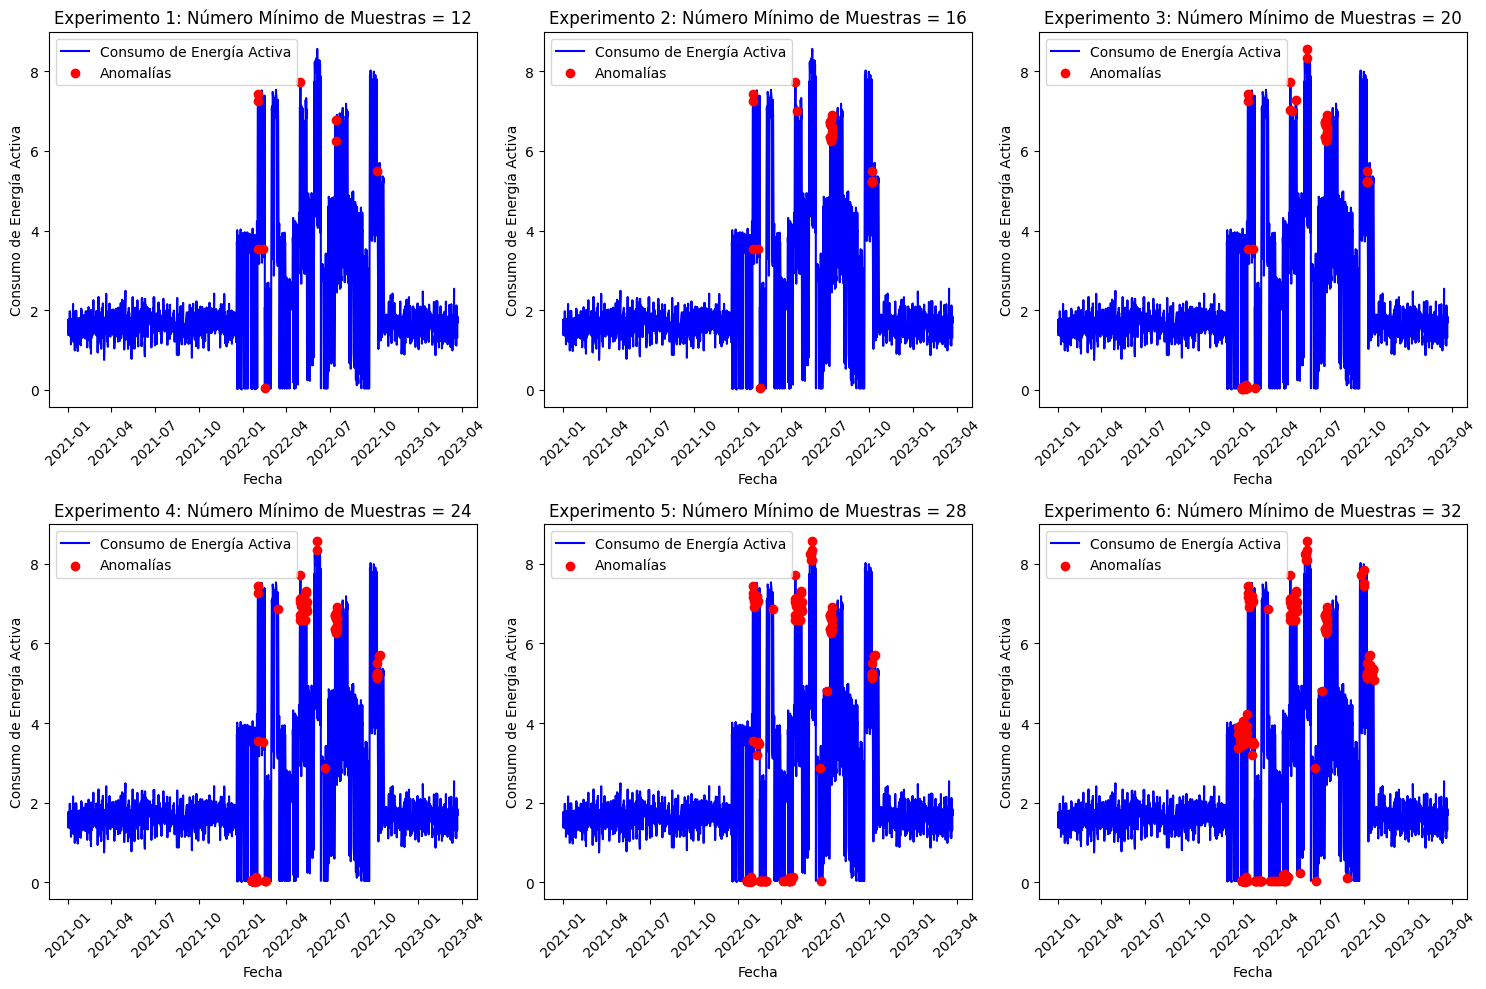

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                     9       0.47%
1            2                         16                    27       1.41%
2            3                         20                    47       2.45%
3            4                         24                    76       3.96%
4            5                         28                   109       5.67%
5            6                         32                   158       8.22%
Cliente 03
0.3368216570167969
0.3368216570167969
0.3368216570167969
0.3368216570167969
0.3368216570167969
0.3368216570167969


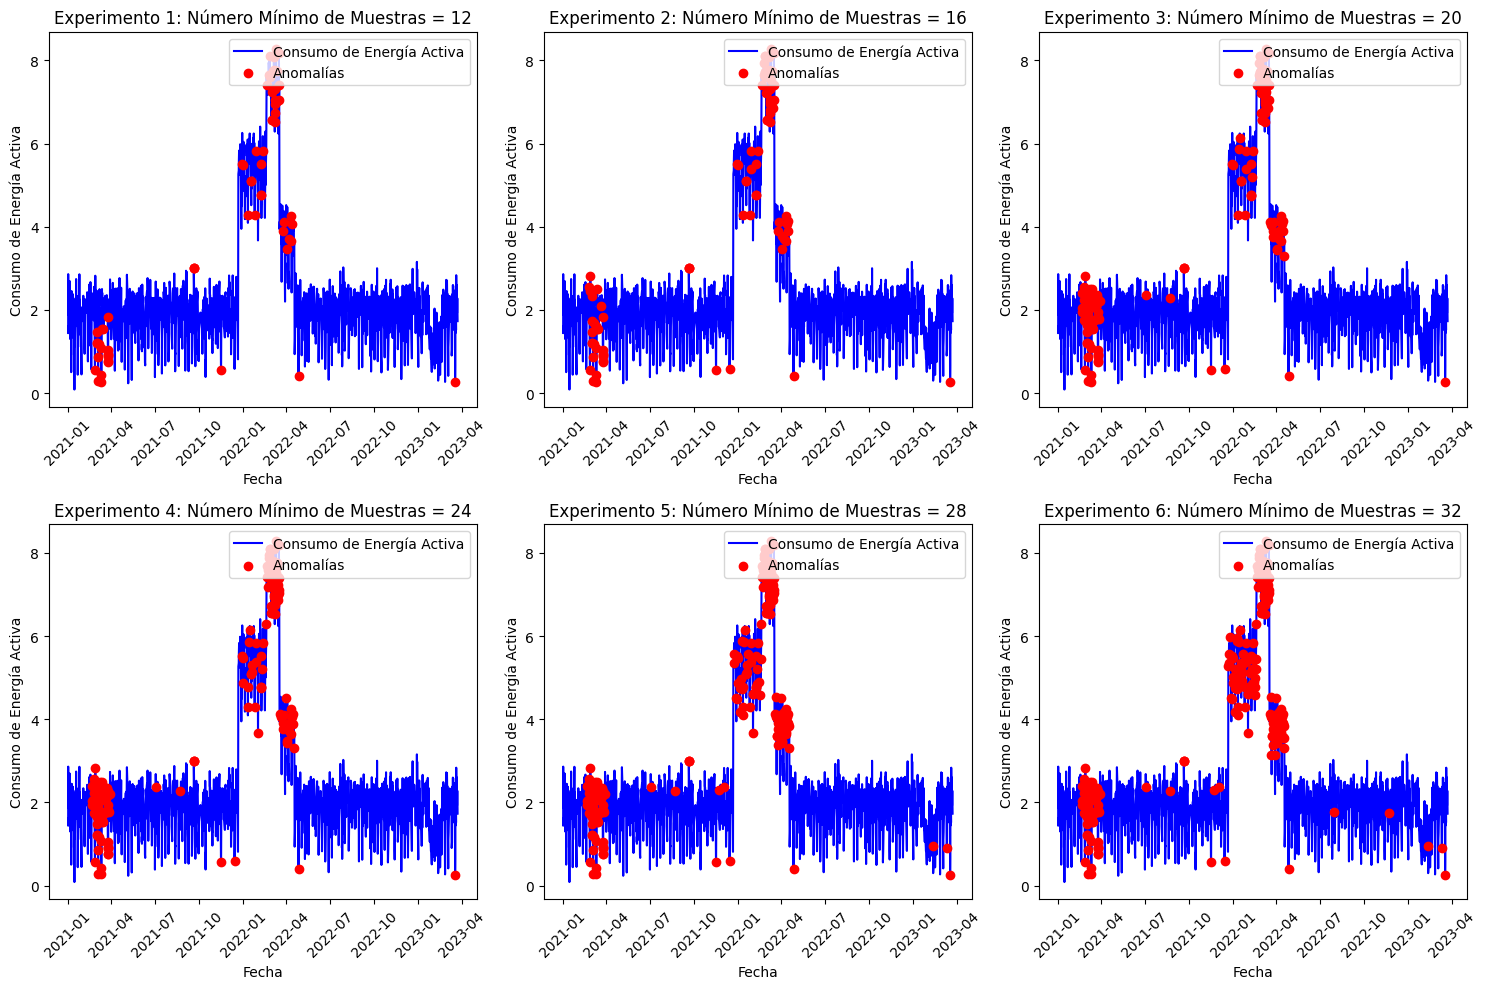

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    65       3.28%
1            2                         16                    89       4.49%
2            3                         20                   155       7.83%
3            4                         24                   191       9.65%
4            5                         28                   227      11.46%
5            6                         32                   251      12.68%
Cliente 10
0.2781708770095791
0.2781708770095791
0.2781708770095791
0.2781708770095791
0.2781708770095791
0.2781708770095791


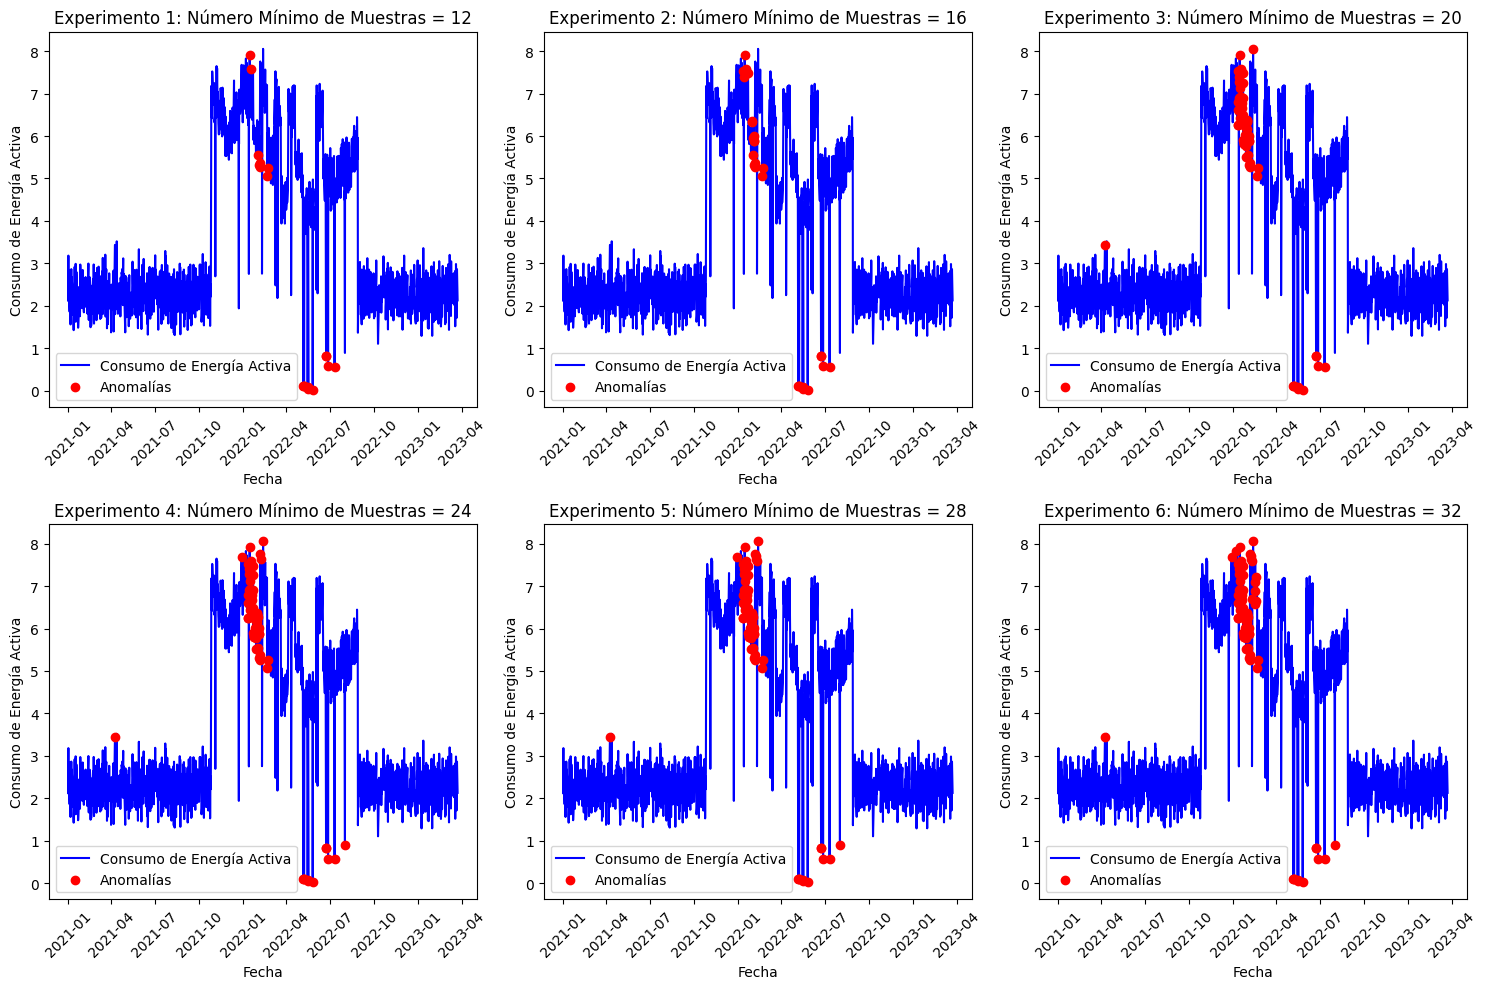

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    18       0.92%
1            2                         16                    27       1.38%
2            3                         20                    64       3.28%
3            4                         24                    69       3.53%
4            5                         28                    71       3.64%
5            6                         32                    78       4.00%
Cliente 01
0.22629611704237237
0.22629611704237237
0.22629611704237237
0.22629611704237237
0.22629611704237237
0.22629611704237237


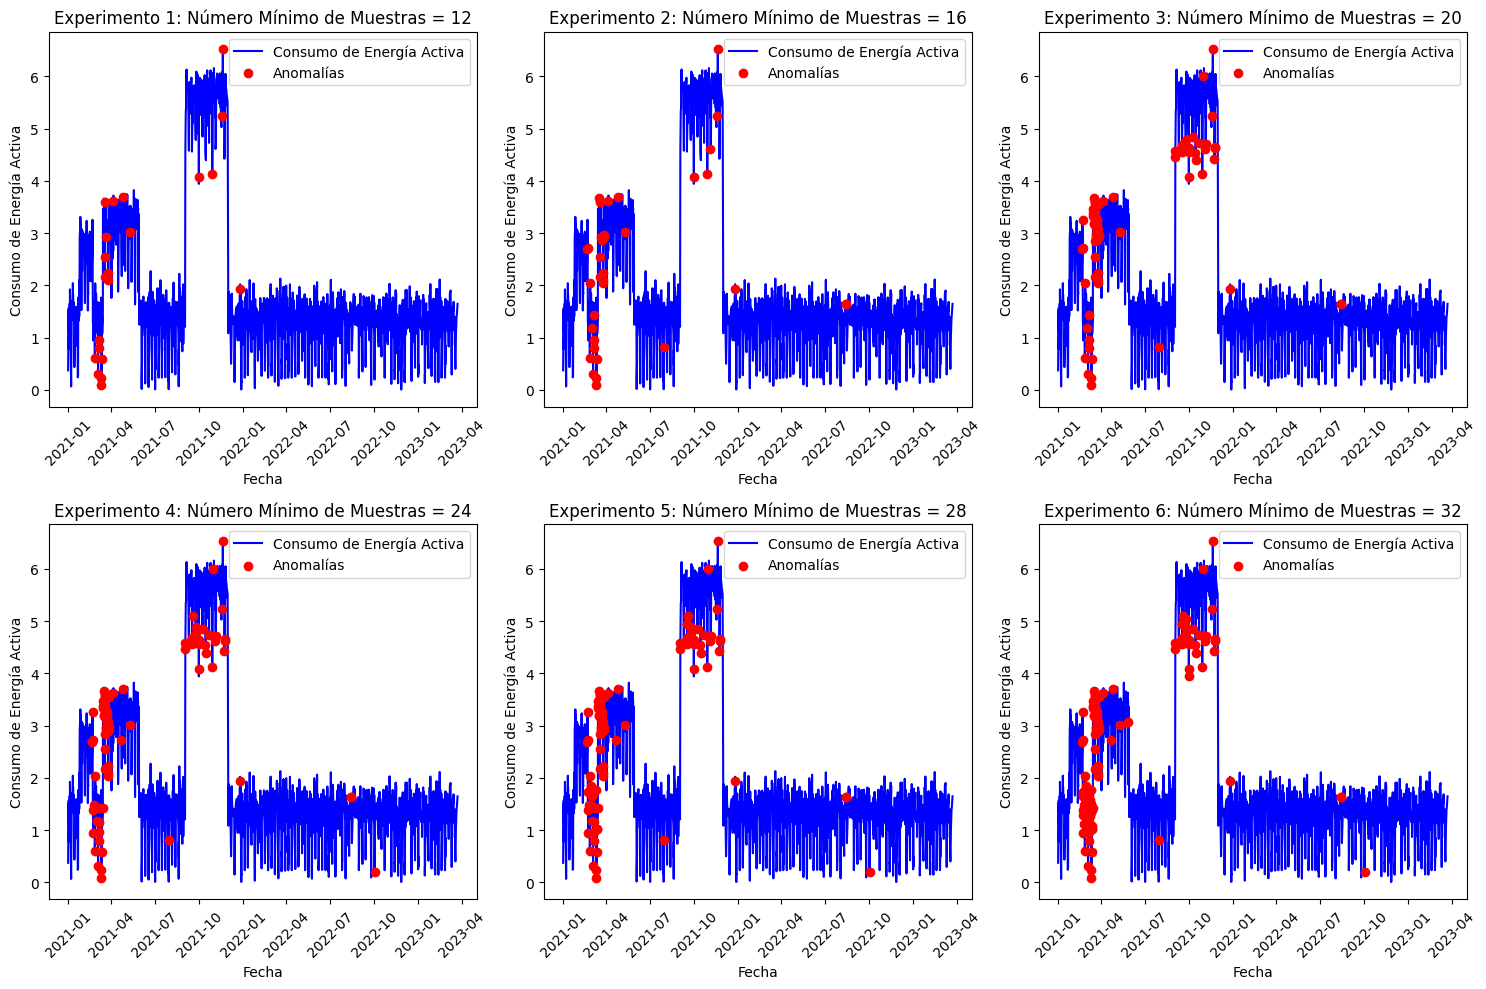

   Experimento  Número Mínimo de Muestras  Anomalías Detectadas % Anomalías
0            1                         12                    21       1.06%
1            2                         16                    35       1.76%
2            3                         20                    79       3.98%
3            4                         24                    88       4.43%
4            5                         28                   100       5.04%
5            6                         32                   135       6.80%


In [22]:
# Experimentos
for client in df_sample['ID_Cliente'].unique().tolist():
    print(client)
    df_client1 = df_sample[df_sample['ID_Cliente'] == client]
    experiments = run_experiments(df_client1, 'Active_energy')
    experiments = pd.DataFrame(experiments)
    print(experiments)

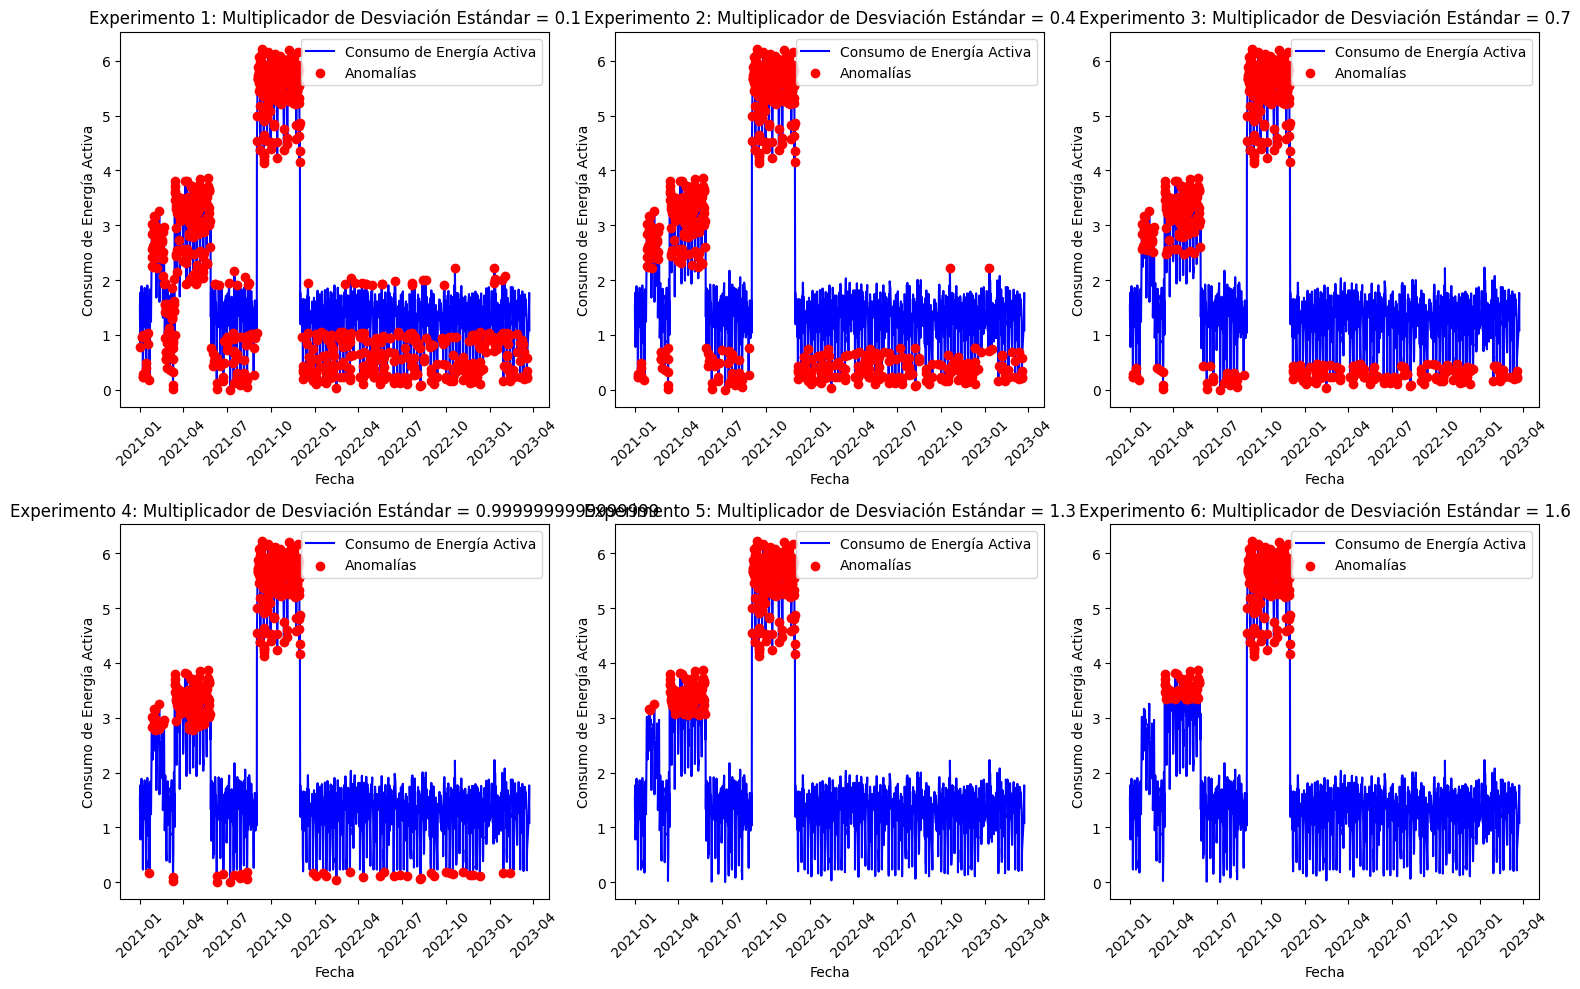

Experimento  Multiplicador de Desviación Estándar  Anomalías Detectadas  \
0            1                                   0.1                   834   
1            2                                   0.4                   635   
2            3                                   0.7                   538   
3            4                                   1.0                   383   
4            5                                   1.3                   312   
5            6                                   1.6                   265   

  % Anomalías  
0      43.17%  
1      32.87%  
2      27.85%  
3      19.82%  
4      16.15%  
5      13.72%

In [13]:
def descriptive_method(df, std_dev_multiplier = 1.5):
    X = df[['Active_energy', 'Voltaje_FA']]
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1

    std_dev = X.std()
    threshold = std_dev_multiplier * std_dev

    anomalies_iqr = ((X < (Q1 - threshold * IQR)) | (X > (Q3 + threshold * IQR))).any(axis=1)
    df['Anomalies_descriptive'] = np.where(anomalies_iqr, 1, 0)
    return df

def run_experiments(df, col):
    results = []
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for i in range(6):
        std_dev_multiplier = 0.1 + i * 0.3  # Incrementa el multiplicador de desviación estándar para cada experimento
        df_experiment = df.copy()
        df_experiment = descriptive_method(df_experiment, std_dev_multiplier=std_dev_multiplier)
        anomalies_detected = df_experiment['Anomalies_descriptive'].sum()
        total_samples = len(df_experiment)
        percentage_anomalies = (anomalies_detected / total_samples) * 100
        results.append({
            'Experimento': i + 1,
            'Multiplicador de Desviación Estándar': std_dev_multiplier,
            'Anomalías Detectadas': anomalies_detected,
            '% Anomalías': f"{percentage_anomalies:.2f}%"
        })
        # Gráfico correspondiente al experimento actual
        ax_row = i // 3  # Fila en la rejilla
        ax_col = i % 3   # Columna en la rejilla
        ax = axes[ax_row, ax_col]
        df_experiment['Fecha'] = pd.to_datetime(df_experiment['Fecha'])
        df_sorted = df_experiment.sort_values('Fecha')  # Ordenar el DataFrame por la columna 'Fecha'
        ax.plot(df_sorted['Fecha'], df_sorted['Active_energy'], color='blue', label='Consumo de Energía Activa')
        anomalies = df_sorted[df_sorted['Anomalies_descriptive'] == 1]  # Filtrar anomalías
        ax.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='red', label='Anomalías', zorder=5)
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Consumo de Energía Activa')
        ax.set_title(f'Experimento {i + 1}: Multiplicador de Desviación Estándar = {std_dev_multiplier}')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x

    plt.tight_layout()
    plt.show()

    return results

experiments = run_experiments(df_client1, 'Active_energy')
experiments = pd.DataFrame(experiments)
experiments

In [14]:
def detect_single_timeseries(df, sensitivity_score, max_fraction_anomalies):
    
    # Weights is here as a future-proofing measure.
    weights = { "time_series": 1.0 }

    # Ensure that everything is sorted by dt
    df = df.sort_values("Fecha", axis=0, ascending=True)
    
    num_data_points = df['Active_energy'].count()
    if (num_data_points < 15):
        return (df.assign(is_anomaly=False, anomaly_score=0.0), weights, f"Must have a minimum of at least fifteen data points for anomaly detection.  You sent {num_data_points}.")
    elif (max_fraction_anomalies <= 0.0 or max_fraction_anomalies > 1.0):
        return (df.assign(is_anomaly=False, anomaly_score=0.0), weights, "Must have a valid max fraction of anomalies, 0 < x <= 1.0.")
    elif (sensitivity_score <= 0 or sensitivity_score > 100 ):
        return (df.assign(is_anomaly=False, anomaly_score=0.0), weights, "Must have a valid sensitivity score, 0 < x <= 100.")
    else:
        (df_tested, tests_run, diagnostics) = run_tests(df)
        (df_out, diag_outliers) = determine_outliers(df_tested, tests_run, diagnostics["num_iterations"], sensitivity_score, max_fraction_anomalies)
        
        return (df_out, weights, { "message": "Result of single time series statistical tests.", "Tests run": tests_run, "Test diagnostics": diagnostics, "Outlier determination": diag_outliers})

def run_tests(df):
    tests_run = {
        "changepoint": 1
    }

    num_records = df['key'].shape[0]
    diagnostics = {
        "Number of records": num_records
    }
    signal = df['Active_energy'].to_numpy()

    # Not knowing the shape of the data, we will try each of the three kernels.
    # We will also try a variety of penalty values across 7 orders of magnitude.
    # The combination of results will allow us to develop a sensitivity score.
    kernels = { "linear", "rbf", "cosine" }
    penalties = { 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 80, 100, 200, 500, 800, 1000 }
    diagnostics["kernels"] = kernels
    diagnostics["penalties"] = penalties
    diagnostics["num_iterations"] = len(kernels) * len(penalties)

    scores = np.zeros([num_records])
    for idx,k in enumerate(kernels):
        algo = rpt.KernelCPD(kernel=k).fit(signal)
        for idxp,p in enumerate(penalties):
            # Get the set of results and add them to the scores array
            result = algo.predict(pen=p)
            for ix,r in enumerate(result[:-1]):
                scores[r] += 1

    df["anomaly_score"] = scores
    return (df, tests_run, diagnostics)

def determine_outliers(
    df,
    tests_run,
    num_iterations,
    sensitivity_score,
    max_fraction_anomalies
):
    # To deal with lower-sensitivity iterations not always picking up valid changepoints, divide iterations by 1.5.
    # Then multiply by the inverse of sensitivity score to get our cutoff.
    sensitivity_threshold = (num_iterations / 1.5) * ((100.0 - sensitivity_score) / 100.0)
    diagnostics = { "Sensitivity threshold": sensitivity_threshold }

    # Get the 100-Nth percentile of anomaly score.
    # Ex:  if max_fraction_anomalies = 0.1, get the
    # 90th percentile anomaly score.
    max_fraction_anomaly_score = np.quantile(df['anomaly_score'], 1.0 - max_fraction_anomalies)
    diagnostics["Max fraction anomaly score"] = max_fraction_anomaly_score
    # If the max fraction anomaly score is greater than
    # the sensitivity score, it means that we have MORE outliers
    # than our max_fraction_anomalies supports, and therefore we
    # need to cut it off before we get down to our sensitivity score.
    # Otherwise, sensitivity score stays the same and we operate as normal.
    if max_fraction_anomaly_score > sensitivity_threshold and max_fraction_anomalies < 1.0:
        sensitivity_threshold = max_fraction_anomaly_score
    diagnostics["Sensitivity score"] = sensitivity_threshold
    return (df.assign(is_anomaly=df['anomaly_score'] > sensitivity_threshold), diagnostics)

def method_anomalies_time_serie(df, sensitivity_score=80, max_fraction_anomalies=0.1):
    df, _, _ = detect_single_timeseries(df, sensitivity_score=sensitivity_score, max_fraction_anomalies=max_fraction_anomalies)
    df.is_anomaly = np.where(df.is_anomaly, 1, 0)
    df = df.rename(columns={'is_anomaly':'Anomalies_time_serie'})
    df.drop(columns=['anomaly_score'], inplace=True)
    return df


In [ ]:
df_client1 = detect_anomalies_isolation_forest(df_client1, col = 'Active_energy')
df_client1.head(3)
df_client1 = dbscan_anomalies(df_client1, min_samples = 12)
df_client1.head(3)
df_client1 = descriptive_method(df_client1, std_dev_multiplier = 1.5)
df_client1.head(3)
df_client1 = method_anomalies_time_serie(df_client1, sensitivity_score=80, max_fraction_anomalies=0.1)
df_client1.head(3)

print('Anomalies for method: \n')
l = ['Anomalies_isolationForest', 'Anomalies_DBSCAN', 'Anomalies_descriptive', 'Anomalies_time_serie']
for col in l:
    print(df_client1.groupby(col).count()['key'], '\n')

In [ ]:
df_client1['Anomalies_final'] = np.where((df_client1['Anomalies_DBSCAN'] == 1) | (df_client1['Anomalies_time_serie'] ==1), 1, 0)
df_client1.head()

In [15]:
#graphic_time_series(df_client1
 #                   ,'Anomalies_final')

In [16]:
def main_anomalies(df):
    df_final = pd.DataFrame()
    for client in list(df['ID_Cliente'].unique()):
        print(client)
        df_client = df[df['ID_Cliente'] == client]
        # Model anomalies
        df_client = detect_anomalies_isolation_forest(df_client, col = 'Active_energy')
        df_client = dbscan_anomalies(df_client, min_samples = 24)
        df_client = descriptive_method(df_client, std_dev_multiplier = 1.5)
        df_client = method_anomalies_time_serie(df_client, sensitivity_score=80, max_fraction_anomalies=0.1)
        df_final = pd.concat([df_client, df_final])
        
    return df_final

df_sample = main_anomalies(df_sample)

Cliente 06
0.24418191588216545
Cliente 03
0.32357355296628154
Cliente 20
0.25006911395694326
Cliente 09
0.2543989215641588
Cliente 07
0.2907086672099667
Cliente 04
0.24190088945770566
Cliente 01
0.23046593910936475
Cliente 02
0.3200893434479788
Cliente 08
0.318910407426974
Cliente 10
0.27420949528170846
Cliente 18
0.27772360597998214
Cliente 19
0.2935582446255311
Cliente 16
0.2788864725531758
Cliente 17
0.259402707219498
Cliente 05
0.2916448692771925


In [17]:
resultados = {
    'Método': ['Isolation Forest', 'DBSCAN', 'Descriptive Method', 'Time Series Anomaly Detection'],
    'Porcentaje de Anomalías': [
        (df_sample['Anomalies_isolationForest'].sum() / len(df_sample)) * 100,
        (df_sample['Anomalies_DBSCAN'].sum() / len(df_sample)) * 100,
        (df_sample['Anomalies_descriptive'].sum() / len(df_sample)) * 100,
        (df_sample['Anomalies_time_serie'].sum() / len(df_sample)) * 100
    ]
}
df_resultados = pd.DataFrame(resultados)
df_resultados

Método  Porcentaje de Anomalías
0               Isolation Forest                 5.008039
1                         DBSCAN                 7.002360
2             Descriptive Method                13.033216
3  Time Series Anomaly Detection                 8.045702

In [ ]:
df_sample.head()

In [18]:
df_sample['Anomalies_final'] = np.where((df_sample['Anomalies_DBSCAN'] == 1) | (df_sample['Anomalies_time_serie'] ==1), 1, 0)
df_sample.head()

key               Fecha  Active_energy  Reactive_energy  \
365028  365028.0 2021-01-01 08:00:00       2.528921         4.931036   
365048  365048.0 2021-01-02 04:00:00       4.348754         5.501001   
365049  365049.0 2021-01-02 05:00:00       3.713522         5.443674   
365057  365057.0 2021-01-02 13:00:00       0.411939         1.008354   
365064  365064.0 2021-01-02 20:00:00       6.973146         3.307783   

        Voltaje_FA  Voltaje_FC            Archivo  ID_Cliente  \
365028  631.575649  606.150279  DATOSCLIENTE5.csv  Cliente 05   
365048  594.383253  639.677964  DATOSCLIENTE5.csv  Cliente 05   
365049  639.169833  709.910051  DATOSCLIENTE5.csv  Cliente 05   
365057  677.566704  586.127323  DATOSCLIENTE5.csv  Cliente 05   
365064  668.795231  668.770569  DATOSCLIENTE5.csv  Cliente 05   

                                                   Sector     Año  Mes  \
365028  Elaboración de cacao y chocolate y de producto...  2021.0  1.0   
365048  Elaboración de cacao y chocolate y de producto...  2021.0  1.0   
365049  Elaboración de cacao y chocolate y de producto...  2021.0  1.0   
365057  Elaboración de cacao y chocolate y de producto...  2021.0  1.0   
365064  Elaboración de cacao y chocolate y de producto...  2021.0  1.0   

       Dia_Semana  Hora  Anomalies_isolationForest  Anomalies_DBSCAN  \
365028     Friday   8.0                          0                 0   
365048   Saturday   4.0                          0                 0   
365049   Saturday   5.0                          0                 0   
365057   Saturday  13.0                          1                 0   
365064   Saturday  20.0                          0                 0   

        Anomalies_descriptive  Anomalies_time_serie  Anomalies_final  
365028                      0                     0                0  
365048                      0                     0                0  
365049                      0                     0                0  
365057                      0                     0                0  
365064                      0                     0                0

In [19]:
anomalies_count = df_sample.groupby('ID_Cliente')['Anomalies_final'].value_counts().unstack(fill_value=0)
anomalies_count['total_anomalies'] = anomalies_count[1]
anomalies_count['total_records'] = anomalies_count[0] + anomalies_count[1]
anomalies_count['% anomalies'] = (anomalies_count['total_anomalies'] / anomalies_count['total_records']) * 100
anomalies_count.drop(columns=['total_anomalies', 'total_records'], inplace=True)
anomalies_count

Anomalies_final     0    1  % anomalies
ID_Cliente                             
Cliente 01       1666  266    13.768116
Cliente 02       1621  295    15.396660
Cliente 03       1633  363    18.186373
Cliente 04       1698  306    15.269461
Cliente 05       1708  274    13.824420
Cliente 06       1769  237    11.814556
Cliente 07       1753  220    11.150532
Cliente 08       1627  260    13.778484
Cliente 09       1835  149     7.510081
Cliente 10       1780  151     7.819782
Cliente 16       1601  307    16.090147
Cliente 17       1666  294    15.000000
Cliente 18       1605  280    14.854111
Cliente 19       1622  329    16.863147
Cliente 20       1579  339    17.674661

In [ ]:
df_sample.to_excel('Anomalies_method_vfinal.xlsx', index=False)

In [ ]:
plt.figure(figsize=(12, 6))

# Iterar sobre cada cliente y graficar su consumo de energía activa
for cliente, datos_cliente in df_sample.groupby('ID_Cliente'):
    plt.plot(datos_cliente['Fecha'], datos_cliente['Active_energy'], label=cliente)

plt.title('Consumo de Energía Activa para Todos los Clientes')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía Activa')
plt.legend(title='ID Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Iterar sobre cada cliente y graficar su consumo de energía reactiva
for cliente, datos_cliente in df_sample.groupby('ID_Cliente'):
    plt.plot(datos_cliente['Fecha'], datos_cliente['Reactive_energy'], label=cliente)

plt.title('Consumo de Energía Reactiva para Todos los Clientes')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía Reactiva')
plt.legend(title='ID Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
numeric_cols = df_sample.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación para Variables Numéricas')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

# Agrupar los datos por día de la semana y hora, y calcular la media del consumo de energía activa
hourly_data = df_sample.groupby(['Dia_Semana', 'Hora'])['Active_energy'].mean().reset_index()

# Crear un gráfico de barras agrupado
sns.barplot(data=hourly_data, x='Hora', y='Active_energy', hue='Dia_Semana', palette='husl')
plt.title('Consumo de Energía Activa por Hora y Día de la Semana')
plt.xlabel('Hora del día')
plt.ylabel('Consumo de Energía Activa')
plt.legend(title='Día de la Semana')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Crear una tabla pivote para los datos de consumo de energía activa
pivot_table = df_sample.pivot_table(index='Hora', columns='Dia_Semana', values='Active_energy', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Mapa de Calor del Consumo de Energía Activa por Hora y Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Hora del día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Modelos de clasificación

In [20]:
import joblib
gr1 = ['Cliente 01', 'Cliente 02', 'Cliente 03', 'Cliente 04', 'Cliente 05']
gr2 = ['Cliente 06', 'Cliente 07', 'Cliente 08', 'Cliente 09', 'Cliente 10']
gr3 = ['Cliente 16', 'Cliente 17', 'Cliente 18', 'Cliente 19', 'Cliente 20']

Logistic Regression: Best AUC Score (Train): 0.6444740283828394, Test AUC Score: 0.6601471905210223
Best Parameters: {'classifier__C': 100}
------------------------------------
SVM: Best AUC Score (Train): 0.7202637036742627, Test AUC Score: 0.7291212197754253
Best Parameters: {'classifier__C': 1, 'classifier__gamma': 1}
------------------------------------
Random Forest: Best AUC Score (Train): 0.7494403916594521, Test AUC Score: 0.7542538290201841
Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
------------------------------------
Gradient Boosting: Best AUC Score (Train): 0.7414925615578823, Test AUC Score: 0.7562707142146394
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
------------------------------------


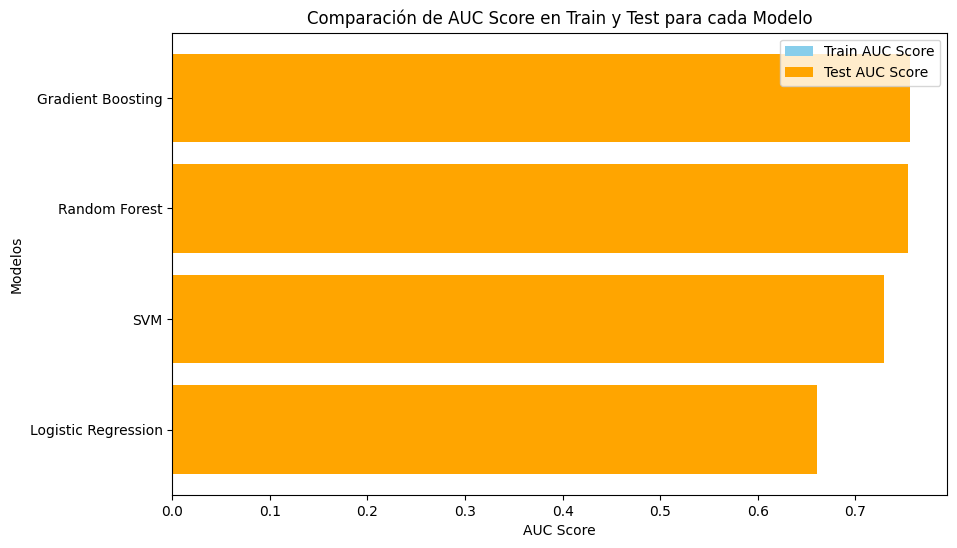

In [40]:
df1 = df_sample[df_sample['ID_Cliente'].isin(gr1)]
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

X = df1[['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]
y = df1['Anomalies_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'SVM': {'classifier__C': [0.1, 1, 10, 100], 'classifier__gamma': [0.1, 1, 10]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [3, 5, None]},
    'Gradient Boosting': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}
}

train_scores = []
test_scores = []

for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model)])
    clf = GridSearchCV(pipeline, params[name], scoring='roc_auc', cv=5)
    clf.fit(X_train, y_train)
    
    train_score = clf.best_score_
    
    best_model = clf.best_estimator_
    joblib.dump(best_model, f'test_{name}_1.joblib')

    
    train_scores.append(train_score)
    
    y_pred = clf.predict_proba(X_test)[:, 1]
    test_score = roc_auc_score(y_test, y_pred)
    test_scores.append(test_score)
    
    print(f'{name}: Best AUC Score (Train): {train_score}, Test AUC Score: {test_score}')
    print(f'Best Parameters: {clf.best_params_}')
    print('------------------------------------')

plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(models)), train_scores, color='skyblue', label='Train AUC Score')
plt.barh(np.arange(len(models)), test_scores, color='orange', label='Test AUC Score')
plt.yticks(np.arange(len(models)), models.keys())
plt.legend()
plt.xlabel('AUC Score')
plt.ylabel('Modelos')
plt.title('Comparación de AUC Score en Train y Test para cada Modelo')
plt.show()



Logistic Regression: Best AUC Score (Train): 0.6853512423815109, Test AUC Score: 0.6849457052470309
Best Parameters: {'classifier__C': 1}
------------------------------------
SVM: Best AUC Score (Train): 0.7182943825816077, Test AUC Score: 0.7003131377513727
Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 10}
------------------------------------
Random Forest: Best AUC Score (Train): 0.7894712784399668, Test AUC Score: 0.76610276531919
Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
------------------------------------
Gradient Boosting: Best AUC Score (Train): 0.7866466653700229, Test AUC Score: 0.7561998935740977
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
------------------------------------


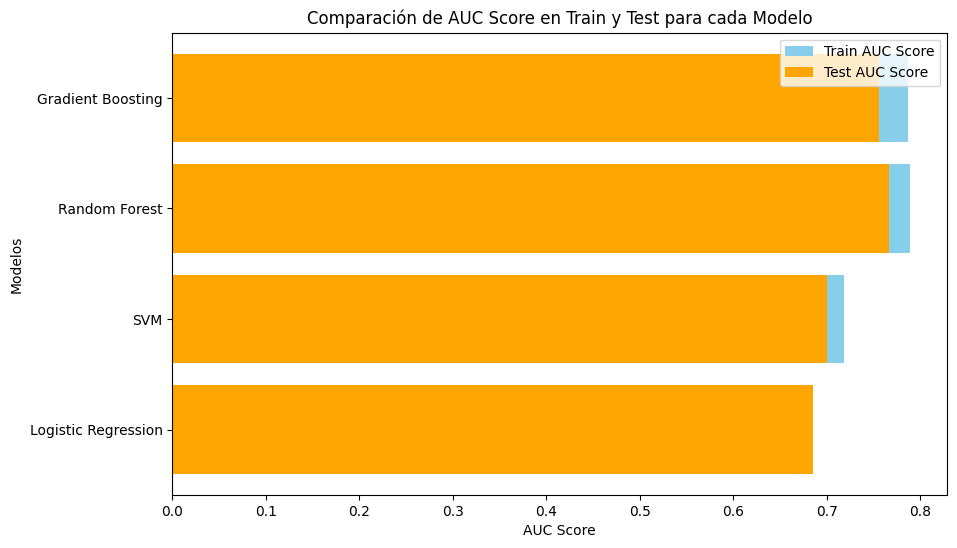

In [21]:
df2 = df_sample[df_sample['ID_Cliente'].isin(gr2)]
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

X = df2[['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]
y = df2['Anomalies_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'SVM': {'classifier__C': [0.1, 1, 10, 100], 'classifier__gamma': [0.1, 1, 10]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [3, 5, None]},
    'Gradient Boosting': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}
}

train_scores = []
test_scores = []

for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model)])
    clf = GridSearchCV(pipeline, params[name], scoring='roc_auc', cv=5)
    clf.fit(X_train, y_train)
    
    train_score = clf.best_score_
    
    best_model = clf.best_estimator_
    joblib.dump(best_model, f'test_{name}_1.joblib')

    
    train_scores.append(train_score)
    
    y_pred = clf.predict_proba(X_test)[:, 1]
    test_score = roc_auc_score(y_test, y_pred)
    test_scores.append(test_score)
    
    print(f'{name}: Best AUC Score (Train): {train_score}, Test AUC Score: {test_score}')
    print(f'Best Parameters: {clf.best_params_}')
    print('------------------------------------')

plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(models)), train_scores, color='skyblue', label='Train AUC Score')
plt.barh(np.arange(len(models)), test_scores, color='orange', label='Test AUC Score')
plt.yticks(np.arange(len(models)), models.keys())
plt.legend()
plt.xlabel('AUC Score')
plt.ylabel('Modelos')
plt.title('Comparación de AUC Score en Train y Test para cada Modelo')
plt.show()


Logistic Regression: Best AUC Score (Train): 0.730471378298674, Test AUC Score: 0.7331026210016711
Best Parameters: {'classifier__C': 0.1}
------------------------------------
SVM: Best AUC Score (Train): 0.8425628835522072, Test AUC Score: 0.813278580737575
Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 10}
------------------------------------
Random Forest: Best AUC Score (Train): 0.8837729068275639, Test AUC Score: 0.871223773350084
Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
------------------------------------
Gradient Boosting: Best AUC Score (Train): 0.8858883059686207, Test AUC Score: 0.878240050408394
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
------------------------------------


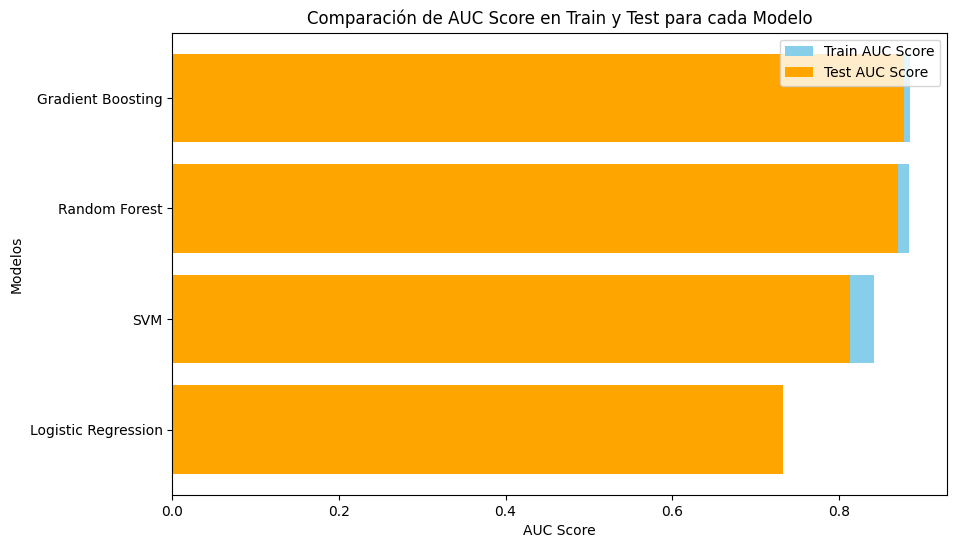

In [22]:
df3 = df_sample[df_sample['ID_Cliente'].isin(gr3)]
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

X = df3[['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]
y = df3['Anomalies_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'SVM': {'classifier__C': [0.1, 1, 10, 100], 'classifier__gamma': [0.1, 1, 10]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [3, 5, None]},
    'Gradient Boosting': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}
}

train_scores = []
test_scores = []

for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model)])
    clf = GridSearchCV(pipeline, params[name], scoring='roc_auc', cv=5)
    clf.fit(X_train, y_train)
    
    train_score = clf.best_score_
    
    best_model = clf.best_estimator_
    joblib.dump(best_model, f'test_{name}_1.joblib')

    
    train_scores.append(train_score)
    
    y_pred = clf.predict_proba(X_test)[:, 1]
    test_score = roc_auc_score(y_test, y_pred)
    test_scores.append(test_score)
    
    print(f'{name}: Best AUC Score (Train): {train_score}, Test AUC Score: {test_score}')
    print(f'Best Parameters: {clf.best_params_}')
    print('------------------------------------')

plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(models)), train_scores, color='skyblue', label='Train AUC Score')
plt.barh(np.arange(len(models)), test_scores, color='orange', label='Test AUC Score')
plt.yticks(np.arange(len(models)), models.keys())
plt.legend()
plt.xlabel('AUC Score')
plt.ylabel('Modelos')
plt.title('Comparación de AUC Score en Train y Test para cada Modelo')
plt.show()


## Anomalies with DBSCAN

In [ ]:


X = df_client1[['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir el modelo DBSCAN
epsilon = 0.3  # Radio de la vecindad
min_samples = 2  # Número mínimo de muestras en una vecindad para considerarse un núcleo
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

In [ ]:
def graphic_time_series(df, col):
    
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    plt.figure(figsize=(10, 6))
    plt.plot(df['Fecha'], df['Active_energy'], color='blue', label='Consumo de Energía Activa')

    anomalies = df[df[col] == 1]
    plt.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='red', label='Anomalías', zorder=5)
    plt.xlabel('Fecha')
    plt.ylabel('Consumo de Energía Activa')
    plt.title('Serie de Tiempo del Consumo de Energía Activa')
    plt.legend()

    plt.xticks(rotation=45)
    plt.show()
graphic_time_series(df_client1, 'Anomalies_time_serie')

In [ ]:
df_client1.groupby('Anomalies_time_serie').count()
df_client1.head()

## Interquartile range descriptive method

In [ ]:
X = df_client1[['Active_energy', 'Voltaje_FA']]

In [ ]:
# Calcular el rango intercuartil (IQR)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

std_dev = X.std()
std_dev_multiplier = 1.5
threshold = std_dev_multiplier * std_dev

anomalies_iqr = ((X < (Q1 - threshold * IQR)) | (X > (Q3 + threshold * IQR))).any(axis=1)

print(len(X[anomalies_iqr])/len(X))
print(X[anomalies_iqr].head())

In [ ]:
df_client1['Anomalies_descriptive'] = np.where(anomalies_iqr, 1, 0)
df_client1.head()

In [ ]:
import matplotlib.pyplot as plt
def graphic_time_series(df):
    
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    plt.figure(figsize=(10, 6))
    plt.plot(df['Fecha'], df['Active_energy'], color='blue', label='Consumo de Energía Activa')

    anomalies = df[df['Anomalies_descriptive'] == 1]
    plt.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='red', label='Anomalías', zorder=5)
    plt.xlabel('Fecha')
    plt.ylabel('Consumo de Energía Activa')
    plt.title('Serie de Tiempo del Consumo de Energía Activa')
    plt.legend()

    plt.xticks(rotation=45)
    plt.show()
graphic_time_series(df_client1)

In [ ]:
# Estandarizar los datos (es importante para K-means)

clusters = dbscan.fit_predict(X_scaled)

# Visualizar los clusters y los datos en el espacio
plt.figure(figsize=(8, 6))

# Visualizar los datos en el espacio
plt.scatter(X_scaled[:, 0], [0] * len(X_scaled), c='gray', alpha=0.5, label='Datos')

# Visualizar los clusters
for cluster_label in range(max(clusters) + 1):
    plt.scatter(X_scaled[clusters == cluster_label, 0], [0] * len(X_scaled[clusters == cluster_label]),
                label=f'Cluster {cluster_label}', alpha=0.5)

# Visualizar los centroides de los clusters
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], [0] * len(centroids), marker='x', c='red', s=100, label='Centroides')

plt.xlabel('Consumo de energía (estandarizado)')
plt.title('Clusters de consumo de energía')
plt.legend()
plt.show()

In [ ]:
df_client1[['Hour', 'Active_energy']].head()

In [ ]:
from sklearn.preprocessing import StandardScaler
X = df_client1[['Hour', 'Active_energy']]

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elegir el número óptimo de clusters utilizando el método del codo
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Visualizar la curva del codo para seleccionar K
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método del codo')
plt.show()

In [ ]:
df.head(10)

In [ ]:
day = 24
week = day*7
month = round(week*4.35)
year = round(month*12)
print(f'''
day = {day} hours
week = {week} hours
month = {month} hours
year = {year} hours
''')

In [ ]:
X = df[['Normalized power consumption', 'Normalized time']]

# Normalizar los datos
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Graficar la nube de puntos
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], alpha=0.5)
plt.title('Nube de puntos de Consumo de Energía Normalizado vs. Tiempo Normalizado')
plt.xlabel('Normalized power consumption')
plt.ylabel('Normalized time')
plt.grid(True)
plt.show()

In [ ]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Visualizar los clusters
plt.scatter(X, np.zeros_like(X), c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centers, np.zeros_like(centers), marker='x', c='r', s=100)
plt.xlabel('Consumo de energía')
plt.title('Clusters de consumo de energía')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#kmeans = KMeans(n_clusters=6, random_state = 42)
#clusters = kmeans.fit_predict(embeddings)

pca = PCA(n_components=2)
embeddings_2d = df_client1['Active_energy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('Productos antes de K-Means')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')

In [ ]:
df_final['Archivo'] = df_final['Archivo'].replace('[^0-9]', '', regex=True)
df_final['Archivo'] = 'Cliente ' + df_final['Archivo'].astype(str)
df_sector['Cliente:'] = df_sector['Cliente:'].str.strip()
df_final = df_final.merge(df_sector, left_on = 'Archivo', right_on = 'Cliente:', how='left')
df_final.drop(columns = 'Cliente:', inplace=True)
df_final.info()

In [ ]:
# Obtener la cantidad total de registros en df_final
cantidad_registros = df_final.shape[0]

# Imprimir la cantidad total de registros
print("La cantidad total de registros en df_final es:", cantidad_registros)

In [ ]:
df_final.info()

#### **Nivel de Granularidad**

In [ ]:
df_final.head(25)

Para entender el nivel de granularidad, basta con revisar la columna de 'Fecha', la cual nos indica la temporalidad con que se registraron los datos. Por ello, lo que nos indica esta columna es que la granularidad esta a nivel horario para una hora exacta del día. Es decir tenemos registros para cada hora del día (00:00 a 23:00)

In [ ]:
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

#### Exploración de valores en cada variable nivel general (Máximo, minimo y promedio)

In [ ]:
df_final.describe()

- Fecha: tenemos un intervalo de tiempo que empieza el 2021-01-01 a las 00:00 horas y termina el 2023-04-01 00:00. Es decir, tenemos una ventana temporal de 3 años de información.
- Energía activa: el valor minimo es negativo (- 1,32 kWh), lo cual nos indica que puede existir problemas en la captura de la información o falla en el sistema eléctrico. Dado que esta variable captura la cantidad real de energía activa consumida y se mide en terminos positivos. Luego tenemos un valor máximo registrado de 14,62 kWh y en promedio un valor de 1,47 kWh.
- Energía reactiva: el valor minimo es cero, un valor máximo de 11,13 kVARh y promedio de 0,87 kVARh.
- Voltaje_FA: valor minimo de 0,031 voltios, lo cual nos indica que puede existir un problema en la captura o en el contador, eso indica una situación anormal en el sistema electrico. Luego tenemos un valor máximo de 4.266,22 voltios y promedio de 1.420,18 voltios.
- Voltaje_FC: sus valores son muy similares y cercanos a la variable FA, dado que estamos hablando de un sistema trifásico. Por ello el valor minimo es 0,031 voltios, valor máximo 4.399,038 voltios y un valor promedio de 1.438,51 voltios.



#### Completitud de la serie temporal por cada cliente

In [ ]:
def calcular_porcentaje_completitud(df_final):
    # Asegurarse de que la columna 'Fecha' sea de tipo datetime
    df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

    # Rango de fechas especificado
    fecha_inicio = pd.Timestamp('2021-01-01 00:00:00')
    fecha_fin = pd.Timestamp('2023-04-01 00:00:00')

    # Filtrar el DataFrame para el rango de fechas especificado
    df_periodo = df_final[(df_final['Fecha'] >= fecha_inicio) & (df_final['Fecha'] <= fecha_fin)]

    # Calcular la duración total del periodo
    duracion_total = fecha_fin - fecha_inicio

    # Calcular la duración cubierta por cada archivo
    duracion_por_archivo = df_periodo.groupby('Archivo')['Fecha'].agg(lambda x: x.max() - x.min())

    # Calcular el porcentaje de completitud para cada archivo
    porcentaje_completitud = (duracion_por_archivo / duracion_total) * 100

    # Crear un DataFrame con los resultados
    resultados = pd.DataFrame({
        'Archivo': porcentaje_completitud.index,
        'Completitud': porcentaje_completitud.values,
        'Fecha inicio': df_periodo.groupby('Archivo')['Fecha'].min().values,
        'Fecha final': df_periodo.groupby('Archivo')['Fecha'].max().values
    })

    return resultados

Completitud = calcular_porcentaje_completitud(df_final)
Completitud

In [ ]:
# Filtrar archivos con completitud menor al 100%
archivos_incompletos = Completitud[Completitud['Completitud'] < 100]

# Obtener la cantidad de archivos incompletos
cantidad_archivos_incompletos = archivos_incompletos.shape[0]

# Imprimir la cantidad de archivos incompletos y la lista de archivos
print(f"Cantidad de archivos incompletos: {cantidad_archivos_incompletos}")
print("Archivos incompletos:")
print(archivos_incompletos[['Archivo', 'Completitud', 'Fecha inicio', 'Fecha final']])

Al revisar la completitud de la serie de tiempo para cada cliente se observa lo siguiente:

- De los 30 clientes, solo 10 (**33,3%**) tiene la información completa en el intervalo de tiempo mencionado anteriormente. Son los clientes 1 al 10.
- Solo 5 clientes tienen informacion completa al 99%, se puede pensar que se puede realizar alguna imputación para completar dicha información. Son los clientes número 16 al 20.
- Solo 4 clientes tienen información completa al 71,13%, desde 2021-01-01 00:00:00 a 2022-08-07 07:00:00. Se debe estudiar si la imputación de datos no afectaria el desarrollo del modelo más adelante. Son los clientes número 11, 13, 14 y 15
- Solo 7 clientes tiene información completa al 57,9%, desde 2021-01-01 00:00:00 a 2022-04-21 14:00:00. Se debe estudiar si la imputación de datos no afectaria el desarrollo del modelo más adelante. Son los clientes número 12, 26 al 30
- Por último tenemos 5 clientes que tienen información completa al 45,3%, desde 2021-01-01 00:00:00 a 2022-01-07 20:00:00. Se debe estudiar si la imputación de datos no afectaria el desarrollo del modelo más adelante. Son los clientes 21 al 25. Estos clientes son los que tiene la participación más baja y alejada a información más reciente para el análisis

#### Valores perdidos, valores en cero y valores negativos

In [ ]:
def analizar_participacion_valores(df):
    # Asegurarse de que la columna 'Fecha' sea de tipo datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Calcular la participación de valores perdidos por archivo y variable
    participacion_valores_perdidos = df.groupby('Archivo').apply(lambda x: x.isnull().mean()*100)

    # Calcular la participación de valores negativos por archivo y variable
    participacion_valores_negativos = df.groupby('Archivo').apply(lambda x: (x.select_dtypes(include='number') < 0).mean()*100)

    # Calcular la participación de valores en cero por archivo y variable
    participacion_valores_cero = df.groupby('Archivo').apply(lambda x: (x.select_dtypes(include='number') == 0).mean()*100)

    # Crear un DataFrame con los resultados
    resultados = pd.DataFrame({
        'Participacion_Valores_Perdidos': participacion_valores_perdidos.unstack(),
        'Participacion_Valores_Negativos': participacion_valores_negativos.unstack(),
        'Participacion_Valores_Cero': participacion_valores_cero.unstack()
    })

    return resultados

# Ejemplo de uso:
# Suponiendo que df_final es tu DataFrame consolidado
resultados_analisis = analizar_participacion_valores(df_final)
resultados_analisis

Al revisar si la información recopilada por cada cliente la participación de valores perdidos, valores en cero y valores negativos si encontro lo siguiente. Cabe mencionar que este análisis se realiza en cada serie de tiempo disponible en cada cliente:

- Valores perdidos: No se encuentran valores perdidos en ningun cliente y tampoco en ninguna variable
- Valores en cero: 
    - Energía activa: Se observa que 11 clientes tienen registros con valores en cero. Con una participación entre 20,1% y 12,26%
    - Energía reactiva: Se observa que 11 clientes tienen registros con valores en cero. Con una participación entre 20.1% y 12,26%. Es similar a la energía activa, dado que pertenecen a un sistema trifásico. Aunque es importante revisar si hay causalidad entre estas dos variables.
    - Voltaje FA y FC: no existen registros con valores en cero en los 30 clientes.
- Valores negativos:
    - Energía activa: Se observa que 3 clientes tienen registros con valores negativos. Con una participación entre 0,17% y 1,31%. Estos registros se podrían imputar para el desarrollo del modelo más adelante.
    - Energía reactiva: No existen registros con valores negativos en los 30 clientes.
    - Voltaje FA y FC: no existen registros con valores en cero en los 30 clientes.


#### Análisis de tendencia de las series de tiempo por cada cliente. Variable a analizar: Energía activa

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import entropy

def plot_resampled(df_final, aggregation='sum', frecuencia='D'):
    """
    Función para resamplear, visualizar y analizar la serie de tiempo de consumo de energía activa.

    Parámetros:
    - df_final: DataFrame que contiene los datos de energía.
    - aggregation: Método de agregación para resampleo ('sum', 'mean', 'max', etc.).
    - frecuencia: Frecuencia de resampleo ('D' para diario, 'M' para mensual, etc.).

    Retorna:
    - None (muestra los gráficos y resultados del análisis).
    """

    # Convertir la columna 'Fecha' a tipo datetime y establecerla como índice
    df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
    df_final = df_final.set_index('Fecha')

    # Agrupar por el nombre del archivo y resampleo y agregación
    grouped_df = df_final.groupby('Archivo').resample(frecuencia).agg({'Active_energy': aggregation}).reset_index()

    for archivo in df_final['Archivo'].unique():
        # Visualizar serie temporal resampleada para cada archivo
        plt.figure(figsize=(15, 6))
        sns.lineplot(x='Fecha', y='Active_energy', data=grouped_df[grouped_df['Archivo'] == archivo],
                     label=f'Energía Activa ({frecuencia.capitalize()}) - {aggregation.capitalize()}')
        plt.title(f'Consumo de energía activa ({frecuencia.capitalize()}) - {aggregation.capitalize()} - {archivo}')
        plt.xlabel('Fecha')
        plt.ylabel('Energía Activa')
        plt.legend()
        plt.show()
        
        # Descomposición de la serie de tiempo
        df_archivo = grouped_df[grouped_df['Archivo'] == archivo].set_index('Fecha')
        result = seasonal_decompose(df_archivo['Active_energy'], model='additive', period=7)  # Ajusta el periodo según tu serie temporal
        entropy_value = entropy(df_archivo['Active_energy'].dropna())
        
        # Graficar la descomposición
        plt.figure(figsize=(15, 8))
        plt.subplot(4, 1, 1)
        plt.plot(result.trend, label='Tendencia')
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(result.seasonal, label='Estacionalidad')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(result.resid, label='Residuos')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(result.observed, label='Observado')
        plt.legend()

        plt.suptitle(f'Descomposición de la Serie Temporal - {archivo}')
        plt.show()

        # Prueba de Dickey-Fuller
        resultado_adf = adfuller(df_archivo['Active_energy'], autolag='AIC')

        # Imprimir el resultado de la prueba
        print(f'\nResultado de la Prueba de Dickey-Fuller para {archivo}:')
        print(f'Estadística de Prueba: {resultado_adf[0]}')
        print(f'Valor p: {resultado_adf[1]}')
        print(f'Valores Críticos: {resultado_adf[4]}')
        
        print(f'Entropía de la distribución: {entropy_value}')
        # Interpretar el resultado de la prueba
        if resultado_adf[1] <= 0.05:
            print('\nResultado: La serie temporal es estacionaria (rechazamos la hipótesis nula)')
        else:
            print('\nResultado: La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula)')

# Ejemplo de uso
frecuencia = 'D'
plot_resampled(df_final, aggregation='sum', frecuencia=frecuencia)

In [ ]:
df_final.info()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_resampled_with_anomalies(df_final, aggregation='sum', frecuencia='D', anomaly_threshold=1):
    """
    Función para resamplear, visualizar y analizar la serie de tiempo de consumo de energía activa con detección de anomalías.

    Parámetros:
    - df_final: DataFrame que contiene los datos de energía.
    - aggregation: Método de agregación para resampleo ('sum', 'mean', 'max', etc.).
    - frecuencia: Frecuencia de resampleo ('D' para diario, 'M' para mensual, etc.).
    - anomaly_threshold: Umbral para la detección de anomalías basado en la desviación estándar.

    Retorna:
    - None (muestra los gráficos y resultados del análisis).
    """

    # Convertir la columna 'Fecha' a tipo datetime y establecerla como índice
    df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
    df_final = df_final.set_index('Fecha')

    # Agrupar por el nombre del archivo y resampleo y agregación
    grouped_df = df_final.groupby('Archivo').resample(frecuencia).agg({'Active_energy': aggregation}).reset_index()

    for archivo in df_final['Archivo'].unique():
        # Calcular la media y desviación estándar para la serie temporal
        mean_value = grouped_df[grouped_df['Archivo'] == archivo]['Active_energy'].mean()
        std_value = grouped_df[grouped_df['Archivo'] == archivo]['Active_energy'].std()

        # Detectar anomalías basadas en la desviación estándar
        anomalies = grouped_df[(grouped_df['Archivo'] == archivo) & 
                                ((grouped_df['Active_energy'] > mean_value + anomaly_threshold * std_value) |
                                 (grouped_df['Active_energy'] < mean_value - anomaly_threshold * std_value))]

        # Visualizar serie temporal resampleada para cada archivo
        plt.figure(figsize=(15, 6))
        
        # Graficar la serie temporal
        sns.lineplot(x='Fecha', y='Active_energy', data=grouped_df[grouped_df['Archivo'] == archivo],
                     label=f'Energía Activa ({frecuencia.capitalize()}) - {aggregation.capitalize()}')
        
        # Resaltar anomalías en rojo
        sns.scatterplot(x='Fecha', y='Active_energy', data=anomalies, color='red', label='Anomalías')
        
        plt.title(f'Consumo de energía activa ({frecuencia.capitalize()}) - {aggregation.capitalize()} - {archivo}')
        plt.xlabel('Fecha')
        plt.ylabel('Energía Activa')
        plt.legend()
        plt.show()

# Ejemplo de uso
frecuencia = 'H'
plot_resampled_with_anomalies(df_final, aggregation='sum', frecuencia=frecuencia)


In [ ]:
print("Se seleccionan {} clientes, para el analisis, de los cuales el % de completitud de los datos es superior al 95%".format(len(Completitud[Completitud['Completitud'] > 90])))

In [ ]:
df_final.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

resumen = pd.DataFrame(columns=[
    'Cliente',
    'Sector Economico',
    'Media del consumo de energía activa',
    'Varianza del consumo de energía activa',
    'Media del consumo de energía reactiva',
    'Varianza del consumo de energía reactiva'
])

client = list(Completitud[Completitud['Completitud'] > 90]['Archivo'])
for k in client:

    df_cliente = df_final[df_final['Archivo'] == k]
    df_cliente = df_cliente.reset_index()
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    axes = axes.flatten()
    sns.lineplot(x='Fecha', y='Active_energy', data=df_cliente, ax=axes[0])
    axes[0].set_title(f'Consumo de Energía Activa - Cliente: {k}')
    axes[0].set_xlabel('Fecha')
    axes[0].set_ylabel('Consumo de Energía Activa')

    sns.lineplot(x='Fecha', y='Reactive_energy', data=df_cliente, ax=axes[1])
    axes[1].set_title(f'Consumo de Energía Reactiva - Cliente: {k}')
    axes[1].set_xlabel('Fecha')
    axes[1].set_ylabel('Consumo de Energía Reactiva')

    sns.lineplot(x='Fecha', y='Voltaje_FA', data=df_cliente, label='FA', ax=axes[2])
    sns.lineplot(x='Fecha', y='Voltaje_FC', data=df_cliente, label='FC', ax=axes[2])
    axes[2].set_title(f'Voltajes - Cliente: {k}')
    axes[2].set_xlabel('Fecha')
    axes[2].set_ylabel('Voltaje')
    axes[2].legend()

    sns.violinplot(x='Active_energy', data=df_cliente, ax=axes[3])
    axes[3].set_title(f'Diagrama de Violín - Consumo de Energía Activa')

    sns.boxplot(x='Reactive_energy', data=df_cliente, ax=axes[4])
    axes[4].set_title(f'Boxplot - Consumo de Energía Reactiva')

    plt.tight_layout()
    plt.show()
        
    resumen = resumen.append({
        'Cliente': k,
        'Sector Economico': df_cliente.loc[0, 'Sector Económico:'],
        'Media del consumo de energía activa': df_cliente["Active_energy"].mean(),
        'Varianza del consumo de energía activa': df_cliente["Active_energy"].var(),
        'Media del consumo de energía reactiva': df_cliente["Reactive_energy"].mean(),
        'Varianza del consumo de energía reactiva' : df_cliente["Reactive_energy"].var()
    }, ignore_index=True)

In [ ]:
resumen.to_excel('tabla.xlsx', index=False)